# Improving Training-Free Neural Architecture Search using NRPA and NTK

In this notebook, we design several experiments aimed at evaluating two innovative NAS methods:

- A more efficient **search algorithm**, NRPA, that leverages Monte-Carlo playouts
- A more robust **training-free metric** based on the NTK

We conduct these experiments on the following NAS benchmark datasets:
- NAS-Bench-101
- NAS-Bench-201
- NAS-Bench-301
- NATS-Bench Size

## Imports

### Importing basic libraries

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import json
from utils.helpers import configure_seaborn, normalize
import importlib
configure_seaborn()
from scipy.stats import spearmanr

In [42]:
from nasbench import api  # NB101
from nas_201_api import NASBench201API as API  # NB201
import nasbench301 as nb  # NB301
import nats_bench  # NATS

### Importing our libraries

In [43]:
# NAS-Bench-101
from nas_bench_101.NASBench101Node import *
from nas_bench_101.NASBench101MCTS import *
from nas_bench_101.NASBench101RandomSearch import *
from nas_bench_101.NASBench101RegEvo import *

# NAS-Bench-201
from nas_bench_201.NASBench201Node import *
from nas_bench_201.NASBench201MCTS import *
from nas_bench_201.NASBench201RandomSearch import *
from nas_bench_201.NASBench201RegEvo import *

# NAS-Bench-301
from nas_bench_301.NASBench301Node import *
from nas_bench_301.NASBench301MCTS import *
from nas_bench_301.NASBench301RandomSearch import *
from nas_bench_301.NASBench301RegEvo import *

# NATS-Bench
from nats_bench_dataset.NATSBenchNode import *
from nats_bench_dataset.NATSBenchMCTS import *
from nats_bench_dataset.NATSBenchRandomSearch import *
from nats_bench_dataset.NATSBenchRegEvo import *

## Evaluating the search algorithms

Creating a dictionary of datasets for evaluation. This cell can take time to run.

In [72]:
models_1_0_dir = "/userdata/T0259728/projets/nas_ntk/nas_bench_301/nasbench301_models_v1.0/nb_models"
model_paths = {
    model_name: os.path.join(models_1_0_dir, '{}_v1.0'.format(model_name))
    for model_name in ['xgb', 'lgb_runtime']
}
NB_301_performance_model = nb.load_ensemble(model_paths['xgb'])

nas_bench_201_api = API('/userdata/T0259728/Bureau/NAS-Bench-201-v1_1-096897.pth', verbose=False)

nas_bench_101_api = api.NASBench("/userdata/T0259728/projets/nasbench-master/nasbench_full.tfrecord")

nats_bench_api = nats_bench.create("/userdata/T0259728/projets/nas_ntk/nats_bench_dataset/NATS-sss-v1_0-50262-simple", "sss", fast_mode=True, verbose=False)

[12:46:38] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[12:46:40] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[12:46:42] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, pl

In [73]:
datasets = {
            "nas_bench_101": {"api": nas_bench_101_api,
                              "n_runs": 100,
                              "n_iter": 3375,
                              "nrpa_level": 3,
                              "nrpa_alpha": .01},
            "nas_bench_201": {"api": nas_bench_201_api,
                              "n_runs": 100,
                              "n_iter": 2000,
                              "nrpa_level": 3,
                              "nrpa_alpha": .1}, 
            "nas_bench_301": {"api": NB_301_performance_model,
                              "n_runs": 100,
                              "n_iter": 10000,
                              "nrpa_level": 3,
                              "nrpa_alpha": 1},
            "nats_bench"   : {"api": nats_bench_api,
                              "n_runs": 100,
                              "n_iter": 4000,
                              "nrpa_level": 3,
                              "nrpa_alpha": .1}
           }

### NAS-Bench-101

In [74]:
from nas_bench_101 import NASBench101RandomSearch
importlib.reload(NASBench101RandomSearch)
from nas_bench_101.NASBench101RandomSearch import *

In [75]:
methods = {"Random search": [], 
           "Regularized evolution": [], 
           "UCT": [], 
           # "RAVE": [],
           # "GRAVE": [],
           "NRPA": []}

params = datasets["nas_bench_101"]

for i in range(params["n_runs"]):
    print(f"RUN N° {i+1}/{params['n_runs']}")
    
    rs = RandomSearchNASBench101(api=params["api"],
                                 max_iter=params["n_iter"])
    
    re = RegularizedEvolutionNB101(api=params["api"],
                                  population_size=50,
                                  cycles=params["n_iter"],
                                  sample_size=25)
    
    root_node_uct = NASBench101Node.NASBench101Node(state=NASBench101Cell(n_vertices=7))
    uct = NASBench101UCT(root_node_uct,
                         api=params["api"],
                         params_path="/userdata/T0259728/projets/nas_ntk/utils/params.json",
                         disable_tqdm=False)
    uct.n_iter = params["n_iter"]//(12*uct.playouts_per_selection)

    # root_node_rave = NASBench101Node.NASBench101AMAFNode(state=NASBench101Cell(n_vertices=7))
    # rave = NASBench101RAVE(root_node_rave,
    #                      api=params["api"],
    #                      params_path="/userdata/T0259728/projets/nas_ntk/utils/params.json",
    #                      disable_tqdm=False)
    # rave.n_iter = params["n_iter"]//(12*rave.playouts_per_selection)

    # root_node_grave = NASBench101Node.NASBench101AMAFNode(state=NASBench101Cell(n_vertices=7))
    # grave = NASBench101GRAVE(root_node_grave,
    #                      api=params["api"],
    #                      params_path="/userdata/T0259728/projets/nas_ntk/utils/params.json",
    #                      disable_tqdm=False)
    # grave.n_iter = params["n_iter"]//(12*grave.playouts_per_selection)
    
    root_node_nrpa = NASBench101NestedNode(state=NASBench101Cell(n_vertices=7), sequence=[])
    nrpa = NASBench101NRPA(root_node_nrpa,
                         params["nrpa_level"],
                         api=params["api"],
                         params_path="/userdata/T0259728/projets/nas_ntk/utils/params.json",
                         disable_tqdm=False)
    nrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nrpa.alpha = params["nrpa_alpha"]
    
    try:
        rs.run()
        re.run()
        _, _, _ = uct.main_loop()
        # _, _, _ = rave.main_loop()
        # _, _, _ = grave.main_loop()
        _, _, _ = nrpa.main_loop()
    
        
        methods["Random search"].append(rs.best_accs[1:])
        methods["Regularized evolution"].append(re.best_accs[1:])
        methods["UCT"].append(uct.best_reward)
        # methods["RAVE"].append(rave.best_reward)
        # methods["GRAVE"].append(grave.best_reward)
        methods["NRPA"].append(nrpa.best_reward)
        
    except Exception: pass

    with open("runs/NASBench101.json", "w+") as f:
        json.dump(methods, f)

RUN N° 1/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1740.20it/s]


Best accuracy: 0.9477163553237915
1000: Best acc : 0.9486178159713745
2000: Best acc : 0.9486178159713745
3000: Best acc : 0.9489182829856873
Best accuracy: 0.9489182829856873


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:02<00:00, 119.90it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:02<00:00, 128.08it/s]


(4, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:02<00:00, 136.38it/s]


(2, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 147.86it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 154.86it/s]


(5, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 158.85it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 166.44it/s]


(4, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 196.08it/s]


(5, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 202.95it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 252.17it/s]


(2, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 351.12it/s]


(4, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 708.39it/s]


(3, 'set_label', 'conv1x1-bn-relu')


Current best reward : 0.9518: 100%|█████████| 3375/3375 [00:34<00:00, 97.03it/s]


Sequence is [(2, 'build_edge', 0), (3, 'build_edge', 0), (6, 'build_edge', 0), (1, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 0), (5, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 1), (4, 'set_label', 'conv3x3-bn-relu'), (2, 'set_label', 'conv3x3-bn-relu'), (3, 'build_edge', 2), (5, 'build_edge', 3), (3, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 2/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1929.98it/s]


Best accuracy: 0.9477163553237915
1000: Best acc : 0.9489182829856873
2000: Best acc : 0.9489182829856873
3000: Best acc : 0.9489182829856873
Best accuracy: 0.9489182829856873


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 140.91it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 151.88it/s]


(2, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 160.88it/s]


(4, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 168.04it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 179.53it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 182.56it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 175.43it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 188.95it/s]


(3, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 195.03it/s]


(3, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 243.86it/s]


(2, 'set_label', 'conv1x1-bn-relu')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:28<00:00, 118.35it/s]


Sequence is [(1, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 1), (3, 'build_edge', 2), (5, 'build_edge', 0), (3, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 3), (6, 'build_edge', 0), (2, 'build_edge', 0), (3, 'build_edge', 0), (5, 'set_label', 'conv3x3-bn-relu'), (4, 'set_label', 'maxpool3x3'), (2, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 3/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 2070.75it/s]


Best accuracy: 0.9471153616905212
1000: Best acc : 0.9481169581413269
2000: Best acc : 0.9489182829856873
3000: Best acc : 0.9489182829856873
Best accuracy: 0.9489182829856873


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 150.86it/s]


(3, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:02<00:00, 132.09it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 155.00it/s]


(6, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 163.95it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 181.40it/s]


(3, 'set_label', 'conv3x3-bn-relu')


  9%|███▉                                      | 26/281 [00:00<00:03, 65.91it/s]

[[0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]
['input', 'conv3x3-bn-relu', 'maxpool3x3', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'conv3x3-bn-relu', 'output']
False


RUN N° 4/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1817.41it/s]


Best accuracy: 0.9485176205635071
1000: Best acc : 0.9489182829856873
2000: Best acc : 0.9518229365348816
3000: Best acc : 0.9518229365348816
Best accuracy: 0.9518229365348816


100%|████████████████████████████████████████| 281/281 [00:02<00:00, 126.55it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 152.82it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 163.11it/s]


(5, 'set_label', 'conv3x3-bn-relu')


 25%|██████████▎                              | 71/281 [00:00<00:01, 106.90it/s]


[[0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]
['input', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'conv3x3-bn-relu', 'maxpool3x3', 'conv3x3-bn-relu', 'output']
False
RUN N° 5/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1979.20it/s]


Best accuracy: 0.9481169581413269
1000: Best acc : 0.9485176205635071
2000: Best acc : 0.9499198794364929
3000: Best acc : 0.9499198794364929
Best accuracy: 0.9499198794364929


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 146.46it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 155.23it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 163.94it/s]


(4, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 168.64it/s]


(6, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 177.52it/s]


(2, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 188.61it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 204.06it/s]


(2, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 232.88it/s]


(4, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 274.41it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 298.34it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 418.75it/s]


(6, 'build_edge', 4)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 827.57it/s]


(3, 'set_label', 'conv1x1-bn-relu')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:28<00:00, 119.92it/s]


Sequence is [(1, 'set_label', 'conv3x3-bn-relu'), (6, 'build_edge', 0), (5, 'build_edge', 4), (5, 'build_edge', 1), (5, 'set_label', 'conv3x3-bn-relu'), (4, 'set_label', 'conv3x3-bn-relu'), (4, 'build_edge', 0), (2, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 0), (4, 'build_edge', 2), (2, 'build_edge', 0), (3, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 6/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1832.54it/s]


Best accuracy: 0.9472155570983887
1000: Best acc : 0.9488180875778198
2000: Best acc : 0.9489182829856873
3000: Best acc : 0.9489182829856873
Best accuracy: 0.9489182829856873


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:02<00:00, 122.19it/s]


(4, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:02<00:00, 124.03it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:02<00:00, 136.04it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 147.99it/s]


(4, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 155.41it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 166.19it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 172.81it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 182.39it/s]


(3, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 206.51it/s]


(2, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 254.05it/s]


(4, 'set_label', 'conv1x1-bn-relu')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:29<00:00, 114.26it/s]


Sequence is [(5, 'build_edge', 3), (6, 'build_edge', 0), (1, 'set_label', 'conv3x3-bn-relu'), (3, 'build_edge', 0), (5, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 1), (2, 'set_label', 'conv3x3-bn-relu'), (2, 'build_edge', 0), (3, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 0), (3, 'build_edge', 2), (4, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 7/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 2004.88it/s]


Best accuracy: 0.9472155570983887
1000: Best acc : 0.9474158883094788
2000: Best acc : 0.9486178159713745
3000: Best acc : 0.9486178159713745
Best accuracy: 0.9486178159713745


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 147.36it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 157.45it/s]


(6, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 154.13it/s]


(4, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 170.70it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|█████████████████████████████████████████| 281/281 [00:08<00:00, 34.35it/s]


(3, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 202.56it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 216.44it/s]


(2, 'set_label', 'maxpool3x3')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 263.84it/s]


(4, 'set_label', 'conv1x1-bn-relu')


Current best reward : 0.9500: 100%|████████| 3375/3375 [00:28<00:00, 119.64it/s]


Sequence is [(5, 'build_edge', 0), (6, 'build_edge', 0), (2, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 1), (4, 'build_edge', 2), (1, 'set_label', 'conv3x3-bn-relu'), (4, 'set_label', 'conv3x3-bn-relu'), (4, 'build_edge', 0), (5, 'set_label', 'conv3x3-bn-relu'), (2, 'build_edge', 1), (5, 'build_edge', 4), (3, 'set_label', 'conv1x1-bn-relu')] with score 0.9500200152397156
RUN N° 8/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1828.93it/s]


Best accuracy: 0.9472155570983887
1000: Best acc : 0.9495192170143127
2000: Best acc : 0.9495192170143127
3000: Best acc : 0.9495192170143127
Best accuracy: 0.9495192170143127


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:02<00:00, 122.93it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:02<00:00, 133.16it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 142.39it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 151.63it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 155.17it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 176.94it/s]


(4, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 181.19it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 190.81it/s]


(4, 'set_label', 'maxpool3x3')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 233.63it/s]


(2, 'set_label', 'maxpool3x3')


Current best reward : 0.9511: 100%|████████| 3375/3375 [00:29<00:00, 114.35it/s]


Sequence is [(5, 'build_edge', 0), (5, 'build_edge', 1), (1, 'set_label', 'conv3x3-bn-relu'), (2, 'build_edge', 0), (5, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 3), (3, 'set_label', 'conv3x3-bn-relu'), (3, 'build_edge', 0), (6, 'build_edge', 0), (3, 'build_edge', 2), (2, 'set_label', 'conv3x3-bn-relu'), (4, 'set_label', 'conv3x3-bn-relu')] with score 0.9511218070983887
RUN N° 9/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1939.24it/s]


Best accuracy: 0.9506210088729858
1000: Best acc : 0.9491186141967773
2000: Best acc : 0.9491186141967773
3000: Best acc : 0.9491186141967773
Best accuracy: 0.9491186141967773


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 144.61it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 154.13it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 166.77it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 177.12it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 183.59it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 195.66it/s]


(3, 'set_label', 'maxpool3x3')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 214.06it/s]


(2, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 224.76it/s]


(5, 'build_edge', 4)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 230.22it/s]


(2, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 289.46it/s]


(4, 'set_label', 'conv1x1-bn-relu')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:28<00:00, 117.58it/s]


Sequence is [(5, 'build_edge', 4), (1, 'set_label', 'conv3x3-bn-relu'), (4, 'build_edge', 2), (6, 'build_edge', 0), (5, 'set_label', 'conv3x3-bn-relu'), (2, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 1), (5, 'build_edge', 0), (4, 'set_label', 'conv3x3-bn-relu'), (2, 'build_edge', 0), (4, 'build_edge', 0), (3, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 10/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1921.32it/s]


Best accuracy: 0.9472155570983887
1000: Best acc : 0.9472155570983887
2000: Best acc : 0.9472155570983887
3000: Best acc : 0.9489182829856873
Best accuracy: 0.9489182829856873


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:02<00:00, 135.96it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 154.86it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 158.84it/s]


(4, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 167.55it/s]


(3, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 175.56it/s]


(4, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 191.63it/s]


(2, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 217.59it/s]


(2, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 223.57it/s]


(6, 'build_edge', 4)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 234.96it/s]


(3, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 294.82it/s]


(5, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 539.39it/s]


(1, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 831.33it/s]


(3, 'set_label', 'conv1x1-bn-relu')


Current best reward : 0.9493: 100%|████████| 3375/3375 [00:28<00:00, 117.40it/s]


Sequence is [(5, 'build_edge', 0), (5, 'build_edge', 1), (1, 'set_label', 'conv3x3-bn-relu'), (6, 'build_edge', 0), (3, 'set_label', 'conv3x3-bn-relu'), (3, 'build_edge', 1), (5, 'build_edge', 3), (4, 'build_edge', 0), (5, 'build_edge', 4), (4, 'set_label', 'maxpool3x3'), (2, 'set_label', 'conv1x1-bn-relu'), (5, 'set_label', 'conv3x3-bn-relu')] with score 0.9493188858032227
RUN N° 11/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1914.65it/s]


Best accuracy: 0.9486178159713745
1000: Best acc : 0.9472155570983887
2000: Best acc : 0.9504206776618958
3000: Best acc : 0.9504206776618958
Best accuracy: 0.9504206776618958


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:02<00:00, 139.88it/s]


(5, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 144.59it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 157.35it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 169.24it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 179.78it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 190.30it/s]


(4, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 198.41it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 212.14it/s]


(3, 'set_label', 'maxpool3x3')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 231.76it/s]


(4, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 292.97it/s]


(6, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 574.68it/s]


(2, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 837.64it/s]


(4, 'set_label', 'maxpool3x3')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:27<00:00, 122.44it/s]


Sequence is [(5, 'build_edge', 1), (5, 'build_edge', 0), (1, 'set_label', 'conv3x3-bn-relu'), (5, 'set_label', 'conv3x3-bn-relu'), (6, 'build_edge', 0), (5, 'build_edge', 3), (3, 'build_edge', 0), (2, 'build_edge', 0), (2, 'set_label', 'conv3x3-bn-relu'), (3, 'build_edge', 2), (4, 'set_label', 'maxpool3x3'), (3, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 12/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1959.95it/s]


Best accuracy: 0.9472155570983887
1000: Best acc : 0.9518229365348816
2000: Best acc : 0.9518229365348816
3000: Best acc : 0.9518229365348816
Best accuracy: 0.9518229365348816


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 146.97it/s]


(4, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 152.61it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 170.25it/s]


(5, 'set_label', 'conv3x3-bn-relu')


 32%|█████████████▎                           | 91/281 [00:00<00:01, 118.20it/s]


[[0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]
['input', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'output']
False
RUN N° 13/100


100%|██████████████████████████████████████| 3375/3375 [00:07<00:00, 460.92it/s]


Best accuracy: 0.9491186141967773
1000: Best acc : 0.9489182829856873
2000: Best acc : 0.9489182829856873
3000: Best acc : 0.9499198794364929
Best accuracy: 0.9499198794364929


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 145.62it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 153.78it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 166.88it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 174.84it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 187.14it/s]


(3, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 208.83it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 219.89it/s]


(2, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 259.98it/s]


(5, 'build_edge', 4)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 281.28it/s]


(4, 'set_label', 'conv1x1-bn-relu')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:28<00:00, 118.25it/s]


Sequence is [(1, 'set_label', 'conv3x3-bn-relu'), (6, 'build_edge', 0), (5, 'build_edge', 4), (5, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 1), (5, 'build_edge', 0), (4, 'build_edge', 2), (4, 'set_label', 'conv3x3-bn-relu'), (2, 'build_edge', 0), (4, 'build_edge', 0), (2, 'set_label', 'conv3x3-bn-relu'), (3, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 14/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1910.79it/s]


Best accuracy: 0.9503205418586731
1000: Best acc : 0.9472155570983887
2000: Best acc : 0.9481169581413269
3000: Best acc : 0.9481169581413269
Best accuracy: 0.9481169581413269


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 147.13it/s]


(3, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 154.64it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 169.49it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 180.78it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 190.22it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 198.73it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 218.47it/s]


(4, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 232.23it/s]


(4, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 240.49it/s]


(4, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 300.40it/s]


(2, 'set_label', 'maxpool3x3')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:28<00:00, 118.15it/s]


Sequence is [(3, 'build_edge', 0), (3, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 0), (6, 'build_edge', 0), (1, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 1), (5, 'build_edge', 3), (2, 'build_edge', 0), (5, 'set_label', 'conv3x3-bn-relu'), (3, 'build_edge', 2), (2, 'set_label', 'conv3x3-bn-relu'), (4, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 15/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1908.43it/s]


Best accuracy: 0.9474158883094788
1000: Best acc : 0.9493188858032227
2000: Best acc : 0.9493188858032227
3000: Best acc : 0.9493188858032227
Best accuracy: 0.9493188858032227


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 143.24it/s]


(4, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 150.90it/s]


(4, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 156.27it/s]


(4, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 166.58it/s]


(6, 'build_edge', 4)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 174.46it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 192.49it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 204.34it/s]


(4, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 216.00it/s]


(3, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 215.34it/s]


(2, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 309.54it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 476.44it/s]


(2, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 722.70it/s]


(5, 'set_label', 'maxpool3x3')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:28<00:00, 119.29it/s]


Sequence is [(5, 'build_edge', 1), (1, 'set_label', 'conv3x3-bn-relu'), (5, 'set_label', 'conv3x3-bn-relu'), (3, 'build_edge', 0), (5, 'build_edge', 4), (5, 'build_edge', 0), (4, 'build_edge', 0), (6, 'build_edge', 0), (4, 'set_label', 'conv3x3-bn-relu'), (2, 'set_label', 'conv1x1-bn-relu'), (4, 'build_edge', 3), (3, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 16/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1828.16it/s]


Best accuracy: 0.9472155570983887
1000: Best acc : 0.9489182829856873
2000: Best acc : 0.9489182829856873
3000: Best acc : 0.9511218070983887
Best accuracy: 0.9511218070983887


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:02<00:00, 120.43it/s]


(6, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:02<00:00, 124.48it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:02<00:00, 135.80it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 141.63it/s]


(4, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 155.08it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 174.45it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 185.54it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 192.37it/s]


(3, 'set_label', 'maxpool3x3')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 235.94it/s]


(3, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 248.15it/s]


(2, 'set_label', 'maxpool3x3')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:29<00:00, 114.55it/s]


Sequence is [(4, 'build_edge', 2), (5, 'build_edge', 0), (6, 'build_edge', 0), (5, 'build_edge', 1), (4, 'build_edge', 0), (2, 'build_edge', 0), (5, 'set_label', 'conv3x3-bn-relu'), (1, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 4), (2, 'set_label', 'conv3x3-bn-relu'), (3, 'set_label', 'conv3x3-bn-relu'), (4, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 17/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1927.21it/s]


Best accuracy: 0.9481169581413269
1000: Best acc : 0.9518229365348816
2000: Best acc : 0.9518229365348816
3000: Best acc : 0.9518229365348816
Best accuracy: 0.9518229365348816


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 141.26it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 151.17it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 159.59it/s]


(2, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 180.80it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 185.54it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 214.18it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 250.71it/s]


(4, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 267.16it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 278.34it/s]


(4, 'set_label', 'conv3x3-bn-relu')


Current best reward : 0.9496: 100%|████████| 3375/3375 [00:29<00:00, 116.35it/s]


Sequence is [(6, 'build_edge', 0), (1, 'set_label', 'conv3x3-bn-relu'), (5, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 1), (3, 'build_edge', 0), (3, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 3), (2, 'set_label', 'maxpool3x3'), (5, 'build_edge', 0), (4, 'build_edge', 0), (6, 'build_edge', 4), (4, 'set_label', 'conv3x3-bn-relu')] with score 0.9496194124221802
RUN N° 18/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1964.73it/s]


Best accuracy: 0.9472155570983887
1000: Best acc : 0.9472155570983887
2000: Best acc : 0.9481169581413269
3000: Best acc : 0.9481169581413269
Best accuracy: 0.9506210088729858


  0%|▏                                          | 1/281 [00:05<26:40,  5.71s/it]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█████████████████████████████████████████| 281/281 [00:07<00:00, 36.81it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 152.41it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 168.96it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 177.71it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 184.40it/s]


(5, 'build_edge', 4)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 197.64it/s]


(6, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 192.08it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 224.70it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 230.24it/s]


(3, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 299.03it/s]


(5, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 566.95it/s]


(4, 'set_label', 'maxpool3x3')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 821.91it/s]


(2, 'set_label', 'maxpool3x3')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:29<00:00, 116.10it/s]


Sequence is [(5, 'build_edge', 4), (6, 'build_edge', 0), (5, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 1), (4, 'build_edge', 2), (5, 'build_edge', 0), (4, 'build_edge', 0), (2, 'build_edge', 0), (3, 'set_label', 'maxpool3x3'), (2, 'set_label', 'conv3x3-bn-relu'), (1, 'set_label', 'conv3x3-bn-relu'), (4, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 19/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1943.43it/s]


Best accuracy: 0.9481169581413269
1000: Best acc : 0.9472155570983887
2000: Best acc : 0.9486178159713745
3000: Best acc : 0.9486178159713745
Best accuracy: 0.9486178159713745


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 142.64it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 147.13it/s]


(4, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 165.60it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 175.46it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 182.10it/s]


(4, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 190.72it/s]


(5, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 214.53it/s]


(5, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 227.63it/s]


(2, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 278.83it/s]


(3, 'set_label', 'maxpool3x3')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:28<00:00, 120.23it/s]


Sequence is [(5, 'build_edge', 0), (6, 'build_edge', 0), (5, 'build_edge', 1), (4, 'build_edge', 3), (1, 'set_label', 'conv3x3-bn-relu'), (4, 'set_label', 'conv3x3-bn-relu'), (2, 'set_label', 'maxpool3x3'), (4, 'build_edge', 0), (5, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 4), (3, 'build_edge', 0), (3, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 20/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1950.43it/s]


Best accuracy: 0.9472155570983887
1000: Best acc : 0.9481169581413269
2000: Best acc : 0.9481169581413269
3000: Best acc : 0.94921875
Best accuracy: 0.94921875


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 142.75it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 150.11it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 159.05it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 167.89it/s]


(6, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 168.02it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 188.62it/s]


(5, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 198.96it/s]


(3, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 199.91it/s]


(4, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 241.99it/s]


(2, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 391.69it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 531.89it/s]


(2, 'set_label', 'maxpool3x3')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 781.16it/s]


(4, 'set_label', 'conv1x1-bn-relu')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:28<00:00, 117.09it/s]


Sequence is [(5, 'build_edge', 1), (4, 'set_label', 'conv3x3-bn-relu'), (1, 'set_label', 'conv3x3-bn-relu'), (6, 'build_edge', 0), (5, 'build_edge', 0), (3, 'build_edge', 0), (4, 'build_edge', 0), (5, 'set_label', 'conv3x3-bn-relu'), (3, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 4), (4, 'build_edge', 3), (2, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 21/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1915.10it/s]


Best accuracy: 0.9472155570983887
1000: Best acc : 0.9489182829856873
2000: Best acc : 0.9489182829856873
3000: Best acc : 0.9489182829856873
Best accuracy: 0.9489182829856873


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 141.70it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 151.32it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 159.24it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 174.47it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 193.88it/s]


(6, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 200.96it/s]


(3, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 207.48it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 219.40it/s]


(2, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 269.05it/s]


(4, 'set_label', 'conv1x1-bn-relu')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:28<00:00, 118.15it/s]


Sequence is [(2, 'set_label', 'conv3x3-bn-relu'), (3, 'build_edge', 2), (5, 'build_edge', 1), (5, 'set_label', 'conv3x3-bn-relu'), (6, 'build_edge', 0), (5, 'build_edge', 0), (2, 'build_edge', 0), (3, 'build_edge', 0), (5, 'build_edge', 3), (1, 'set_label', 'conv3x3-bn-relu'), (3, 'set_label', 'conv3x3-bn-relu'), (4, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 22/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1904.69it/s]


Best accuracy: 0.9486178159713745
1000: Best acc : 0.9472155570983887
2000: Best acc : 0.9481169581413269
3000: Best acc : 0.9486178159713745
Best accuracy: 0.9486178159713745


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 144.64it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 154.85it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 168.77it/s]


(4, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 178.94it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 182.93it/s]


(2, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 202.95it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 213.72it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 224.87it/s]


(4, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 282.27it/s]


(4, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 284.67it/s]


(3, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 419.15it/s]


(6, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 844.53it/s]


(3, 'set_label', 'conv1x1-bn-relu')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:28<00:00, 119.65it/s]


Sequence is [(2, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 0), (5, 'build_edge', 1), (6, 'build_edge', 0), (4, 'set_label', 'conv1x1-bn-relu'), (1, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 3), (5, 'set_label', 'conv3x3-bn-relu'), (3, 'build_edge', 0), (2, 'build_edge', 0), (3, 'build_edge', 2), (3, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 23/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1839.08it/s]


Best accuracy: 0.9472155570983887
1000: Best acc : 0.9472155570983887
2000: Best acc : 0.9485176205635071
3000: Best acc : 0.9495192170143127
Best accuracy: 0.9495192170143127


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:02<00:00, 120.10it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|█████████████████████████████████████████| 281/281 [00:08<00:00, 34.89it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:02<00:00, 140.31it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 153.64it/s]


(4, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 187.27it/s]


(3, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 206.21it/s]


(4, 'set_label', 'maxpool3x3')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 248.82it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 248.90it/s]


(4, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 281.58it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 291.50it/s]


(2, 'set_label', 'maxpool3x3')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:28<00:00, 116.91it/s]


Sequence is [(5, 'build_edge', 3), (3, 'build_edge', 0), (6, 'build_edge', 0), (3, 'build_edge', 2), (5, 'build_edge', 1), (5, 'build_edge', 0), (2, 'build_edge', 0), (5, 'set_label', 'conv3x3-bn-relu'), (4, 'set_label', 'conv3x3-bn-relu'), (3, 'set_label', 'conv3x3-bn-relu'), (2, 'set_label', 'conv3x3-bn-relu'), (1, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 24/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1896.86it/s]


Best accuracy: 0.9472155570983887
1000: Best acc : 0.9472155570983887
2000: Best acc : 0.9486178159713745
3000: Best acc : 0.9489182829856873
Best accuracy: 0.9518229365348816


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 141.01it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 142.54it/s]


(3, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 152.53it/s]


(4, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 165.63it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 173.05it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 202.09it/s]


(6, 'build_edge', 4)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 208.26it/s]


(4, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 226.65it/s]


(5, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 228.12it/s]


(1, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 270.32it/s]


(2, 'set_label', 'maxpool3x3')


Current best reward : 0.9496: 100%|████████| 3375/3375 [00:28<00:00, 118.62it/s]


Sequence is [(5, 'build_edge', 1), (3, 'build_edge', 0), (6, 'build_edge', 0), (5, 'build_edge', 0), (4, 'build_edge', 0), (5, 'build_edge', 3), (5, 'set_label', 'conv3x3-bn-relu'), (1, 'set_label', 'conv3x3-bn-relu'), (2, 'set_label', 'maxpool3x3'), (3, 'set_label', 'conv3x3-bn-relu'), (6, 'build_edge', 4), (4, 'set_label', 'conv3x3-bn-relu')] with score 0.9496194124221802
RUN N° 25/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1978.62it/s]


Best accuracy: 0.9480168223381042
1000: Best acc : 0.9486178159713745
2000: Best acc : 0.9486178159713745
3000: Best acc : 0.9486178159713745
Best accuracy: 0.9486178159713745


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 145.02it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 148.03it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 164.11it/s]


(4, 'set_label', 'conv3x3-bn-relu')


  6%|██▋                                       | 18/281 [00:00<00:05, 50.83it/s]

[[0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]
['input', 'conv3x3-bn-relu', 'maxpool3x3', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'maxpool3x3', 'output']
False


RUN N° 26/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1983.34it/s]


Best accuracy: 0.9477163553237915
1000: Best acc : 0.9499198794364929
2000: Best acc : 0.9499198794364929
3000: Best acc : 0.9499198794364929
Best accuracy: 0.9499198794364929


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 145.86it/s]


(3, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 154.87it/s]


(6, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 156.94it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 166.14it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 189.84it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 194.18it/s]


(4, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 206.64it/s]


(5, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 214.67it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 255.23it/s]


(3, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 395.62it/s]


(1, 'set_label', 'maxpool3x3')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 596.76it/s]


(2, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 857.68it/s]


(4, 'set_label', 'conv3x3-bn-relu')


Current best reward : 0.9489: 100%|████████| 3375/3375 [00:28<00:00, 119.93it/s]


Sequence is [(5, 'build_edge', 0), (4, 'set_label', 'maxpool3x3'), (5, 'set_label', 'conv3x3-bn-relu'), (2, 'set_label', 'conv3x3-bn-relu'), (3, 'build_edge', 2), (1, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 3), (6, 'build_edge', 0), (3, 'build_edge', 0), (3, 'build_edge', 1), (5, 'build_edge', 1), (3, 'set_label', 'conv1x1-bn-relu')] with score 0.9489182829856873
RUN N° 27/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 2019.78it/s]


Best accuracy: 0.9486178159713745
1000: Best acc : 0.9504206776618958
2000: Best acc : 0.9504206776618958
3000: Best acc : 0.9506210088729858
Best accuracy: 0.9506210088729858


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 143.63it/s]


(6, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 148.19it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 163.09it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 176.53it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 185.86it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 211.54it/s]


(3, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 216.57it/s]


(2, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 268.86it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 280.62it/s]


(4, 'set_label', 'conv3x3-bn-relu')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:28<00:00, 117.57it/s]


Sequence is [(5, 'build_edge', 0), (6, 'build_edge', 0), (4, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 1), (5, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 4), (4, 'build_edge', 3), (1, 'set_label', 'conv3x3-bn-relu'), (4, 'build_edge', 0), (3, 'build_edge', 0), (3, 'set_label', 'conv3x3-bn-relu'), (2, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 28/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 2084.55it/s]


Best accuracy: 0.9479166865348816
1000: Best acc : 0.9486178159713745
2000: Best acc : 0.9486178159713745
3000: Best acc : 0.9486178159713745
Best accuracy: 0.9489182829856873


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:02<00:00, 140.39it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 154.72it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 162.65it/s]


(5, 'set_label', 'conv1x1-bn-relu')


  6%|██▌                                       | 17/281 [00:00<00:05, 49.05it/s]

[[0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]
['input', 'conv3x3-bn-relu', 'maxpool3x3', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'output']
False


RUN N° 29/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1971.51it/s]


Best accuracy: 0.9489182829856873
1000: Best acc : 0.9511218070983887
2000: Best acc : 0.9511218070983887
3000: Best acc : 0.9511218070983887
Best accuracy: 0.9511218070983887


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 149.21it/s]


(4, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 149.02it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 163.55it/s]


(4, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 178.24it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 183.56it/s]


(2, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 202.62it/s]


(6, 'build_edge', 4)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 209.41it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 259.95it/s]


(5, 'build_edge', 1)


100%|█████████████████████████████████████████| 281/281 [00:07<00:00, 39.56it/s]


(3, 'set_label', 'conv1x1-bn-relu')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:28<00:00, 119.24it/s]


Sequence is [(1, 'set_label', 'conv3x3-bn-relu'), (6, 'build_edge', 0), (5, 'build_edge', 4), (5, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 0), (5, 'build_edge', 1), (3, 'set_label', 'conv3x3-bn-relu'), (3, 'build_edge', 0), (4, 'build_edge', 3), (2, 'set_label', 'conv3x3-bn-relu'), (4, 'build_edge', 0), (4, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 30/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1957.48it/s]


Best accuracy: 0.9472155570983887
1000: Best acc : 0.9472155570983887
2000: Best acc : 0.9489182829856873
3000: Best acc : 0.9496194124221802
Best accuracy: 0.9496194124221802


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 142.84it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 149.76it/s]


(4, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 155.82it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 163.40it/s]


(5, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 172.08it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 191.91it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 214.66it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 219.59it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 235.37it/s]


(4, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 286.71it/s]


(3, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 390.83it/s]


(2, 'set_label', 'conv3x3-bn-relu')


Current best reward : 0.9511: 100%|████████| 3375/3375 [00:29<00:00, 115.87it/s]


Sequence is [(5, 'set_label', 'conv3x3-bn-relu'), (3, 'build_edge', 2), (5, 'build_edge', 0), (1, 'set_label', 'conv3x3-bn-relu'), (6, 'build_edge', 0), (5, 'build_edge', 1), (3, 'build_edge', 0), (2, 'set_label', 'conv3x3-bn-relu'), (2, 'build_edge', 0), (4, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 3), (3, 'set_label', 'conv3x3-bn-relu')] with score 0.9511218070983887
RUN N° 31/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1894.83it/s]


Best accuracy: 0.9490184187889099
1000: Best acc : 0.9486178159713745
2000: Best acc : 0.9486178159713745
3000: Best acc : 0.9486178159713745
Best accuracy: 0.9486178159713745


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 141.50it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 150.58it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 164.75it/s]


(2, 'set_label', 'maxpool3x3')


  6%|██▋                                       | 18/281 [00:00<00:05, 49.72it/s]

[[0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]
['input', 'conv3x3-bn-relu', 'maxpool3x3', 'conv1x1-bn-relu', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'output']
False


RUN N° 32/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1895.92it/s]


Best accuracy: 0.9472155570983887
1000: Best acc : 0.9475160241127014
2000: Best acc : 0.9486178159713745
3000: Best acc : 0.9486178159713745
Best accuracy: 0.9486178159713745


100%|████████████████████████████████████████| 281/281 [00:02<00:00, 136.95it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 147.30it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 153.29it/s]


(2, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 166.50it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 181.74it/s]


(6, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 172.37it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 216.69it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 211.39it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 255.75it/s]


(3, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 278.60it/s]


(5, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 395.97it/s]


(3, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 805.43it/s]


(4, 'set_label', 'maxpool3x3')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:29<00:00, 114.44it/s]


Sequence is [(1, 'set_label', 'conv3x3-bn-relu'), (3, 'build_edge', 2), (5, 'build_edge', 3), (3, 'build_edge', 0), (5, 'build_edge', 1), (6, 'build_edge', 0), (3, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 0), (2, 'build_edge', 0), (5, 'set_label', 'conv3x3-bn-relu'), (2, 'set_label', 'conv3x3-bn-relu'), (4, 'set_label', 'conv1x1-bn-relu')] with score 0.9518229365348816
RUN N° 33/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1929.17it/s]


Best accuracy: 0.9489182829856873
1000: Best acc : 0.9473156929016113
2000: Best acc : 0.9481169581413269
3000: Best acc : 0.9518229365348816
Best accuracy: 0.9518229365348816


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 140.59it/s]


(2, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 144.74it/s]


(5, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 148.72it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 163.19it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 170.63it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 176.44it/s]


(6, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 185.05it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 214.44it/s]


(2, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 233.58it/s]


(3, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 289.15it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 552.78it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 778.00it/s]


(4, 'set_label', 'conv3x3-bn-relu')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:28<00:00, 117.52it/s]


Sequence is [(5, 'build_edge', 0), (6, 'build_edge', 0), (5, 'build_edge', 1), (3, 'set_label', 'conv3x3-bn-relu'), (4, 'build_edge', 0), (4, 'set_label', 'conv3x3-bn-relu'), (5, 'set_label', 'conv3x3-bn-relu'), (2, 'build_edge', 0), (5, 'build_edge', 4), (1, 'set_label', 'conv3x3-bn-relu'), (4, 'build_edge', 2), (2, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 34/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1750.80it/s]


Best accuracy: 0.9489182829856873
1000: Best acc : 0.9494190812110901
2000: Best acc : 0.9494190812110901
3000: Best acc : 0.9494190812110901
Best accuracy: 0.9494190812110901


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:02<00:00, 120.22it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:02<00:00, 127.30it/s]


(4, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:02<00:00, 132.77it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:02<00:00, 139.89it/s]


(3, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 146.91it/s]


(4, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 150.93it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 161.60it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 181.77it/s]


(4, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 207.58it/s]


(5, 'build_edge', 4)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 333.81it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 474.94it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 697.41it/s]


(2, 'set_label', 'maxpool3x3')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:29<00:00, 113.79it/s]


Sequence is [(2, 'set_label', 'conv1x1-bn-relu'), (6, 'build_edge', 0), (5, 'set_label', 'conv3x3-bn-relu'), (4, 'build_edge', 1), (4, 'build_edge', 0), (5, 'build_edge', 0), (5, 'build_edge', 4), (3, 'build_edge', 0), (1, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 3), (3, 'set_label', 'conv3x3-bn-relu'), (4, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 35/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1892.68it/s]


Best accuracy: 0.9486178159713745
1000: Best acc : 0.9489182829856873
2000: Best acc : 0.9489182829856873
3000: Best acc : 0.9489182829856873
Best accuracy: 0.9489182829856873


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 143.93it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 152.95it/s]


(2, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 165.17it/s]


(2, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 173.61it/s]


(5, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 174.80it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 207.39it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 206.02it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 227.57it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 235.62it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 292.73it/s]


(4, 'build_edge', 0)


100%|█████████████████████████████████████████| 281/281 [00:06<00:00, 41.10it/s]


(6, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 799.64it/s]


(4, 'set_label', 'conv3x3-bn-relu')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:28<00:00, 117.05it/s]


Sequence is [(3, 'set_label', 'conv3x3-bn-relu'), (3, 'build_edge', 0), (5, 'build_edge', 0), (5, 'build_edge', 3), (5, 'set_label', 'conv3x3-bn-relu'), (6, 'build_edge', 0), (5, 'build_edge', 1), (3, 'build_edge', 2), (2, 'build_edge', 0), (4, 'set_label', 'conv3x3-bn-relu'), (1, 'set_label', 'conv3x3-bn-relu'), (2, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 36/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1771.28it/s]


Best accuracy: 0.9486178159713745
1000: Best acc : 0.9472155570983887
2000: Best acc : 0.9489182829856873
3000: Best acc : 0.9489182829856873
Best accuracy: 0.9489182829856873


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:02<00:00, 128.67it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 151.56it/s]


(2, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 163.26it/s]


(4, 'set_label', 'conv1x1-bn-relu')


  6%|██▋                                       | 18/281 [00:00<00:05, 50.49it/s]

[[0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]
['input', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'maxpool3x3', 'conv1x1-bn-relu', 'conv3x3-bn-relu', 'output']
False


RUN N° 37/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1974.00it/s]


Best accuracy: 0.9489182829856873
1000: Best acc : 0.9472155570983887
2000: Best acc : 0.9489182829856873
3000: Best acc : 0.9518229365348816
Best accuracy: 0.9518229365348816


100%|████████████████████████████████████████| 281/281 [00:02<00:00, 140.50it/s]


(3, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 144.34it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 157.37it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 171.55it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 180.57it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 191.29it/s]


(4, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 195.52it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 211.08it/s]


(2, 'set_label', 'maxpool3x3')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 232.02it/s]


(3, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 292.52it/s]


(2, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 561.57it/s]


(4, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 810.33it/s]


(3, 'set_label', 'conv3x3-bn-relu')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:28<00:00, 118.96it/s]


Sequence is [(5, 'build_edge', 0), (2, 'build_edge', 0), (3, 'build_edge', 2), (5, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 3), (5, 'build_edge', 1), (6, 'build_edge', 0), (3, 'set_label', 'conv3x3-bn-relu'), (1, 'set_label', 'conv3x3-bn-relu'), (3, 'build_edge', 0), (2, 'set_label', 'conv3x3-bn-relu'), (4, 'set_label', 'conv1x1-bn-relu')] with score 0.9518229365348816
RUN N° 38/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 2003.00it/s]


Best accuracy: 0.9486178159713745
1000: Best acc : 0.9489182829856873
2000: Best acc : 0.9489182829856873
3000: Best acc : 0.9489182829856873
Best accuracy: 0.9489182829856873


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 144.27it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 156.83it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 161.45it/s]


(3, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 169.92it/s]


(6, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 189.54it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 196.11it/s]


(5, 'build_edge', 4)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 207.70it/s]


(4, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 213.64it/s]


(4, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 250.46it/s]


(4, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 273.48it/s]


(3, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 571.44it/s]


(2, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 820.50it/s]


(3, 'set_label', 'conv1x1-bn-relu')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:28<00:00, 117.08it/s]


Sequence is [(1, 'set_label', 'conv3x3-bn-relu'), (3, 'build_edge', 0), (6, 'build_edge', 0), (5, 'build_edge', 3), (3, 'set_label', 'conv3x3-bn-relu'), (2, 'set_label', 'conv3x3-bn-relu'), (3, 'build_edge', 2), (2, 'build_edge', 0), (5, 'build_edge', 0), (5, 'build_edge', 1), (4, 'set_label', 'conv3x3-bn-relu'), (5, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 39/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1946.01it/s]


Best accuracy: 0.9489182829856873
1000: Best acc : 0.9489182829856873
2000: Best acc : 0.9518229365348816
3000: Best acc : 0.9518229365348816
Best accuracy: 0.9518229365348816


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 146.01it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 156.41it/s]


(5, 'build_edge', 4)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 159.16it/s]


(6, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 162.90it/s]


(4, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 184.47it/s]


(3, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 192.32it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 219.69it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 225.33it/s]


(5, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 283.95it/s]


(3, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 302.03it/s]


(2, 'set_label', 'maxpool3x3')


Current best reward : 0.9496: 100%|████████| 3375/3375 [00:27<00:00, 124.51it/s]


Sequence is [(1, 'set_label', 'conv3x3-bn-relu'), (4, 'set_label', 'conv1x1-bn-relu'), (6, 'build_edge', 0), (2, 'build_edge', 0), (5, 'build_edge', 1), (3, 'build_edge', 0), (5, 'build_edge', 3), (5, 'set_label', 'conv3x3-bn-relu'), (6, 'build_edge', 2), (5, 'build_edge', 0), (2, 'set_label', 'conv3x3-bn-relu'), (3, 'set_label', 'conv3x3-bn-relu')] with score 0.9496194124221802
RUN N° 40/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 2015.17it/s]


Best accuracy: 0.9486178159713745
1000: Best acc : 0.9495192170143127
2000: Best acc : 0.9495192170143127
3000: Best acc : 0.9495192170143127
Best accuracy: 0.9495192170143127


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 146.58it/s]


(4, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 151.57it/s]


(4, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 163.55it/s]


(5, 'build_edge', 4)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 167.98it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 169.89it/s]


(5, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 185.07it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 205.75it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 221.93it/s]


(4, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 230.37it/s]


(2, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 293.30it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 567.52it/s]


(2, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 821.47it/s]


(3, 'set_label', 'maxpool3x3')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:27<00:00, 122.83it/s]


Sequence is [(6, 'build_edge', 0), (3, 'set_label', 'conv3x3-bn-relu'), (2, 'build_edge', 0), (5, 'build_edge', 4), (4, 'set_label', 'conv3x3-bn-relu'), (5, 'set_label', 'conv3x3-bn-relu'), (1, 'set_label', 'conv3x3-bn-relu'), (4, 'build_edge', 0), (5, 'build_edge', 0), (4, 'build_edge', 1), (5, 'build_edge', 2), (2, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 41/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1966.54it/s]


Best accuracy: 0.9486178159713745
1000: Best acc : 0.9511218070983887
2000: Best acc : 0.9518229365348816
3000: Best acc : 0.9518229365348816
Best accuracy: 0.9518229365348816


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 144.22it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 155.64it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 159.67it/s]


(2, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 181.51it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 197.55it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 209.94it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 219.79it/s]


(4, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 230.64it/s]


(3, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 240.85it/s]


(4, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 302.46it/s]


(5, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 574.01it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 830.46it/s]


(4, 'set_label', 'conv1x1-bn-relu')


Current best reward : 0.9518: 100%|█████████| 3375/3375 [00:33<00:00, 99.77it/s]


Sequence is [(5, 'build_edge', 1), (5, 'build_edge', 0), (3, 'build_edge', 0), (3, 'build_edge', 2), (5, 'build_edge', 3), (2, 'build_edge', 0), (6, 'build_edge', 0), (2, 'set_label', 'conv3x3-bn-relu'), (5, 'set_label', 'conv3x3-bn-relu'), (4, 'set_label', 'conv3x3-bn-relu'), (1, 'set_label', 'conv3x3-bn-relu'), (3, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 42/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1848.90it/s]


Best accuracy: 0.9486178159713745
1000: Best acc : 0.9481169581413269
2000: Best acc : 0.9481169581413269
3000: Best acc : 0.9518229365348816
Best accuracy: 0.9518229365348816


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:02<00:00, 135.51it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 152.79it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 165.62it/s]


(4, 'set_label', 'conv1x1-bn-relu')


 14%|█████▋                                    | 38/281 [00:00<00:03, 72.92it/s]

[[0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]
['input', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'conv3x3-bn-relu', 'output']
False


RUN N° 43/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1950.58it/s]


Best accuracy: 0.9473156929016113
1000: Best acc : 0.9489182829856873
2000: Best acc : 0.9489182829856873
3000: Best acc : 0.9489182829856873
Best accuracy: 0.9491186141967773


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 142.25it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 151.61it/s]


(3, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 157.48it/s]


(5, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 162.19it/s]


(3, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 170.12it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 191.26it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 195.02it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 206.73it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 237.95it/s]


(4, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 387.03it/s]


(1, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 553.96it/s]


(4, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 639.33it/s]


(2, 'set_label', 'maxpool3x3')


Current best reward : 0.9500: 100%|████████| 3375/3375 [00:29<00:00, 115.38it/s]


Sequence is [(6, 'build_edge', 0), (4, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 0), (3, 'build_edge', 2), (5, 'build_edge', 1), (1, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 3), (5, 'set_label', 'conv3x3-bn-relu'), (3, 'build_edge', 0), (2, 'build_edge', 1), (3, 'set_label', 'conv3x3-bn-relu'), (2, 'set_label', 'conv3x3-bn-relu')] with score 0.9500200152397156
RUN N° 44/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1811.76it/s]


Best accuracy: 0.9485176205635071
1000: Best acc : 0.948317289352417
2000: Best acc : 0.9496194124221802
3000: Best acc : 0.9496194124221802
Best accuracy: 0.9496194124221802


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:02<00:00, 116.65it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:02<00:00, 123.88it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:02<00:00, 132.53it/s]


(2, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 142.91it/s]


(6, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 160.44it/s]


(3, 'set_label', 'maxpool3x3')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 196.85it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 212.26it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 217.99it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 234.55it/s]


(4, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 278.13it/s]


(2, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 394.19it/s]


(5, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 783.74it/s]


(4, 'set_label', 'maxpool3x3')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:29<00:00, 115.32it/s]


Sequence is [(2, 'build_edge', 0), (5, 'build_edge', 0), (5, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 1), (6, 'build_edge', 0), (4, 'set_label', 'conv3x3-bn-relu'), (2, 'set_label', 'conv3x3-bn-relu'), (3, 'build_edge', 2), (5, 'build_edge', 3), (3, 'build_edge', 0), (1, 'set_label', 'conv3x3-bn-relu'), (3, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 45/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1887.00it/s]


Best accuracy: 0.9472155570983887
1000: Best acc : 0.9486178159713745
2000: Best acc : 0.9489182829856873
3000: Best acc : 0.9489182829856873
Best accuracy: 0.9489182829856873


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 141.16it/s]


(3, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 145.25it/s]


(4, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 152.02it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 164.87it/s]


(6, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 172.04it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 191.79it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 195.31it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 210.13it/s]


(5, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 238.07it/s]


(2, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 388.94it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 548.66it/s]


(4, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 808.70it/s]


(2, 'set_label', 'maxpool3x3')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:28<00:00, 117.81it/s]


Sequence is [(6, 'build_edge', 0), (5, 'set_label', 'conv3x3-bn-relu'), (1, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 1), (3, 'build_edge', 0), (5, 'build_edge', 0), (2, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 3), (3, 'build_edge', 2), (4, 'set_label', 'maxpool3x3'), (2, 'build_edge', 0), (3, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 46/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1891.88it/s]


Best accuracy: 0.9482171535491943
1000: Best acc : 0.9490184187889099
2000: Best acc : 0.9490184187889099
3000: Best acc : 0.9490184187889099
Best accuracy: 0.9490184187889099


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:02<00:00, 139.01it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 147.60it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 154.73it/s]


(4, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 161.87it/s]


(2, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 181.39it/s]


(3, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 183.79it/s]


(1, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 207.88it/s]


(4, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 254.78it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 264.66it/s]


(5, 'build_edge', 4)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 275.52it/s]


(3, 'set_label', 'conv1x1-bn-relu')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:30<00:00, 111.40it/s]


Sequence is [(6, 'build_edge', 0), (3, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 0), (5, 'build_edge', 1), (1, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 3), (3, 'build_edge', 2), (2, 'build_edge', 0), (4, 'set_label', 'conv3x3-bn-relu'), (3, 'build_edge', 0), (2, 'set_label', 'conv3x3-bn-relu'), (5, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 47/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1870.36it/s]


Best accuracy: 0.9472155570983887
1000: Best acc : 0.9485176205635071
2000: Best acc : 0.9486178159713745
3000: Best acc : 0.9486178159713745
Best accuracy: 0.9486178159713745


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:02<00:00, 138.09it/s]


(6, 'build_edge', 4)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 142.88it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 154.78it/s]


(4, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 167.95it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 172.39it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 193.12it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 204.89it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 237.60it/s]


(4, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 224.50it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 273.45it/s]


(5, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 401.70it/s]


(6, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 841.51it/s]


(2, 'set_label', 'maxpool3x3')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:30<00:00, 110.79it/s]


Sequence is [(5, 'build_edge', 1), (6, 'build_edge', 0), (5, 'build_edge', 3), (5, 'build_edge', 0), (2, 'build_edge', 0), (3, 'set_label', 'conv3x3-bn-relu'), (3, 'build_edge', 0), (2, 'set_label', 'conv3x3-bn-relu'), (1, 'set_label', 'conv3x3-bn-relu'), (3, 'build_edge', 2), (5, 'set_label', 'conv3x3-bn-relu'), (4, 'set_label', 'maxpool3x3')] with score 0.9518229365348816
RUN N° 48/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1894.46it/s]


Best accuracy: 0.9472155570983887
1000: Best acc : 0.9489182829856873
2000: Best acc : 0.9489182829856873
3000: Best acc : 0.9489182829856873
Best accuracy: 0.9489182829856873


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:02<00:00, 138.83it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 147.54it/s]


(3, 'build_edge', 0)


100%|█████████████████████████████████████████| 281/281 [00:08<00:00, 33.10it/s]


(5, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 159.67it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 165.22it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 176.27it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 191.05it/s]


(2, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 206.01it/s]


(4, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 218.93it/s]


(1, 'set_label', 'maxpool3x3')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:29<00:00, 114.00it/s]


Sequence is [(5, 'build_edge', 0), (5, 'set_label', 'conv3x3-bn-relu'), (1, 'set_label', 'conv3x3-bn-relu'), (4, 'set_label', 'conv3x3-bn-relu'), (3, 'set_label', 'conv3x3-bn-relu'), (6, 'build_edge', 0), (3, 'build_edge', 0), (5, 'build_edge', 1), (5, 'build_edge', 4), (4, 'build_edge', 3), (4, 'build_edge', 0), (2, 'set_label', 'maxpool3x3')] with score 0.9518229365348816
RUN N° 49/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1889.31it/s]


Best accuracy: 0.9472155570983887
1000: Best acc : 0.9472155570983887
2000: Best acc : 0.9486178159713745
3000: Best acc : 0.9486178159713745
Best accuracy: 0.9486178159713745


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:02<00:00, 140.08it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 147.17it/s]


(2, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 162.98it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 172.97it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 181.90it/s]


(5, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 190.63it/s]


(4, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 214.83it/s]


(2, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 218.48it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 272.05it/s]


(1, 'set_label', 'conv3x3-bn-relu')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:28<00:00, 117.55it/s]


Sequence is [(3, 'build_edge', 0), (5, 'build_edge', 0), (6, 'build_edge', 0), (3, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 4), (5, 'set_label', 'conv3x3-bn-relu'), (1, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 1), (4, 'set_label', 'conv3x3-bn-relu'), (4, 'build_edge', 3), (4, 'build_edge', 0), (2, 'set_label', 'maxpool3x3')] with score 0.9518229365348816
RUN N° 50/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1950.83it/s]


Best accuracy: 0.9472155570983887
1000: Best acc : 0.9472155570983887
2000: Best acc : 0.9518229365348816
3000: Best acc : 0.9518229365348816
Best accuracy: 0.9518229365348816


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 143.46it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 151.92it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 164.14it/s]


(5, 'set_label', 'conv3x3-bn-relu')


  5%|██▏                                       | 15/281 [00:00<00:05, 45.05it/s]

[[0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]
['input', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'conv3x3-bn-relu', 'output']
False


RUN N° 51/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1900.35it/s]


Best accuracy: 0.9474158883094788
1000: Best acc : 0.9481169581413269
2000: Best acc : 0.9486178159713745
3000: Best acc : 0.9486178159713745
Best accuracy: 0.9511218070983887


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 142.70it/s]


(5, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 146.33it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 156.16it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 165.92it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 169.64it/s]


(4, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 179.51it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 199.29it/s]


(4, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 210.13it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 245.55it/s]


(4, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 397.65it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 540.03it/s]


(4, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 799.00it/s]


(2, 'set_label', 'conv3x3-bn-relu')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:28<00:00, 117.67it/s]


Sequence is [(1, 'set_label', 'conv3x3-bn-relu'), (6, 'build_edge', 0), (2, 'build_edge', 0), (5, 'build_edge', 1), (5, 'build_edge', 0), (5, 'build_edge', 4), (2, 'set_label', 'conv3x3-bn-relu'), (4, 'build_edge', 0), (4, 'build_edge', 2), (4, 'set_label', 'conv3x3-bn-relu'), (5, 'set_label', 'conv3x3-bn-relu'), (3, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 52/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1895.26it/s]


Best accuracy: 0.9474158883094788
1000: Best acc : 0.9486178159713745
2000: Best acc : 0.9518229365348816
3000: Best acc : 0.9518229365348816
Best accuracy: 0.9518229365348816


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 140.77it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 149.98it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 156.23it/s]


(4, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 162.01it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 177.11it/s]


(2, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 188.60it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 194.41it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 210.19it/s]


(4, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 240.66it/s]


(6, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 394.93it/s]


(2, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 545.98it/s]


(4, 'set_label', 'maxpool3x3')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 791.50it/s]


(3, 'set_label', 'conv1x1-bn-relu')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:30<00:00, 110.31it/s]


Sequence is [(5, 'build_edge', 1), (2, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 0), (2, 'build_edge', 0), (4, 'set_label', 'conv3x3-bn-relu'), (1, 'set_label', 'conv3x3-bn-relu'), (6, 'build_edge', 0), (4, 'build_edge', 2), (3, 'set_label', 'conv1x1-bn-relu'), (5, 'build_edge', 4), (4, 'build_edge', 0), (5, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 53/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1912.37it/s]


Best accuracy: 0.9472155570983887
1000: Best acc : 0.9472155570983887
2000: Best acc : 0.9486178159713745
3000: Best acc : 0.9496194124221802
Best accuracy: 0.9496194124221802


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 143.09it/s]


(4, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 149.91it/s]


(2, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 155.24it/s]


(4, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 163.47it/s]


(6, 'build_edge', 4)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 168.73it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 171.66it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 198.15it/s]


(4, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 203.58it/s]


(2, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 234.46it/s]


(4, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 375.48it/s]


(2, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 560.74it/s]


(3, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 809.57it/s]


(5, 'set_label', 'conv1x1-bn-relu')


Current best reward : 0.9496: 100%|████████| 3375/3375 [00:28<00:00, 117.44it/s]


Sequence is [(6, 'build_edge', 0), (6, 'build_edge', 3), (4, 'set_label', 'maxpool3x3'), (5, 'set_label', 'conv3x3-bn-relu'), (1, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 2), (2, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 1), (5, 'build_edge', 0), (3, 'build_edge', 0), (2, 'build_edge', 0), (3, 'set_label', 'conv3x3-bn-relu')] with score 0.9496194124221802
RUN N° 54/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1926.02it/s]


Best accuracy: 0.9472155570983887
1000: Best acc : 0.9481169581413269
2000: Best acc : 0.9481169581413269
3000: Best acc : 0.9481169581413269
Best accuracy: 0.9481169581413269


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:02<00:00, 139.54it/s]


(4, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 142.48it/s]


(3, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 148.30it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 154.81it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 166.48it/s]


(6, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 169.21it/s]


(5, 'set_label', 'conv1x1-bn-relu')


100%|█████████████████████████████████████████| 281/281 [00:08<00:00, 32.25it/s]


(1, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 189.40it/s]


(3, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 225.33it/s]


(3, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 275.57it/s]


(4, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 550.63it/s]


(2, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 825.49it/s]


(4, 'set_label', 'maxpool3x3')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:28<00:00, 117.65it/s]


Sequence is [(5, 'build_edge', 4), (5, 'build_edge', 2), (4, 'build_edge', 0), (2, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 0), (6, 'build_edge', 0), (4, 'set_label', 'conv3x3-bn-relu'), (5, 'set_label', 'conv3x3-bn-relu'), (2, 'build_edge', 1), (2, 'build_edge', 0), (1, 'set_label', 'conv3x3-bn-relu'), (3, 'set_label', 'maxpool3x3')] with score 0.9518229365348816
RUN N° 55/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1982.52it/s]


Best accuracy: 0.9472155570983887
1000: Best acc : 0.9472155570983887
2000: Best acc : 0.9472155570983887
3000: Best acc : 0.9489182829856873
Best accuracy: 0.9518229365348816


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:02<00:00, 140.26it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 150.56it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 149.35it/s]


(3, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 165.41it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 165.89it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 185.63it/s]


(4, 'set_label', 'maxpool3x3')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 212.59it/s]


(5, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 218.62it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 274.00it/s]


(2, 'set_label', 'maxpool3x3')


Current best reward : 0.9495: 100%|████████| 3375/3375 [00:29<00:00, 115.14it/s]


Sequence is [(5, 'build_edge', 0), (6, 'build_edge', 0), (4, 'build_edge', 3), (5, 'build_edge', 1), (5, 'build_edge', 4), (3, 'set_label', 'conv3x3-bn-relu'), (2, 'set_label', 'maxpool3x3'), (5, 'set_label', 'conv3x3-bn-relu'), (3, 'build_edge', 0), (1, 'set_label', 'conv3x3-bn-relu'), (4, 'set_label', 'conv1x1-bn-relu')] with score 0.9495192170143127
RUN N° 56/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1908.33it/s]


Best accuracy: 0.9486178159713745
1000: Best acc : 0.9485176205635071
2000: Best acc : 0.9518229365348816
3000: Best acc : 0.9518229365348816
Best accuracy: 0.9518229365348816


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:02<00:00, 134.89it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 150.03it/s]


(4, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 161.60it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 169.37it/s]


(4, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 179.20it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 184.37it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 210.44it/s]


(5, 'build_edge', 4)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 217.60it/s]


(4, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 229.74it/s]


(4, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 276.86it/s]


(6, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 546.97it/s]


(3, 'set_label', 'maxpool3x3')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 707.72it/s]


(2, 'set_label', 'maxpool3x3')


Current best reward : 0.9496: 100%|████████| 3375/3375 [00:28<00:00, 118.48it/s]


Sequence is [(2, 'build_edge', 0), (5, 'build_edge', 0), (6, 'build_edge', 0), (2, 'set_label', 'conv3x3-bn-relu'), (5, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 2), (4, 'build_edge', 0), (3, 'set_label', 'maxpool3x3'), (6, 'build_edge', 4), (5, 'build_edge', 1), (4, 'set_label', 'conv3x3-bn-relu'), (1, 'set_label', 'conv3x3-bn-relu')] with score 0.9496194124221802
RUN N° 57/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1933.29it/s]


Best accuracy: 0.9472155570983887
1000: Best acc : 0.9481169581413269
2000: Best acc : 0.9486178159713745
3000: Best acc : 0.9486178159713745
Best accuracy: 0.9486178159713745


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 140.63it/s]


(6, 'build_edge', 4)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 145.76it/s]


(6, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 147.42it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 161.43it/s]


(4, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 178.02it/s]


(4, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 184.91it/s]


(5, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 196.90it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 220.30it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 238.22it/s]


(4, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 283.12it/s]


(4, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 573.84it/s]


(2, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 837.44it/s]


(3, 'set_label', 'conv3x3-bn-relu')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:29<00:00, 113.35it/s]


Sequence is [(3, 'build_edge', 2), (5, 'build_edge', 0), (3, 'set_label', 'conv3x3-bn-relu'), (6, 'build_edge', 0), (5, 'build_edge', 1), (2, 'set_label', 'conv3x3-bn-relu'), (3, 'build_edge', 0), (5, 'build_edge', 3), (5, 'set_label', 'conv3x3-bn-relu'), (2, 'build_edge', 0), (4, 'set_label', 'conv1x1-bn-relu'), (1, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 58/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 2023.90it/s]


Best accuracy: 0.9472155570983887
1000: Best acc : 0.9472155570983887
2000: Best acc : 0.9472155570983887
3000: Best acc : 0.9489182829856873
Best accuracy: 0.9489182829856873


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 140.88it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 149.07it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 156.61it/s]


(6, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 163.42it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 187.18it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 199.75it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 210.10it/s]


(3, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 215.54it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 234.98it/s]


(5, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 277.28it/s]


(3, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 542.63it/s]


(2, 'set_label', 'maxpool3x3')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 784.65it/s]


(4, 'set_label', 'maxpool3x3')


Current best reward : 0.9499:  26%|██▎      | 873/3375 [00:06<00:19, 130.39it/s]

Best accuracy: 0.9503205418586731
1000: Best acc : 0.9511218070983887
2000: Best acc : 0.9511218070983887
3000: Best acc : 0.9511218070983887
Best accuracy: 0.9511218070983887


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█████████████████████████████████████████| 281/281 [00:09<00:00, 29.33it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:02<00:00, 133.69it/s]


(4, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 151.37it/s]


(5, 'set_label', 'conv3x3-bn-relu')


  5%|██                                        | 14/281 [00:00<00:06, 39.38it/s]

[[0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]
['input', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'output']
False


RUN N° 83/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1833.23it/s]


Best accuracy: 0.9489182829856873
1000: Best acc : 0.9496194124221802
2000: Best acc : 0.9496194124221802
3000: Best acc : 0.9496194124221802
Best accuracy: 0.9496194124221802


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 141.43it/s]


(4, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 151.84it/s]


(2, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 152.63it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 170.79it/s]


(6, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 178.20it/s]


(2, 'set_label', 'conv3x3-bn-relu')


  5%|█▉                                        | 13/281 [00:00<00:06, 39.06it/s]

[[0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]
['input', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'output']
False


RUN N° 84/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1896.34it/s]


Best accuracy: 0.9485176205635071
1000: Best acc : 0.9472155570983887
2000: Best acc : 0.9472155570983887
3000: Best acc : 0.9489182829856873
Best accuracy: 0.9518229365348816


100%|████████████████████████████████████████| 281/281 [00:02<00:00, 138.55it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 141.59it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 152.30it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 157.18it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 160.66it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 179.46it/s]


(4, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 189.66it/s]


(2, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 221.88it/s]


(5, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 231.19it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 288.63it/s]


(4, 'set_label', 'conv1x1-bn-relu')


Current best reward : 0.9518:  71%|█████▋  | 2404/3375 [00:20<00:07, 121.76it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|████████████████████████████████████████| 281/281 [00:01<00:00, 141.63it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 149.38it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 154.46it/s]


(5, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 161.26it/s]


(3, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 170.10it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 188.56it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 213.76it/s]


(3, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 219.18it/s]


(4, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 269.95it/s]


(2, 'set_label', 'conv1x1-bn-relu')


Current best reward : 0.9518:  78%|██████▎ | 2649/3375 [00:22<00:05, 125.90it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Current best reward : 0.9496:  90%|████████ | 3032/3375 [00:26<00:05, 66.80it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Current best reward : 0.9518: 100%|████████| 3375/3375 [00:30<00:00, 111.68it/s]


Sequence is [(4, 'build_edge', 0), (6, 'build_edge', 0), (5, 'build_edge', 0), (3, 'build_edge', 0), (5, 'build_edge', 1), (5, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 4), (1, 'set_label', 'conv3x3-bn-relu'), (4, 'build_edge', 3), (4, 'set_label', 'conv3x3-bn-relu'), (3, 'set_label', 'conv3x3-bn-relu'), (2, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 93/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1941.69it/s]


Best accuracy: 0.9482171535491943
1000: Best acc : 0.9486178159713745
2000: Best acc : 0.9486178159713745
3000: Best acc : 0.9486178159713745
Best accuracy: 0.9486178159713745


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 141.08it/s]


(3, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 152.03it/s]


(4, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 159.05it/s]


(5, 'build_edge', 4)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 164.11it/s]


(4, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 185.86it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 188.07it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 212.80it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 219.57it/s]


(3, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 238.82it/s]


(5, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 286.69it/s]


(5, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 566.09it/s]


(2, 'set_label', 'maxpool3x3')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 844.59it/s]


(1, 'set_label', 'maxpool3x3')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:29<00:00, 114.19it/s]


Sequence is [(5, 'build_edge', 1), (2, 'build_edge', 0), (5, 'build_edge', 0), (1, 'set_label', 'conv3x3-bn-relu'), (3, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 3), (3, 'build_edge', 2), (6, 'build_edge', 0), (5, 'set_label', 'conv3x3-bn-relu'), (3, 'build_edge', 0), (2, 'set_label', 'conv3x3-bn-relu'), (4, 'set_label', 'maxpool3x3')] with score 0.9518229365348816
RUN N° 95/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1907.92it/s]


Best accuracy: 0.9485176205635071
1000: Best acc : 0.9472155570983887
2000: Best acc : 0.9486178159713745
3000: Best acc : 0.9489182829856873
Best accuracy: 0.9489182829856873


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 142.89it/s]


(4, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 152.19it/s]


(3, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 162.38it/s]


(1, 'set_label', 'conv3x3-bn-relu')


  6%|██▌                                       | 17/281 [00:00<00:05, 46.98it/s]

[[0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]
['input', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'output']
False


RUN N° 96/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1928.69it/s]


Best accuracy: 0.9490184187889099
1000: Best acc : 0.9472155570983887
2000: Best acc : 0.9495192170143127
3000: Best acc : 0.9495192170143127
Best accuracy: 0.9495192170143127


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 144.40it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 153.34it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 159.98it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 178.73it/s]


(4, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 183.30it/s]


(4, 'build_edge', 3)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 189.37it/s]


(6, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 201.81it/s]


(2, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 224.02it/s]


(4, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 275.36it/s]


(5, 'build_edge', 4)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 293.99it/s]


(3, 'set_label', 'maxpool3x3')


Current best reward : 0.9511:  50%|████    | 1692/3375 [00:14<00:14, 114.95it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|████████████████████████████████████████| 281/281 [00:02<00:00, 117.26it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:02<00:00, 130.33it/s]


(5, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:02<00:00, 137.49it/s]


(6, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 141.64it/s]


(2, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 159.54it/s]


(5, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 177.75it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 179.95it/s]


(4, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 189.93it/s]


(3, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 227.07it/s]


(4, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 478.43it/s]


(4, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 742.56it/s]


(3, 'set_label', 'maxpool3x3')


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:29<00:00, 115.97it/s]


Sequence is [(1, 'set_label', 'conv3x3-bn-relu'), (2, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 0), (6, 'build_edge', 0), (5, 'build_edge', 4), (5, 'build_edge', 1), (4, 'build_edge', 0), (4, 'build_edge', 2), (4, 'set_label', 'conv3x3-bn-relu'), (5, 'set_label', 'conv3x3-bn-relu'), (2, 'build_edge', 0), (3, 'set_label', 'conv1x1-bn-relu')] with score 0.9518229365348816
RUN N° 98/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1869.80it/s]


Best accuracy: 0.9472155570983887
1000: Best acc : 0.9518229365348816
2000: Best acc : 0.9518229365348816
3000: Best acc : 0.9518229365348816
Best accuracy: 0.9518229365348816


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:01<00:00, 142.56it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 150.60it/s]


(5, 'build_edge', 2)


Current best reward : 0.9518: 100%|████████| 3375/3375 [00:29<00:00, 115.52it/s]


Sequence is [(3, 'build_edge', 2), (5, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 0), (6, 'build_edge', 0), (2, 'build_edge', 0), (1, 'set_label', 'conv3x3-bn-relu'), (2, 'set_label', 'conv3x3-bn-relu'), (3, 'build_edge', 0), (3, 'set_label', 'conv3x3-bn-relu'), (5, 'build_edge', 3), (5, 'build_edge', 1), (4, 'set_label', 'conv3x3-bn-relu')] with score 0.9518229365348816
RUN N° 99/100


100%|█████████████████████████████████████| 3375/3375 [00:01<00:00, 1854.43it/s]


Best accuracy: 0.9481169581413269
1000: Best acc : 0.948317289352417
2000: Best acc : 0.9518229365348816
3000: Best acc : 0.9518229365348816
Best accuracy: 0.9518229365348816


  0%|                                                   | 0/281 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 281/281 [00:02<00:00, 138.56it/s]


(2, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 151.44it/s]


(5, 'build_edge', 2)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 158.22it/s]


(2, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 160.48it/s]


(6, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 163.91it/s]


(5, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 186.41it/s]


(5, 'build_edge', 0)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 164.54it/s]


(3, 'set_label', 'conv1x1-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 164.52it/s]


(1, 'set_label', 'conv3x3-bn-relu')


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 210.14it/s]


(5, 'build_edge', 1)


100%|████████████████████████████████████████| 281/281 [00:01<00:00, 227.75it/s]


(5, 'build_edge', 4)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 319.20it/s]


(6, 'build_edge', 4)


100%|████████████████████████████████████████| 281/281 [00:00<00:00, 723.60it/s]


(4, 'set_label', 'conv1x1-bn-relu')


Current best reward : 0.9495:  50%|███▉    | 1682/3375 [00:14<00:13, 127.13it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [495]:
with open("runs/NASBench101.json", "r") as f:
    methods = json.load(f)

In [496]:
ma = max([len(e) for e in methods["UCT"]])
methods["UCT"] = [np.pad(e, (0,ma-len(e)), mode='maximum') for e in methods["UCT"]]
# ma = max([len(e) for e in methods["RAVE"]])
# methods["RAVE"] = [np.pad(e, (0,ma-len(e)), mode='maximum') for e in methods["RAVE"]]
# ma = max([len(e) for e in methods["GRAVE"]])
# methods["GRAVE"] = [np.pad(e, (0,ma-len(e)), mode='maximum') for e in methods["GRAVE"]]

In [503]:
max_value = max([np.max(e) for e in methods.values()])*100
min_value = min(np.quantile(e, 0.003) for e in methods.values())*100
ymax = (11*max_value - min_value) / 10

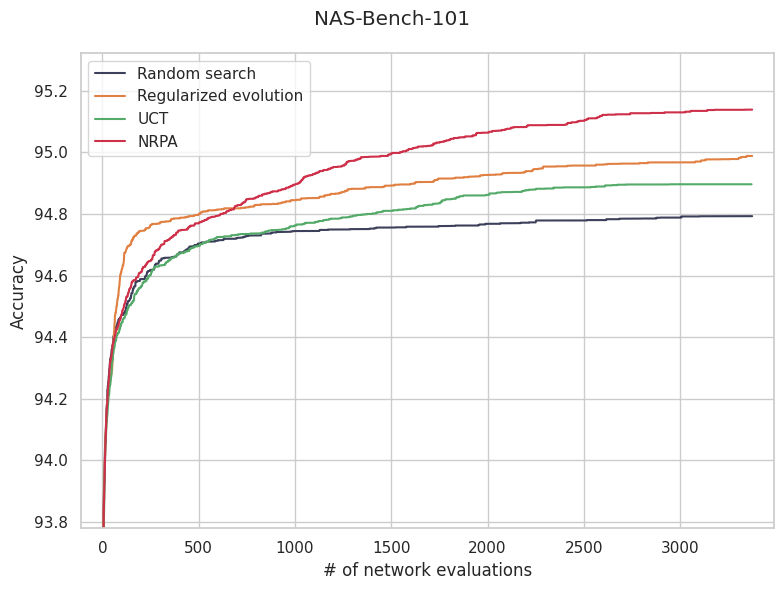

In [505]:
f, ax = plt.subplots(1,1,figsize=(8,6))
for name, results in methods.items():
    ax.plot(np.mean(results, axis=0)[:datasets["nas_bench_101"]["n_iter"]]*100, label=name)
plt.ylim([min_value, ymax]); plt.xlim(-datasets["nas_bench_101"]["n_iter"]/30, datasets["nas_bench_101"]["n_iter"]+(datasets["nas_bench_101"]["n_iter"]/30))
ax.set_ylabel("Accuracy"); ax.set_xlabel("# of network evaluations")
f.suptitle("NAS-Bench-101")
ax.legend()
plt.tight_layout()
plt.savefig("figures/NASBench-101.png")

0.9518229365348816


In [426]:
(11*max_value - min_value) / 10

0.9540052301883698

### NATS-Bench

In [232]:
from nats_bench_dataset import NATSBenchMCTS
from nats_bench_dataset import NATSBenchNode
importlib.reload(NATSBenchMCTS)
importlib.reload(NATSBenchNode)
from nats_bench_dataset.NATSBenchMCTS import *
from nats_bench_dataset.NATSBenchNode import *

Current best reward : 71.3400:  49%|███▍   | 2000/4096 [00:23<00:06, 339.94it/s]

In [93]:
nats_bench_df = pd.read_csv("CSV/nats-c100-mydemo.csv")

In [ ]:
methods = {"Random search": [], 
           "Regularized evolution": [], 
           "UCT": [], 
           # "RAVE": [],
           # "GRAVE": [],
           "NRPA": []}

params = datasets["nats_bench"]
params["nrpa_alpha"] = 1
params["nrpa_level"] = 3

for i in range(params["n_runs"]):
    print(f"RUN N° {i+1}/{params['n_runs']}")
    
    rs = RandomSearchNats(api=params["api"],
                          df=nats_bench_df,
                          max_iter=params["n_iter"])
    
    re = RegularizedEvolutionNATS(api=params["api"],
                                  df=nats_bench_df,
                                  population_size=50,
                                  cycles=params["n_iter"],
                                  sample_size=25)
    
    root_node_uct = NATSBenchSizeNode()
    uct = NATSBenchUCT(root_node_uct,
                       api=params["api"],
                       df=nats_bench_df,
                       params_path="/userdata/T0259728/projets/nas_ntk/utils/params.json",
                       disable_tqdm=False)
    uct.n_iter = params["n_iter"]//(5*uct.playouts_per_selection)

    # root_node_rave = NATSBenchSizeAMAFNode()
    # rave = NATSBenchRAVE(root_node_rave,
    #                      api=params["api"],
    #                      params_path="/userdata/T0259728/projets/nas_ntk/utils/params.json",
    #                      disable_tqdm=False)
    # rave.n_iter = params["n_iter"]//(5*rave.playouts_per_selection)
    
    # root_node_grave = NATSBenchSizeAMAFNode()
    # grave = NATSBenchGRAVE(root_node_grave,
    #                      api=params["api"],
    #                      params_path="/userdata/T0259728/projets/nas_ntk/utils/params.json",
    #                      disable_tqdm=False)
    # grave.n_iter = params["n_iter"]//(5*grave.playouts_per_selection)
    
    root_node_nrpa = NATSBenchSizeNestedNode(sequence=[])
    nrpa = NATSBenchNRPA(root_node_nrpa,
                         params["nrpa_level"],
                         api=params["api"],
                         df=nats_bench_df,
                         params_path="/userdata/T0259728/projets/nas_ntk/utils/params.json",
                         disable_tqdm=False)
    nrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nrpa.alpha = params["nrpa_alpha"]
    nrpa.softmax_temp=2
    
    rs.run()
    re.run()
    _, _, _ = uct.main_loop()
    # _, _, _ = rave.main_loop()
    # _, _, _ = grave.main_loop()
    _, _, _ = nrpa.main_loop()

    
    methods["Random search"].append(rs.best_accs[1:])
    methods["Regularized evolution"].append(re.best_accs[1:])
    methods["UCT"].append(uct.best_reward)
    # methods["RAVE"].append(rave.best_reward)
    # methods["GRAVE"].append(grave.best_reward)
    methods["NRPA"].append(nrpa.best_reward)

    with open("runs/NATSBench.json", "w+") as f:
        json.dump(methods, f)

In [488]:
with open("runs/NATSBench.json", "r") as f:
    methods = json.load(f)

In [493]:
max_value = max([np.max(e) for e in methods.values()])
min_value = min(np.quantile(e, 0.005) for e in methods.values())
ymax = (11*max_value - min_value) / 10

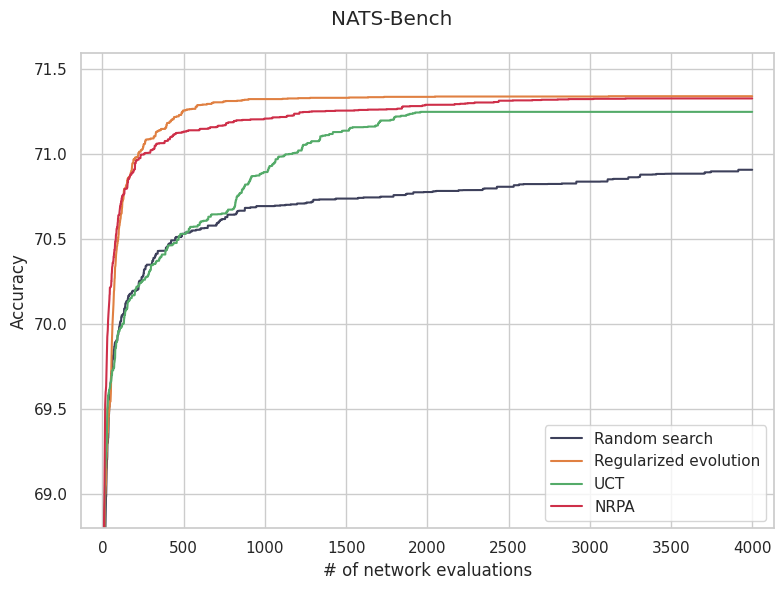

In [494]:
f, ax = plt.subplots(1,1,figsize=(8,6))
for name, results in methods.items():
    ax.plot(np.mean(results, axis=0)[:datasets["nats_bench"]["n_iter"]], label=name)
plt.ylim([min_value, ymax]); plt.xlim(-datasets["nats_bench"]["n_iter"]/30, datasets["nats_bench"]["n_iter"]+(datasets["nats_bench"]["n_iter"]/30))
ax.set_ylabel("Accuracy"); ax.set_xlabel("# of network evaluations")
f.suptitle("NATS-Bench")
ax.legend()
plt.tight_layout()
ax.legend()
plt.savefig("figures/NATSBench.png")

### NAS-Bench-201

In [175]:
nas_bench_201_df = pd.read_csv("GOOD_CSV/Cifar100-NB201.csv")

In [150]:
from nas_bench_201 import NASBench201MCTS
importlib.reload(NASBench201MCTS)
from nas_bench_201.NASBench201MCTS import *

In [151]:
methods = {"Random search": [], 
           "Regularized evolution": [], 
           "UCT": [], 
           # "RAVE": [],
           # "GRAVE": [],
           "NRPA": []}

params = datasets["nas_bench_201"]


for i in range(params["n_runs"]):
    print(f"RUN N° {i+1}/{params['n_runs']}")
    
    rs = RandomSearchNB201(api=params["api"],
                           df=nas_bench_201_df,
                           max_iter=params["n_iter"])
    
    re =  RegularizedEvolutionNB201(api=params["api"],
                                    df=nas_bench_201_df,
                                    population_size=50,
                                    cycles=params["n_iter"],
                                    sample_size=25)
    
    root_node_uct = NASBench201Node(state=NASBench201Cell(4))
    uct = NASBench201UCT(root_node_uct,
                         api=params["api"],
                         params_path="/userdata/T0259728/projets/nas_ntk/utils/params.json",
                         disable_tqdm=False,
                         df=nas_bench_201_df)
    uct.n_iter = params["n_iter"]//(6*uct.playouts_per_selection)

    # root_node_rave = NASBench201AMAFNode(state=NASBench201Cell(4))
    # rave = NASBench201RAVE(root_node_rave,
    #                        api=params["api"],
    #                        params_path="/userdata/T0259728/projets/nas_ntk/utils/params.json",
    #                        disable_tqdm=False, 
    #                        df=nas_bench_201_df)
    # rave.n_iter = params["n_iter"]//(6*rave.playouts_per_selection)
    
    # root_node_grave = NASBench201AMAFNode(state=NASBench201Cell(4))
    # grave = NASBench201GRAVE(root_node_grave,
    #                        api=params["api"],
    #                        params_path="/userdata/T0259728/projets/nas_ntk/utils/params.json",
    #                        disable_tqdm=False, 
    #                        df=nas_bench_201_df)
    # grave.n_iter = params["n_iter"]//(6*grave.playouts_per_selection)
    
    root_node_nrpa = NASBench201NestedNode(state=NASBench201Cell(4), sequence=[])
    nrpa = NASBench201NRPA(root_node_nrpa,
                           params["nrpa_level"],
                           api=params["api"],
                           params_path="/userdata/T0259728/projets/nas_ntk/utils/params.json",
                           disable_tqdm=False, 
                           df=nas_bench_201_df)
    nrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nrpa.alpha = params["nrpa_alpha"]
    
    rs.run()
    re.run()
    _, _, _ = uct.main_loop()
    # _, _, _ = rave.main_loop()
    # _, _, _ = grave.main_loop()
    _, _, _ = nrpa.main_loop()

    
    methods["Random search"].append(rs.best_accs[1:])
    methods["Regularized evolution"].append(re.best_accs[1:])
    methods["UCT"].append(uct.best_reward)
    # methods["RAVE"].append(rave.best_reward)
    # methods["GRAVE"].append(grave.best_reward)
    methods["NRPA"].append(nrpa.best_reward)
    
    with open("runs/NASBench201.json", "w+") as f:
        json.dump(methods, f)

RUN N° 1/100



100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2007.35it/s]


Best accuracy: 0.729599999206543
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474



  0%|▏                                          | 1/333 [00:00<00:48,  6.88it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)

100%|████████████████████████████████████████| 333/333 [00:01<00:00, 172.33it/s]


(3, 0, 'nor_conv_3x3')



100%|████████████████████████████████████████| 333/333 [00:01<00:00, 229.04it/s]


(1, 0, 'nor_conv_3x3')



100%|████████████████████████████████████████| 333/333 [00:01<00:00, 272.02it/s]


(3, 2, 'nor_conv_3x3')



100%|████████████████████████████████████████| 333/333 [00:01<00:00, 329.50it/s]


(2, 1, 'nor_conv_3x3')



100%|████████████████████████████████████████| 333/333 [00:00<00:00, 501.62it/s]


(2, 0, 'nor_conv_3x3')



100%|████████████████████████████████████████| 333/333 [00:00<00:00, 804.82it/s]


(3, 1, 'nor_conv_1x1')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:09<00:00, 243.75it/s]


Sequence is [(2, 1, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (2, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 2/100



100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2241.74it/s]


Best accuracy: 0.7301999998779297
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474



  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)

100%|████████████████████████████████████████| 333/333 [00:01<00:00, 208.40it/s]


(3, 2, 'nor_conv_3x3')



100%|████████████████████████████████████████| 333/333 [00:01<00:00, 235.24it/s]


(2, 0, 'nor_conv_3x3')



100%|████████████████████████████████████████| 333/333 [00:01<00:00, 277.43it/s]


(1, 0, 'nor_conv_3x3')



100%|████████████████████████████████████████| 333/333 [00:00<00:00, 333.45it/s]


(3, 0, 'skip_connect')



100%|████████████████████████████████████████| 333/333 [00:00<00:00, 510.21it/s]


(3, 1, 'nor_conv_3x3')



100%|████████████████████████████████████████| 333/333 [00:00<00:00, 960.29it/s]


(2, 1, 'nor_conv_3x3')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:08<00:00, 269.28it/s]


Sequence is [(3, 2, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (2, 0, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 3/100



100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2002.74it/s]


Best accuracy: 0.7294666666666666
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474



  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)

100%|████████████████████████████████████████| 333/333 [00:01<00:00, 203.18it/s]


(2, 0, 'nor_conv_3x3')



100%|████████████████████████████████████████| 333/333 [00:01<00:00, 226.67it/s]


(3, 2, 'nor_conv_3x3')



100%|████████████████████████████████████████| 333/333 [00:01<00:00, 265.75it/s]


(1, 0, 'nor_conv_1x1')



100%|████████████████████████████████████████| 333/333 [00:01<00:00, 301.90it/s]


(3, 0, 'skip_connect')



100%|████████████████████████████████████████| 333/333 [00:00<00:00, 437.70it/s]


(3, 1, 'nor_conv_3x3')



100%|████████████████████████████████████████| 333/333 [00:00<00:00, 839.31it/s]


(2, 1, 'nor_conv_1x1')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:08<00:00, 267.47it/s]


Sequence is [(2, 1, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (3, 2, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 4/100



100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2285.72it/s]


Best accuracy: 0.7274666660563152
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474



  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)

100%|████████████████████████████████████████| 333/333 [00:01<00:00, 203.27it/s]


(3, 0, 'nor_conv_3x3')



100%|████████████████████████████████████████| 333/333 [00:01<00:00, 226.47it/s]


(3, 2, 'nor_conv_3x3')



100%|████████████████████████████████████████| 333/333 [00:01<00:00, 280.98it/s]


(2, 0, 'nor_conv_3x3')



100%|████████████████████████████████████████| 333/333 [00:00<00:00, 333.34it/s]


(1, 0, 'nor_conv_3x3')



100%|████████████████████████████████████████| 333/333 [00:00<00:00, 467.03it/s]


(2, 1, 'nor_conv_3x3')



100%|████████████████████████████████████████| 333/333 [00:00<00:00, 979.59it/s]


(3, 1, 'nor_conv_1x1')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:08<00:00, 274.22it/s]


Sequence is [(2, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (3, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 5/100



100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2285.03it/s]


Best accuracy: 0.7308666667073568
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474



  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)

100%|████████████████████████████████████████| 333/333 [00:01<00:00, 202.79it/s]


(3, 0, 'nor_conv_3x3')



100%|████████████████████████████████████████| 333/333 [00:01<00:00, 227.98it/s]


(1, 0, 'nor_conv_3x3')



100%|████████████████████████████████████████| 333/333 [00:01<00:00, 269.10it/s]


(3, 2, 'nor_conv_3x3')



100%|████████████████████████████████████████| 333/333 [00:00<00:00, 336.33it/s]


(2, 0, 'nor_conv_3x3')



100%|████████████████████████████████████████| 333/333 [00:00<00:00, 517.51it/s]


(2, 1, 'nor_conv_3x3')



100%|████████████████████████████████████████| 333/333 [00:00<00:00, 971.66it/s]


(3, 1, 'nor_conv_1x1')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:07<00:00, 275.43it/s]


Sequence is [(1, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (3, 1, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 6/100



100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2341.80it/s]


Best accuracy: 0.734933333577474
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474



  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)

100%|████████████████████████████████████████| 333/333 [00:01<00:00, 189.89it/s]


(3, 0, 'nor_conv_3x3')



100%|████████████████████████████████████████| 333/333 [00:01<00:00, 197.08it/s]


(1, 0, 'nor_conv_1x1')



100%|████████████████████████████████████████| 333/333 [00:01<00:00, 234.42it/s]


(3, 2, 'nor_conv_1x1')



100%|████████████████████████████████████████| 333/333 [00:01<00:00, 317.28it/s]


(2, 1, 'nor_conv_3x3')



100%|████████████████████████████████████████| 333/333 [00:00<00:00, 500.82it/s]


(2, 0, 'nor_conv_3x3')



100%|████████████████████████████████████████| 333/333 [00:00<00:00, 977.23it/s]


(3, 1, 'nor_conv_3x3')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:08<00:00, 267.48it/s]


Sequence is [(1, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (3, 1, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 7/100



100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2352.01it/s]


Best accuracy: 0.7285999995727539
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474



  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)

100%|████████████████████████████████████████| 333/333 [00:01<00:00, 215.98it/s]


(3, 2, 'nor_conv_3x3')



100%|████████████████████████████████████████| 333/333 [00:01<00:00, 232.64it/s]


(1, 0, 'nor_conv_3x3')



100%|████████████████████████████████████████| 333/333 [00:01<00:00, 266.84it/s]


(3, 0, 'skip_connect')



100%|████████████████████████████████████████| 333/333 [00:00<00:00, 342.42it/s]


(2, 0, 'nor_conv_3x3')



100%|████████████████████████████████████████| 333/333 [00:00<00:00, 524.30it/s]


(3, 1, 'nor_conv_1x1')



100%|████████████████████████████████████████| 333/333 [00:00<00:00, 966.50it/s]


(2, 1, 'nor_conv_3x3')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:08<00:00, 266.36it/s]


Sequence is [(2, 0, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (2, 1, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 8/100



100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2265.60it/s]


Best accuracy: 0.7308666667073568
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474



  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)

100%|████████████████████████████████████████| 333/333 [00:01<00:00, 187.62it/s]


(1, 0, 'nor_conv_3x3')



100%|████████████████████████████████████████| 333/333 [00:01<00:00, 231.27it/s]


(3, 0, 'skip_connect')



Current best reward : 71.0200:  36%|▋ | 1473/4096 [26:28:03<47:07:53, 64.69s/it]

100%|█████████████████████████████████████████| 333/333 [00:19<00:00, 17.33it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 342.92it/s]


(3, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 519.20it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 948.71it/s]


(2, 1, 'nor_conv_3x3')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:08<00:00, 263.32it/s]


Sequence is [(3, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 0, 'skip_connect')] with score 0.734933333577474
RUN N° 9/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2341.94it/s]


Best accuracy: 0.7312666664632163
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 218.48it/s]


(3, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 235.11it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 287.71it/s]


(3, 0, 'skip_connect')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 323.25it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 533.59it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 990.35it/s]


(2, 1, 'nor_conv_3x3')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:08<00:00, 271.50it/s]


Sequence is [(2, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (3, 1, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 10/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2201.20it/s]


Best accuracy: 0.7301999998779297
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 203.56it/s]


(3, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 242.94it/s]


(1, 0, 'nor_conv_1x1')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 277.24it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 356.20it/s]


(3, 0, 'skip_connect')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 535.91it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 961.81it/s]


(2, 1, 'nor_conv_1x1')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:08<00:00, 273.63it/s]


Sequence is [(3, 1, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (1, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 11/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2236.31it/s]


Best accuracy: 0.7301999998779297
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 199.38it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 235.98it/s]


(3, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 281.74it/s]


(3, 0, 'skip_connect')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 328.29it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 494.84it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 951.50it/s]


(2, 1, 'nor_conv_3x3')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:08<00:00, 272.17it/s]


Sequence is [(2, 0, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (2, 1, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 12/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2296.55it/s]


Best accuracy: 0.7216999995117187
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 215.56it/s]


(3, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 198.98it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 239.54it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 295.88it/s]


(2, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 469.60it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 887.45it/s]


(3, 1, 'nor_conv_1x1')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:07<00:00, 277.85it/s]


Sequence is [(3, 2, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (1, 0, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 13/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2235.55it/s]


Best accuracy: 0.7330666659749348
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 201.90it/s]


(3, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 231.57it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 253.81it/s]


(3, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 342.14it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 517.31it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 945.42it/s]


(2, 1, 'none')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:08<00:00, 273.79it/s]


Sequence is [(3, 0, 'skip_connect'), (2, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 14/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2283.43it/s]


Best accuracy: 0.7239999986572266
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 179.25it/s]


(3, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 203.70it/s]


(3, 2, 'nor_conv_1x1')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 278.01it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 348.68it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 522.39it/s]


(3, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 989.18it/s]


(2, 1, 'nor_conv_3x3')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:07<00:00, 280.43it/s]


Sequence is [(3, 2, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (3, 0, 'skip_connect')] with score 0.734933333577474
RUN N° 15/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2292.24it/s]


Best accuracy: 0.7294666666666666
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 180.96it/s]


(3, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 195.38it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 242.72it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 300.08it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 461.73it/s]


(2, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 872.29it/s]


(3, 1, 'nor_conv_1x1')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:07<00:00, 279.30it/s]


Sequence is [(2, 1, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (2, 0, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 16/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2385.81it/s]


Best accuracy: 0.7301999998779297
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 200.77it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 241.32it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 278.02it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 355.43it/s]


(3, 0, 'skip_connect')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 535.06it/s]


(3, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 949.63it/s]


(2, 1, 'nor_conv_3x3')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:07<00:00, 282.80it/s]


Sequence is [(2, 1, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (2, 0, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 17/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2330.28it/s]


Best accuracy: 0.7229999994506836
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 211.74it/s]


(3, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 240.28it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 284.50it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 350.47it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 508.12it/s]


(2, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 966.83it/s]


(3, 1, 'nor_conv_1x1')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:08<00:00, 272.87it/s]


Sequence is [(3, 2, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (3, 1, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 18/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2360.00it/s]


Best accuracy: 0.729599999206543
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 209.19it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 234.04it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 277.82it/s]


(2, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 335.51it/s]


(3, 0, 'skip_connect')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 525.78it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 972.62it/s]


(3, 1, 'nor_conv_3x3')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:07<00:00, 275.53it/s]


Sequence is [(3, 0, 'skip_connect'), (1, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 19/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2186.93it/s]


Best accuracy: 0.7298000002441407
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 198.97it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 233.44it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 267.83it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 334.22it/s]


(3, 0, 'skip_connect')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 513.81it/s]


(3, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 931.02it/s]


(2, 1, 'nor_conv_3x3')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:08<00:00, 270.27it/s]


Sequence is [(3, 1, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (3, 2, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 20/100


100%|██████████████████████████████████████| 2000/2000 [00:05<00:00, 392.26it/s]


Best accuracy: 0.7312666664632163
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 206.21it/s]


(3, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 242.83it/s]


(3, 2, 'nor_conv_1x1')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 275.97it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 323.65it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 510.78it/s]


(3, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 944.74it/s]


(2, 1, 'nor_conv_3x3')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:08<00:00, 266.32it/s]


Sequence is [(3, 2, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (1, 0, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 21/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2345.46it/s]


Best accuracy: 0.7312666664632163
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 205.13it/s]


(3, 2, 'nor_conv_1x1')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 221.24it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 268.63it/s]


(3, 0, 'skip_connect')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 313.85it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 472.72it/s]


(3, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 939.23it/s]


(2, 1, 'skip_connect')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:08<00:00, 270.51it/s]


Sequence is [(3, 1, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 0, 'skip_connect')] with score 0.734933333577474
RUN N° 22/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2181.15it/s]


Best accuracy: 0.7312666664632163
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:02<00:00, 164.82it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 186.35it/s]


(3, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 262.78it/s]


(3, 0, 'skip_connect')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 327.95it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 502.11it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 899.25it/s]


(2, 1, 'nor_conv_3x3')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:08<00:00, 274.59it/s]


Sequence is [(3, 1, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (3, 2, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 23/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2360.87it/s]


Best accuracy: 0.7277333328857423
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 212.68it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 232.90it/s]


(3, 2, 'nor_conv_1x1')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 280.47it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 324.32it/s]


(3, 0, 'skip_connect')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 516.66it/s]


(3, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 957.18it/s]


(2, 1, 'skip_connect')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:08<00:00, 273.83it/s]


Sequence is [(2, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (3, 2, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 24/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2230.03it/s]


Best accuracy: 0.726399999226888
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 201.00it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 230.31it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 272.05it/s]


(3, 0, 'skip_connect')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 341.82it/s]


(3, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 491.15it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 925.16it/s]


(2, 1, 'nor_conv_3x3')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:07<00:00, 280.35it/s]


Sequence is [(1, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (3, 0, 'skip_connect')] with score 0.734933333577474
RUN N° 25/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2346.50it/s]


Best accuracy: 0.7330666659749348
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 200.53it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 233.24it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 279.01it/s]


(3, 0, 'nor_conv_1x1')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 338.23it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 509.93it/s]


(2, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 956.06it/s]


(3, 1, 'skip_connect')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:07<00:00, 279.12it/s]


Sequence is [(3, 1, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 0, 'skip_connect')] with score 0.734933333577474
RUN N° 26/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2414.93it/s]


Best accuracy: 0.7312666664632163
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 200.08it/s]


(1, 0, 'nor_conv_1x1')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 237.63it/s]


(3, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 288.73it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 336.54it/s]


(2, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 535.12it/s]


(2, 0, 'nor_conv_1x1')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 983.73it/s]


(3, 1, 'skip_connect')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:08<00:00, 271.75it/s]


Sequence is [(3, 2, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (3, 0, 'skip_connect')] with score 0.734933333577474
RUN N° 27/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2218.78it/s]


Best accuracy: 0.729599999206543
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 199.27it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 230.13it/s]


(3, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 270.67it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 344.63it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 535.73it/s]


(2, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 941.65it/s]


(3, 1, 'nor_conv_1x1')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:07<00:00, 276.32it/s]


Sequence is [(1, 0, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (2, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 28/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2415.15it/s]


Best accuracy: 0.7312666664632163
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 211.17it/s]


(3, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 235.73it/s]


(2, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 284.07it/s]


(3, 2, 'nor_conv_1x1')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 350.99it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 519.98it/s]


(3, 1, 'nor_conv_1x1')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 992.40it/s]


(2, 0, 'nor_conv_1x1')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:07<00:00, 287.63it/s]


Sequence is [(2, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (3, 2, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 29/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2373.29it/s]


Best accuracy: 0.7259333336181641
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 203.11it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 241.73it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 282.34it/s]


(3, 0, 'skip_connect')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 340.66it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 541.13it/s]


(3, 1, 'nor_conv_1x1')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 992.27it/s]


(2, 1, 'nor_conv_3x3')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:07<00:00, 279.96it/s]


Sequence is [(3, 2, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (3, 1, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 30/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2196.32it/s]


Best accuracy: 0.7277333328857423
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 206.61it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 226.00it/s]


(2, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 277.52it/s]


(3, 0, 'skip_connect')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 345.08it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 529.03it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 961.96it/s]


(3, 1, 'nor_conv_3x3')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:07<00:00, 279.26it/s]


Sequence is [(3, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (2, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 31/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2361.55it/s]


Best accuracy: 0.734933333577474
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 207.78it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 212.02it/s]


(3, 2, 'nor_conv_3x3')


100%|█████████████████████████████████████████| 333/333 [00:05<00:00, 63.50it/s]


(3, 0, 'skip_connect')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 342.31it/s]


(3, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 540.03it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 986.92it/s]


(2, 1, 'nor_conv_3x3')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:07<00:00, 277.37it/s]


Sequence is [(3, 2, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (3, 0, 'skip_connect')] with score 0.734933333577474
RUN N° 32/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2358.46it/s]


Best accuracy: 0.724799999633789
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 212.90it/s]


(3, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 243.57it/s]


(3, 2, 'nor_conv_1x1')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 281.05it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 350.62it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 534.03it/s]


(3, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 970.38it/s]


(2, 1, 'nor_conv_3x3')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:07<00:00, 285.88it/s]


Sequence is [(3, 0, 'skip_connect'), (1, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 33/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2416.58it/s]


Best accuracy: 0.7294666666666666
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 210.78it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 241.43it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 284.68it/s]


(2, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 341.61it/s]


(3, 0, 'skip_connect')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 497.13it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 903.26it/s]


(3, 1, 'nor_conv_3x3')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:07<00:00, 283.15it/s]


Sequence is [(2, 0, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (2, 1, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 34/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2440.04it/s]


Best accuracy: 0.729599999206543
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 217.27it/s]


(1, 0, 'nor_conv_1x1')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 241.32it/s]


(3, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 290.01it/s]


(3, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 345.60it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 551.58it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 995.86it/s]


(2, 1, 'nor_conv_3x3')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:07<00:00, 284.36it/s]


Sequence is [(2, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (3, 2, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 35/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2408.39it/s]


Best accuracy: 0.729599999206543
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 213.69it/s]


(3, 2, 'nor_conv_1x1')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 225.70it/s]


(3, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 265.16it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 323.50it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 509.71it/s]


(3, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 929.71it/s]


(2, 1, 'nor_conv_3x3')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:08<00:00, 273.32it/s]


Sequence is [(3, 2, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (2, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 36/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2364.65it/s]


Best accuracy: 0.7308666667073568
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 207.00it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 230.36it/s]


(3, 0, 'nor_conv_1x1')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 276.11it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 336.09it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 524.10it/s]


(2, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 954.03it/s]


(3, 1, 'skip_connect')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:08<00:00, 269.79it/s]


Sequence is [(2, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (3, 0, 'skip_connect')] with score 0.734933333577474
RUN N° 37/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2277.76it/s]


Best accuracy: 0.7273999994710286
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 190.70it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 240.07it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 268.63it/s]


(3, 0, 'skip_connect')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 343.27it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 518.30it/s]


(3, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 930.86it/s]


(2, 1, 'nor_conv_3x3')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:08<00:00, 266.40it/s]


Sequence is [(3, 0, 'skip_connect'), (1, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 38/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2388.06it/s]


Best accuracy: 0.7277333328857423
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 210.90it/s]


(3, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 238.74it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 273.94it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 336.47it/s]


(3, 0, 'skip_connect')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 506.08it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 810.27it/s]


(2, 1, 'nor_conv_3x3')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:07<00:00, 275.74it/s]


Sequence is [(3, 0, 'skip_connect'), (1, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 57/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2188.70it/s]


Best accuracy: 0.7273999994710286
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 173.91it/s]


(1, 0, 'nor_conv_1x1')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 241.30it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 276.82it/s]


(3, 0, 'skip_connect')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 347.77it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 489.99it/s]


(3, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 917.30it/s]


(2, 1, 'nor_conv_1x1')


Current best reward : 0.7349:  29%|██▋      | 645/2197 [00:02<00:04, 322.60it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Current best reward : 0.7349: 100%|████████| 2197/2197 [00:07<00:00, 282.04it/s]


Sequence is [(3, 1, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (3, 0, 'skip_connect')] with score 0.734933333577474
RUN N° 64/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2358.23it/s]


Best accuracy: 0.7277333328857423
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 211.38it/s]


(3, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 249.87it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 276.92it/s]


(3, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 349.19it/s]


(2, 0, 'skip_connect')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 547.79it/s]


(3, 2, 'skip_connect')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 974.13it/s]


(2, 1, 'nor_conv_3x3')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:07<00:00, 276.20it/s]


Sequence is [(3, 1, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (1, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 65/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2330.97it/s]


Best accuracy: 0.7298000002441407
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 210.83it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 242.14it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 285.52it/s]


(3, 0, 'skip_connect')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 345.06it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 544.02it/s]


(3, 1, 'nor_conv_1x1')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 986.75it/s]


(2, 1, 'nor_conv_3x3')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:07<00:00, 288.85it/s]


Sequence is [(2, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 0, 'skip_connect')] with score 0.734933333577474
RUN N° 66/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2310.30it/s]


Best accuracy: 0.7330666659749348
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 214.96it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 244.01it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 282.17it/s]


(3, 0, 'skip_connect')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 350.95it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 517.77it/s]


(3, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 956.07it/s]


(2, 1, 'nor_conv_3x3')


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2197.96it/s]


Best accuracy: 0.7251333330078126
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 210.57it/s]


(3, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 238.00it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 280.17it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 335.62it/s]


(2, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 511.26it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 949.49it/s]


(3, 1, 'nor_conv_1x1')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:12<00:00, 178.77it/s]


Sequence is [(1, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (3, 0, 'skip_connect')] with score 0.734933333577474
RUN N° 70/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2226.23it/s]


Best accuracy: 0.7294666666666666
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 194.75it/s]


(3, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 231.77it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 267.50it/s]


(2, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 344.26it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 488.63it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 865.45it/s]


(3, 1, 'nor_conv_1x1')


Current best reward : 0.7349:  24%|██▏      | 527/2197 [00:01<00:05, 312.00it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|████████████████████████████████████████| 333/333 [00:01<00:00, 213.34it/s]


(3, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 239.19it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 229.37it/s]


(2, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 297.00it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 457.67it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 877.97it/s]


(3, 1, 'nor_conv_1x1')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:08<00:00, 273.96it/s]


Sequence is [(1, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (3, 0, 'skip_connect')] with score 0.734933333577474
RUN N° 85/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2353.68it/s]


Best accuracy: 0.7301999998779297
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 193.92it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 240.03it/s]


(2, 0, 'nor_conv_1x1')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 290.91it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 354.14it/s]


(3, 0, 'skip_connect')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 546.38it/s]


(3, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 939.34it/s]


(2, 1, 'nor_conv_3x3')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:08<00:00, 266.00it/s]


Sequence is [(3, 1, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (3, 2, 'nor_conv_3x3'), (2, 0, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 86/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2270.72it/s]


Best accuracy: 0.7301999998779297
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 175.49it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 200.66it/s]


(3, 0, 'skip_connect')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 234.50it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 285.94it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 455.79it/s]


(3, 1, 'nor_conv_1x1')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 878.86it/s]


(2, 1, 'nor_conv_3x3')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:08<00:00, 273.43it/s]


Sequence is [(3, 1, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (2, 0, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 87/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2340.58it/s]


Best accuracy: 0.7251999990844726
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 174.19it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 334.95it/s]


(3, 0, 'skip_connect')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 510.15it/s]


(3, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 969.80it/s]


(2, 1, 'nor_conv_3x3')


Current best reward : 0.7349: 100%|████████| 2197/2197 [00:08<00:00, 274.19it/s]


Sequence is [(2, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 0, 'skip_connect'), (2, 0, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3')] with score 0.734933333577474
RUN N° 90/100


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2190.27it/s]


Best accuracy: 0.7277333328857423
1000: Best acc : 0.734933333577474
Best accuracy: 0.734933333577474


  0%|                                                   | 0/333 [00:00<?, ?it/s]/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/T0259728/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████| 333/333 [00:01<00:00, 208.81it/s]


(3, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 239.84it/s]


(3, 2, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:01<00:00, 277.53it/s]


(2, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 347.71it/s]


(1, 0, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 516.46it/s]


(2, 1, 'nor_conv_3x3')


100%|████████████████████████████████████████| 333/333 [00:00<00:00, 922.08it/s]


(3, 1, 'nor_conv_1x1')


Current best reward : 0.7349:  27%|██▍      | 594/2197 [00:01<00:04, 338.77it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [483]:
with open("runs/NASBench201.json", "r") as f:
    methods = json.load(f)

In [486]:
max_value = max([np.max(e) for e in methods.values()])*100
min_value = min(np.quantile(e, 0.005) for e in methods.values())*100
ymax = (11*max_value - min_value) / 10

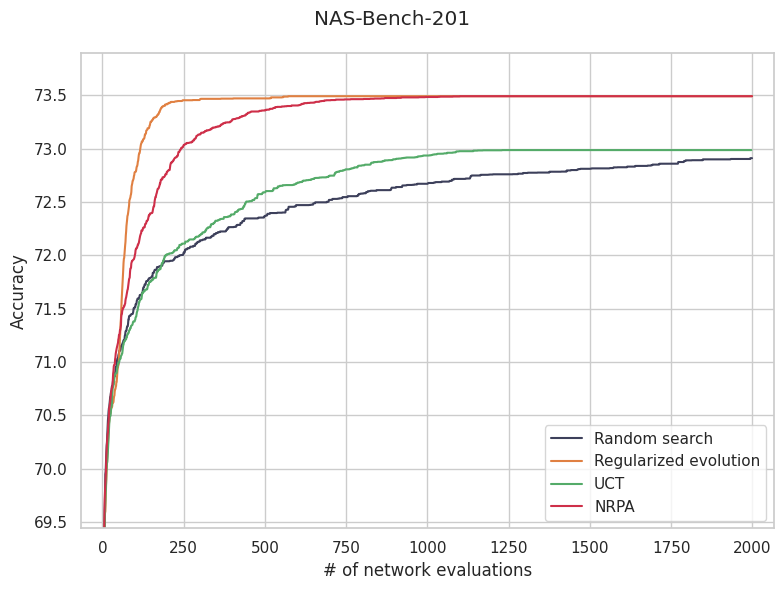

In [487]:
f, ax = plt.subplots(1,1,figsize=(8,6))
for name, results in methods.items():
    ax.plot(np.mean(results, axis=0)[:datasets["nas_bench_201"]["n_iter"]]*100, label=name)
plt.ylim([min_value, ymax]); plt.xlim(-datasets["nas_bench_201"]["n_iter"]/30, datasets["nas_bench_201"]["n_iter"]+(datasets["nas_bench_201"]["n_iter"]/30))
ax.set_ylabel("Accuracy"); ax.set_xlabel("# of network evaluations")
f.suptitle("NAS-Bench-201")
ax.legend()
plt.tight_layout()
ax.legend()
plt.savefig("figures/NAS-Bench-201.png")

### NAS-Bench-301

In [ ]:
from nas_bench_301 import NASBench301MCTS 
importlib.reload(NASBench301MCTS)
from nas_bench_301.NASBench301MCTS import *

In [ ]:
with open("runs/NASBench301.json", "r") as f:
    methods = json.load(f)

In [ ]:
# methods = {
#            "Random search": [], 
#            "Regularized evolution": [], 
#            "UCT": [], 
#            "RAVE": [],
#            "GRAVE": [],
#            "NRPA": []
#            }

params = datasets["nas_bench_301"]
# params["n_iter"]=1000

for i in range(params["n_runs"]):
    print(f"RUN N° {i+1}/{params['n_runs']}")
    
    rs = RandomSearchNB301(max_iter=params["n_iter"])
    
    re =  RegularizedEvolutionNB301(population_size=50,
                                    cycles=params["n_iter"],
                                    sample_size=25)
    
    root_node_uct = DARTSNode((DARTSCell(), DARTSCell()))
    uct = NASBench301UCT(root_node_uct,
                         performance_model=params["api"],
                         params_path="/userdata/T0259728/projets/nas_ntk/utils/params.json",
                         disable_tqdm=False)
    uct.n_iter = params["n_iter"]//(16*uct.playouts_per_selection)

    # root_node_rave = DARTSAMAFNode((DARTSCell(), DARTSCell()))
    # rave = NASBench301RAVE(root_node_rave,
    #                        performance_model=params["api"],
    #                        params_path="/userdata/T0259728/projets/nas_ntk/utils/params.json",
    #                        disable_tqdm=False)
    # rave.n_iter = params["n_iter"]//(16*rave.playouts_per_selection)
    
    # root_node_grave = DARTSAMAFNode((DARTSCell(), DARTSCell()))
    # grave = NASBench301GRAVE(root_node_grave,
    #                         performance_model=params["api"],
    #                         params_path="/userdata/T0259728/projets/nas_ntk/utils/params.json",
    #                         disable_tqdm=False)
    # grave.n_iter = params["n_iter"]//(16*grave.playouts_per_selection)
    
    root_node_nrpa = DARTSNestedNode((DARTSCell(), DARTSCell()), sequence=[])
    nrpa = NASBench301NRPA(root_node_nrpa,
                           params["nrpa_level"],
                           params_path="/userdata/T0259728/projets/nas_ntk/utils/params.json",
                           disable_tqdm=False)
    nrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nrpa.alpha = params["nrpa_alpha"]
    
    rs.run()
    re.run()
    _, _, _ = uct.main_loop()
    # _, _, _ = rave.main_loop()
    # _, _, _ = grave.main_loop()
    _, _, _ = nrpa.main_loop()

    
    methods["Random search"].append(rs.best_accs[1:])
    methods["Regularized evolution"].append(re.best_accs[1:])
    methods["UCT"].append(uct.best_reward)
    # methods["RAVE"].append(rave.best_reward)
    # methods["GRAVE"].append(grave.best_reward)
    methods["NRPA"].append(nrpa.best_reward)

    with open("runs/NASBench301.json", "w+") as f:
        json.dump(methods, f)

In [506]:
with open("runs/NASBench301.json", "r") as f:
    methods = json.load(f)

In [507]:
max_value = max([np.max(e) for e in methods.values()])
min_value = min(np.quantile(e, 0.005) for e in methods.values())
ymax = (11*max_value - min_value) /10

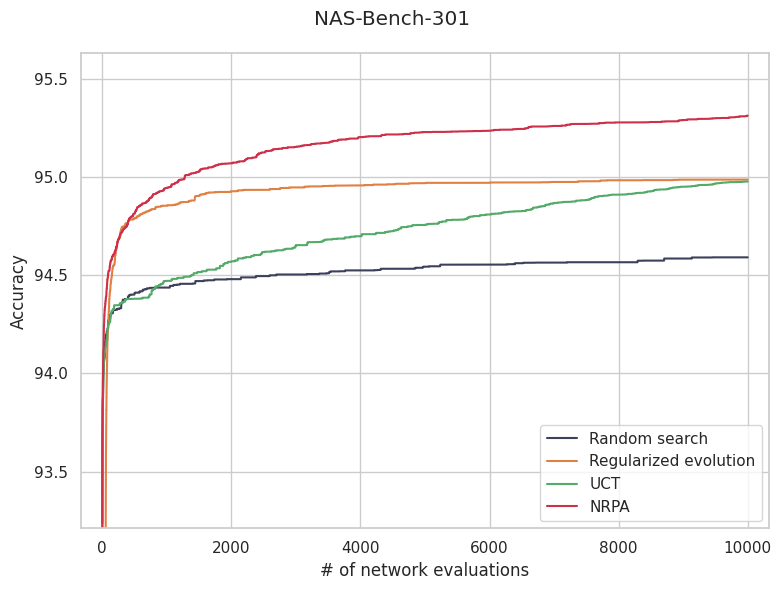

In [508]:
f, ax = plt.subplots(1,1,figsize=(8,6))
for name, results in methods.items():
    ax.plot(np.mean(results, axis=0)[:datasets["nas_bench_301"]["n_iter"]], label=name)
plt.ylim([min_value, ymax]); plt.xlim(-datasets["nas_bench_301"]["n_iter"]/30, datasets["nas_bench_301"]["n_iter"]+(datasets["nas_bench_301"]["n_iter"]/30))
ax.set_ylabel("Accuracy"); ax.set_xlabel("# of network evaluations")
f.suptitle("NAS-Bench-301")
ax.legend()
plt.tight_layout()
ax.legend()
plt.savefig("figures/NAS-Bench-301.png")

## Evaluating the training-free metrics

### NAS-Bench-101

In [371]:
metrics = pd.read_csv("GOOD_CSV/Cifar10-NB101.csv")
metrics = metrics[metrics["score_synflow"] > 0]

In [109]:
metrics.head()

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,module_adjacency,module_operations,trainable_parameters,halfway_training_time,halfway_train_accuracy,...,final_training_time,final_train_accuracy,final_validation_accuracy,final_test_accuracy,score,score_ntk_mean,score_ntk_sum,score_nasi,score_naswot,score_synflow
2,2,117,117,117,117,[[0 1 1 0 0 0 0]\n [0 0 1 0 0 0 0]\n [0 0 0 1 ...,"['input', 'conv1x1-bn-relu', 'conv3x3-bn-relu'...",4250634,599.914998,0.504774,...,1201.298299,0.999800,0.915064,0.910023,0.0,59.038147,590.381470,499.254211,2.830155,15.814413
3,3,192,192,192,192,[[0 1 0 0 0 0 0]\n [0 0 1 0 1 0 1]\n [0 0 0 1 ...,"['input', 'conv3x3-bn-relu', 'maxpool3x3', 'co...",2597679,542.618673,0.836205,...,1085.543335,0.999866,0.917568,0.909989,0.0,13.341440,133.414398,189.956787,2.688814,28.599196
9,9,214,214,214,214,[[0 1 0 0 1 1 0]\n [0 0 1 0 0 0 0]\n [0 0 0 1 ...,"['input', 'conv1x1-bn-relu', 'conv3x3-bn-relu'...",3063859,679.492004,0.733908,...,1359.116333,1.000000,0.919304,0.914964,0.0,20.537369,205.373688,243.327362,2.721876,29.215946
11,11,246,246,246,246,[[0 1 0 1 0 0 0]\n [0 0 1 0 1 0 0]\n [0 0 0 0 ...,"['input', 'conv1x1-bn-relu', 'maxpool3x3', 'ma...",21384074,1735.024373,0.666032,...,3470.143311,0.999933,0.913695,0.905816,0.0,6.183372,61.833725,270.980469,2.889234,17.595247
12,12,255,255,255,255,[[0 1 1 1 0 0 0]\n [0 0 1 0 0 0 0]\n [0 0 0 1 ...,"['input', 'conv1x1-bn-relu', 'conv3x3-bn-relu'...",24332938,1588.389364,0.278546,...,3179.504395,0.999933,0.904581,0.900274,0.0,412.677734,4126.777344,1729.772705,2.990491,17.121056


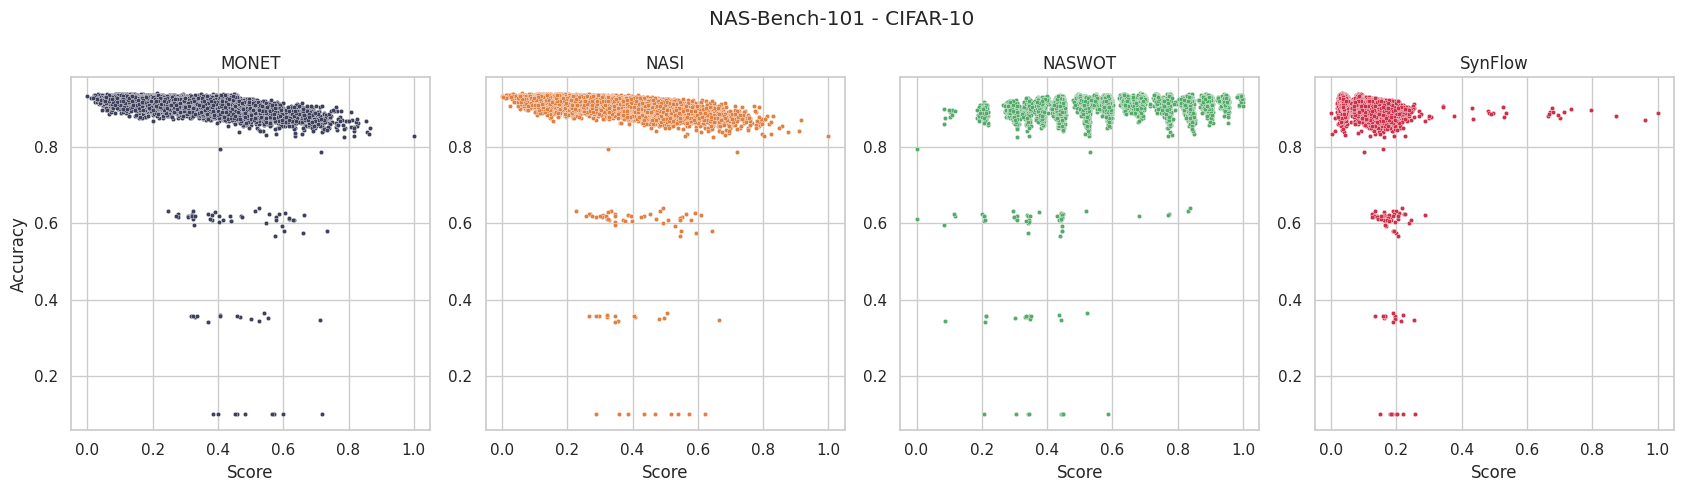

In [377]:
f, ax = plt.subplots(1,4, figsize=(17,5))
sns.scatterplot(x=normalize(metrics["score_ntk_mean"], True), y=metrics["final_test_accuracy"], s=10, ax=ax[0], alpha=1, color=sns.color_palette()[0])
sns.scatterplot(x=normalize(metrics["score_nasi"], True), y=metrics["final_test_accuracy"], s=10, ax=ax[1], alpha=1, color=sns.color_palette()[1])
sns.scatterplot(x=normalize(metrics["score_naswot"], False), y=metrics["final_test_accuracy"], s=10, ax=ax[2], alpha=1, color=sns.color_palette()[2])
sns.scatterplot(x=normalize(metrics["score_synflow"], True), y=metrics["final_test_accuracy"], s=10, ax=ax[3], alpha=1, color=sns.color_palette()[3])
ax[0].set_title("MONET")
ax[1].set_title("NASI")
ax[2].set_title("NASWOT")
ax[3].set_title("SynFlow")
ax[0].set_ylabel("Accuracy"); ax[1].set_ylabel(""), ax[2].set_ylabel(""), ax[3].set_ylabel("")
ax[0].set_xlabel("Score"); ax[1].set_xlabel("Score"), ax[2].set_xlabel("Score"), ax[3].set_xlabel("Score")
title = "NAS-Bench-101 - CIFAR-10"
f.suptitle(title)
plt.tight_layout()
plt.savefig(f"figures/{title}.png")
plt.show()

Calculating the Spearman $\rho$ coefficient

In [373]:
rho_monet = spearmanr(metrics["score_ntk_mean"], metrics["final_test_accuracy"])
print(r"Spearman rho coefficient for MONET : " , f"{rho_monet.statistic:.3f}")

rho_nasi = spearmanr(metrics["score_nasi"], metrics["final_test_accuracy"])
print(r"Spearman rho coefficient for NASI : " , f"{rho_nasi.statistic:.3f}")

rho_naswot = spearmanr(metrics["score_naswot"], metrics["final_test_accuracy"])
print(r"Spearman rho coefficient for NASWOT : " , f"{rho_naswot.statistic:.3f}")

rho_synflow = spearmanr(metrics["score_synflow"], metrics["final_test_accuracy"])
print(r"Spearman rho coefficient for SynFlow : " , f"{rho_synflow.statistic:.3f}")

Spearman rho coefficient for MONET :  -0.595
Spearman rho coefficient for NASI :  -0.559
Spearman rho coefficient for NASWOT :  0.291
Spearman rho coefficient for SynFlow :  -0.400


### NAS-Bench-201

Plotting on CIFAR-10

In [368]:
metrics = pd.read_csv("GOOD_CSV/Cifar10-NB201.csv")
metrics = metrics[metrics["score"] > 0]

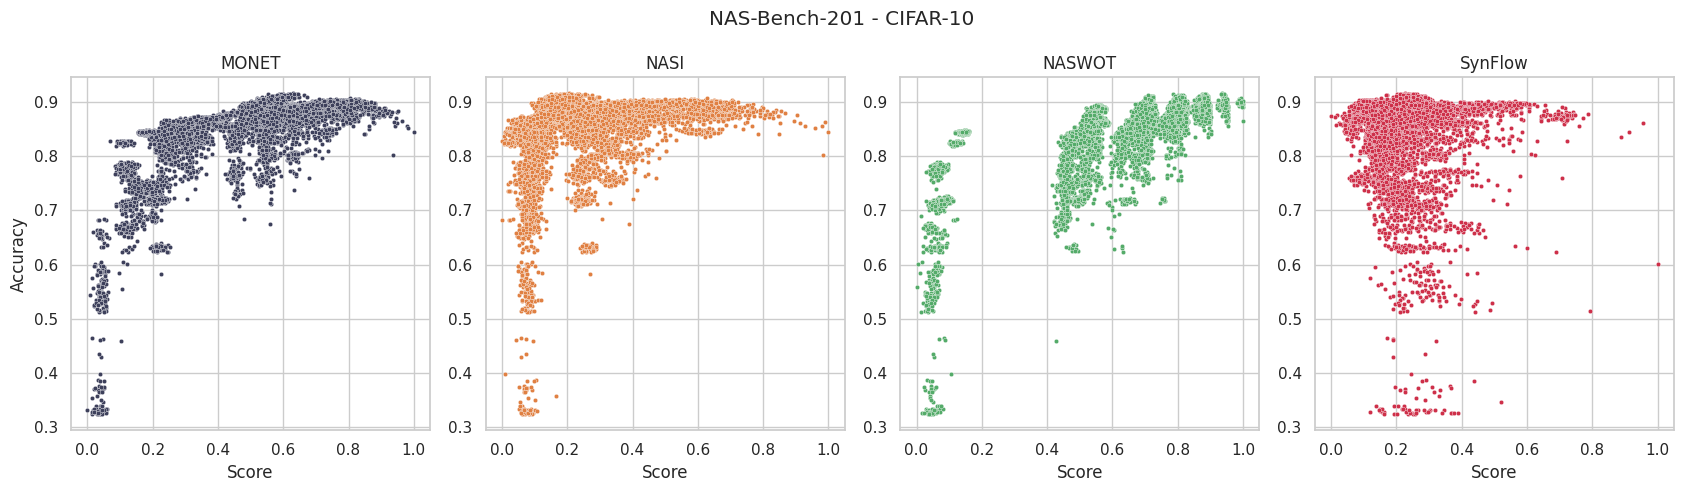

In [369]:
f, ax = plt.subplots(1,4, figsize=(17,5))
sns.scatterplot(x=normalize(metrics["score"], True), y=metrics["accuracy"], s=10, ax=ax[0], alpha=1, color=sns.color_palette()[0])
sns.scatterplot(x=normalize(metrics["score_nasi"], True), y=metrics["accuracy"], s=10, ax=ax[1], alpha=1, color=sns.color_palette()[1])
sns.scatterplot(x=normalize(metrics["score_naswot"], False), y=metrics["accuracy"], s=10, ax=ax[2], alpha=1, color=sns.color_palette()[2])
sns.scatterplot(x=normalize(metrics["score_synflow"], False), y=metrics["accuracy"], s=10, ax=ax[3], alpha=1, color=sns.color_palette()[3])
ax[0].set_title("MONET")
ax[1].set_title("NASI")
ax[2].set_title("NASWOT")
ax[3].set_title("SynFlow")
ax[0].set_ylabel("Accuracy"); ax[1].set_ylabel(""), ax[2].set_ylabel(""), ax[3].set_ylabel("")
ax[0].set_xlabel("Score"); ax[1].set_xlabel("Score"), ax[2].set_xlabel("Score"), ax[3].set_xlabel("Score")
title = "NAS-Bench-201 - CIFAR-10"
f.suptitle(title)
plt.tight_layout()
plt.savefig(f"figures/{title}.png")
plt.show()

Calculating the Spearman $\rho$ coefficient

In [122]:
rho_monet = spearmanr(metrics["score"], metrics["accuracy"])
print(r"Spearman rho coefficient for MONET : " , f"{rho_monet.statistic:.3f}")

rho_nasi = spearmanr(metrics["score_nasi"], metrics["accuracy"])
print(r"Spearman rho coefficient for NASI : " , f"{rho_nasi.statistic:.3f}")

rho_naswot = spearmanr(metrics["score_naswot"], metrics["accuracy"])
print(r"Spearman rho coefficient for NASWOT : " , f"{rho_naswot.statistic:.3f}")

rho_synflow = spearmanr(metrics["score_synflow"], metrics["accuracy"])
print(r"Spearman rho coefficient for SynFlow : " , f"{rho_synflow.statistic:.3f}")

Spearman rho coefficient for MONET :  0.714
Spearman rho coefficient for NASI :  0.469
Spearman rho coefficient for NASWOT :  0.760
Spearman rho coefficient for SynFlow :  0.064


Plotting on CIFAR-100

In [366]:
metrics = pd.read_csv("GOOD_CSV/Cifar100-NB201.csv")
metrics = metrics[metrics["score"] > 0]

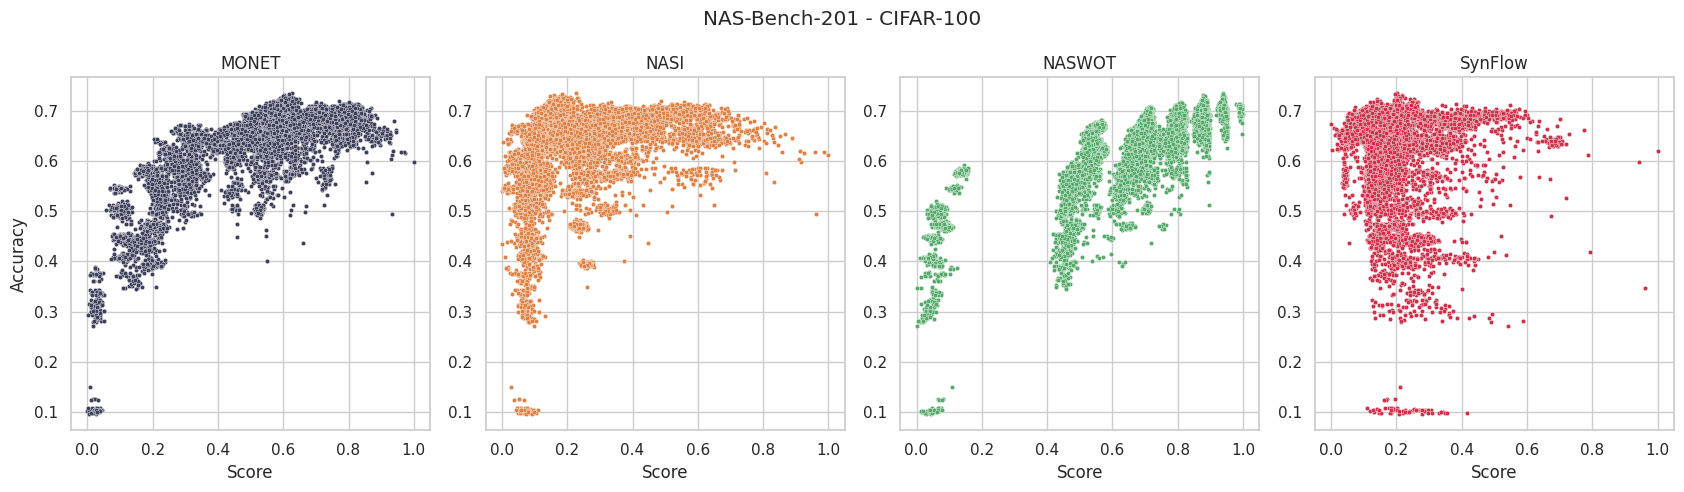

In [367]:
f, ax = plt.subplots(1,4, figsize=(17,5))
sns.scatterplot(x=normalize(metrics["score"], True), y=metrics["accuracy"], s=10, ax=ax[0], alpha=1, color=sns.color_palette()[0])
sns.scatterplot(x=normalize(metrics["score_nasi"], True), y=metrics["accuracy"], s=10, ax=ax[1], alpha=1, color=sns.color_palette()[1])
sns.scatterplot(x=normalize(metrics["score_naswot"], False), y=metrics["accuracy"], s=10, ax=ax[2], alpha=1, color=sns.color_palette()[2])
sns.scatterplot(x=normalize(metrics["score_synflow"], False), y=metrics["accuracy"], s=10, ax=ax[3], alpha=1, color=sns.color_palette()[3])
ax[0].set_title("MONET")
ax[1].set_title("NASI")
ax[2].set_title("NASWOT")
ax[3].set_title("SynFlow")
ax[0].set_ylabel("Accuracy"); ax[1].set_ylabel(""), ax[2].set_ylabel(""), ax[3].set_ylabel("")
ax[0].set_xlabel("Score"); ax[1].set_xlabel("Score"), ax[2].set_xlabel("Score"), ax[3].set_xlabel("Score")
title = "NAS-Bench-201 - CIFAR-100"
f.suptitle(title)
plt.tight_layout()
plt.savefig(f"figures/{title}.png")
plt.show()

Calculating the Spearman $\rho$ coefficient

In [125]:
rho_monet = spearmanr(metrics["score"], metrics["accuracy"])
print(r"Spearman rho coefficient for MONET : " , f"{rho_monet.statistic:.3f}")

rho_nasi = spearmanr(metrics["score_nasi"], metrics["accuracy"])
print(r"Spearman rho coefficient for NASI : " , f"{rho_nasi.statistic:.3f}")

rho_naswot = spearmanr(metrics["score_naswot"], metrics["accuracy"])
print(r"Spearman rho coefficient for NASWOT : " , f"{rho_naswot.statistic:.3f}")

rho_synflow = spearmanr(metrics["score_synflow"], metrics["accuracy"])
print(r"Spearman rho coefficient for SynFlow : " , f"{rho_synflow.statistic:.3f}")

Spearman rho coefficient for MONET :  0.741
Spearman rho coefficient for NASI :  0.501
Spearman rho coefficient for NASWOT :  0.795
Spearman rho coefficient for SynFlow :  0.014


Plotting on ImageNet

In [55]:
metrics = pd.read_csv("GOOD_CSV/ImageNet-NB201.csv")
metrics = metrics[metrics["score"] > 0]

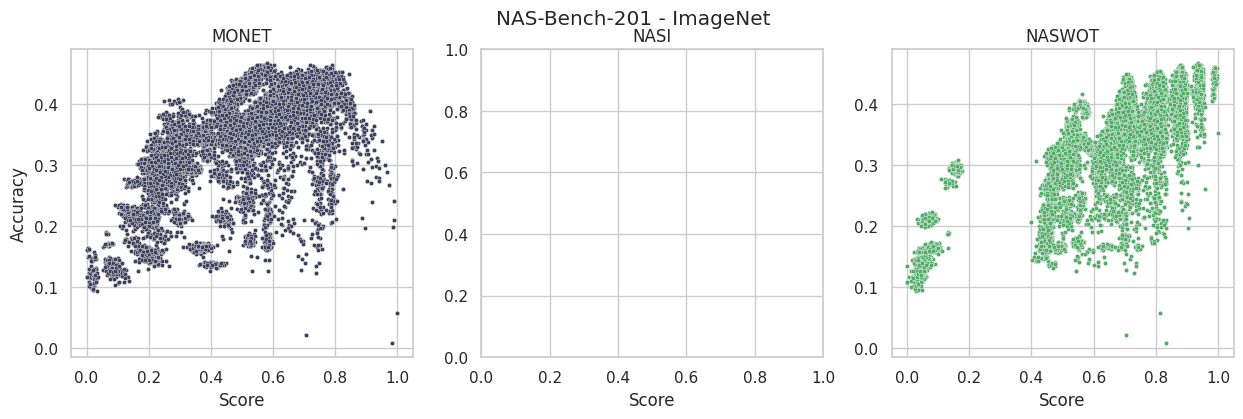

In [56]:
f, ax = plt.subplots(1,3, figsize=(15,4))
sns.scatterplot(x=normalize(metrics["score"], True), y=metrics["accuracy"], s=10, ax=ax[0], alpha=1, color=sns.color_palette()[0])
# sns.scatterplot(x=normalize(metrics["score_nasi"], True), y=metrics["accuracy"], s=10, ax=ax[1], alpha=1, color=sns.color_palette()[1])
sns.scatterplot(x=normalize(metrics["score_naswot"], False), y=metrics["accuracy"], s=10, ax=ax[2], alpha=1, color=sns.color_palette()[2])
ax[0].set_title("MONET")
ax[1].set_title("NASI")
ax[2].set_title("NASWOT")
ax[0].set_ylabel("Accuracy"); ax[1].set_ylabel(""), ax[2].set_ylabel("")
ax[0].set_xlabel("Score"); ax[1].set_xlabel("Score"), ax[2].set_xlabel("Score")
title = "NAS-Bench-201 - ImageNet"
f.suptitle(title)
plt.savefig(f"figures/{title}.png")
plt.show()

Calculating the Spearman $\rho$ coefficient

In [57]:
rho_monet = spearmanr(metrics["score"], metrics["accuracy"])
print(r"Spearman rho coefficient for MONET : " , f"{rho_monet.statistic:.3f}")

# rho_nasi = spearmanr(normalize(metrics["score_nasi"], True), metrics["accuracy"])
# print(r"Spearman rho coefficient for NASI : " , f"{rho_nasi.statistic:.3f}")

rho_naswot = spearmanr(metrics["score_naswot"], metrics["accuracy"])
print(r"Spearman rho coefficient for NASWOT : " , f"{rho_naswot.statistic:.3f}")

Spearman rho coefficient for MONET :  0.621
Spearman rho coefficient for NASWOT :  0.759


### NATS-Bench

Plotting on CIFAR-10

In [364]:
metrics = pd.read_csv("GOOD_CSV/Cifar10-NATS.csv")
metrics = metrics[metrics["score"] > 0]

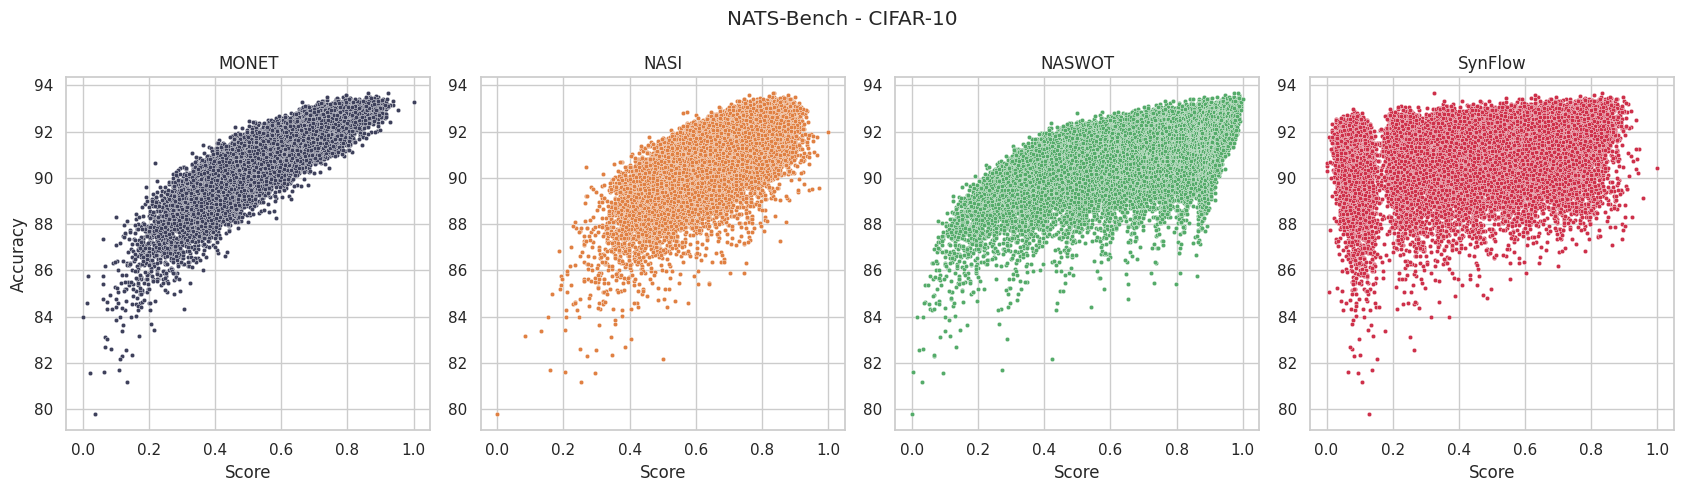

In [365]:
f, ax = plt.subplots(1,4, figsize=(17,5))
sns.scatterplot(x=normalize(metrics["score"], True), y=metrics["accuracy"], s=10, ax=ax[0], alpha=1, color=sns.color_palette()[0])
sns.scatterplot(x=normalize(metrics["score_nasi"], True), y=metrics["accuracy"], s=10, ax=ax[1], alpha=1, color=sns.color_palette()[1])
sns.scatterplot(x=normalize(metrics["score_naswot"], False), y=metrics["accuracy"], s=10, ax=ax[2], alpha=1, color=sns.color_palette()[2])
sns.scatterplot(x=normalize(metrics["score_synflow"], False), y=metrics["accuracy"], s=10, ax=ax[3], alpha=1, color=sns.color_palette()[3])
ax[0].set_title("MONET")
ax[1].set_title("NASI")
ax[2].set_title("NASWOT")
ax[3].set_title("SynFlow")
ax[0].set_ylabel("Accuracy"); ax[1].set_ylabel(""), ax[2].set_ylabel(""), ax[3].set_ylabel("")
ax[0].set_xlabel("Score"); ax[1].set_xlabel("Score"), ax[2].set_xlabel("Score"), ax[3].set_xlabel("Score")
title = "NATS-Bench - CIFAR-10"
f.suptitle(title)
plt.tight_layout()
plt.savefig(f"figures/{title}.png")
plt.show()

Calculating the Spearman $\rho$ coefficient

In [128]:
rho_monet = spearmanr(metrics["score"], metrics["accuracy"])
print(r"Spearman rho coefficient for MONET : " , f"{rho_monet.statistic:.3f}")

rho_nasi = spearmanr(metrics["score_nasi"], metrics["accuracy"])
print(r"Spearman rho coefficient for NASI : " , f"{rho_nasi.statistic:.3f}")

rho_naswot = spearmanr(metrics["score_naswot"], metrics["accuracy"])
print(r"Spearman rho coefficient for NASWOT : " , f"{rho_naswot.statistic:.3f}")

rho_synflow = spearmanr(metrics["score_synflow"], metrics["accuracy"])
print(r"Spearman rho coefficient for SynFlow : " , f"{rho_synflow.statistic:.3f}")

Spearman rho coefficient for MONET :  0.877
Spearman rho coefficient for NASI :  0.662
Spearman rho coefficient for NASWOT :  0.603
Spearman rho coefficient for SynFlow :  0.322


Plotting on CIFAR-100

In [351]:
metrics = pd.read_csv("GOOD_CSV/Cifar100-NATS.csv")
metrics = metrics[metrics["score"] > 0]

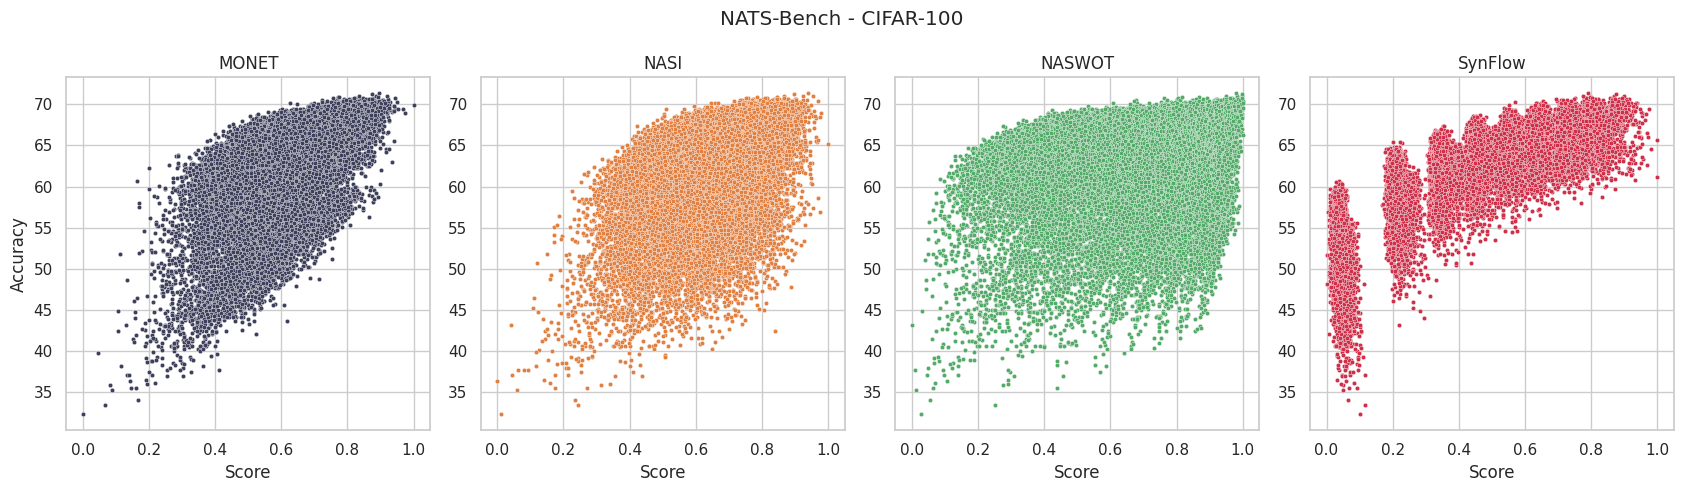

In [363]:
f, ax = plt.subplots(1,4, figsize=(17,5))
sns.scatterplot(x=normalize(metrics["score"], True), y=metrics["accuracy"], s=10, ax=ax[0], alpha=1, color=sns.color_palette()[0])
sns.scatterplot(x=normalize(metrics["score_nasi"], True), y=metrics["accuracy"], s=10, ax=ax[1], alpha=1, color=sns.color_palette()[1])
sns.scatterplot(x=normalize(metrics["score_naswot"], False), y=metrics["accuracy"], s=10, ax=ax[2], alpha=1, color=sns.color_palette()[2])
sns.scatterplot(x=normalize(metrics["score_synflow"], False), y=metrics["accuracy"], s=10, ax=ax[3], alpha=1, color=sns.color_palette()[3])
ax[0].set_title("MONET")
ax[1].set_title("NASI")
ax[2].set_title("NASWOT")
ax[3].set_title("SynFlow")
ax[0].set_ylabel("Accuracy"); ax[1].set_ylabel(""), ax[2].set_ylabel(""), ax[3].set_ylabel("")
ax[0].set_xlabel("Score"); ax[1].set_xlabel("Score"), ax[2].set_xlabel("Score"), ax[3].set_xlabel("Score")
title = "NATS-Bench - CIFAR-100"
f.suptitle(title)
plt.tight_layout()
plt.savefig(f"figures/{title}.png")
plt.show()

Calculating the Spearman $\rho$ coefficient

In [132]:
rho_monet = spearmanr(metrics["score"], metrics["accuracy"])
print(r"Spearman rho coefficient for MONET : " , f"{rho_monet.statistic:.3f}")

rho_nasi = spearmanr(metrics["score_nasi"], metrics["accuracy"])
print(r"Spearman rho coefficient for NASI : " , f"{rho_nasi.statistic:.3f}")

rho_naswot = spearmanr(metrics["score_naswot"], metrics["accuracy"])
print(r"Spearman rho coefficient for NASWOT : " , f"{rho_naswot.statistic:.3f}")

rho_synflow = spearmanr(metrics["score_synflow"], metrics["accuracy"])
print(r"Spearman rho coefficient for SynFlow : " , f"{rho_synflow.statistic:.3f}")

Spearman rho coefficient for MONET :  0.629
Spearman rho coefficient for NASI :  0.466
Spearman rho coefficient for NASWOT :  0.270
Spearman rho coefficient for SynFlow :  0.812


Plotting on ImageNet

In [64]:
metrics = pd.read_csv("GOOD_CSV/ImageNet-NATS.csv")
metrics = metrics[metrics["score"] > 0]

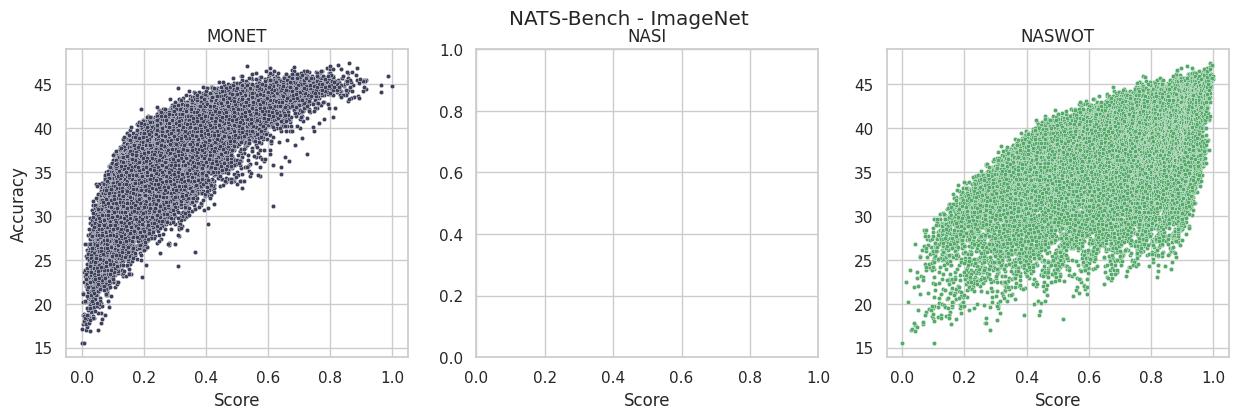

In [65]:
f, ax = plt.subplots(1,3, figsize=(15,4))
sns.scatterplot(x=normalize(metrics["score"], False), y=metrics["accuracy"], s=10, ax=ax[0], alpha=1, color=sns.color_palette()[0])
# sns.scatterplot(x=normalize(metrics["score_nasi"], True), y=metrics["accuracy"], s=10, ax=ax[1], alpha=1, color=sns.color_palette()[1])
sns.scatterplot(x=normalize(metrics["score_naswot"], False), y=metrics["accuracy"], s=10, ax=ax[2], alpha=1, color=sns.color_palette()[2])
ax[0].set_title("MONET")
ax[1].set_title("NASI")
ax[2].set_title("NASWOT")
ax[0].set_ylabel("Accuracy"); ax[1].set_ylabel(""), ax[2].set_ylabel("")
ax[0].set_xlabel("Score"); ax[1].set_xlabel("Score"), ax[2].set_xlabel("Score")
title = "NATS-Bench - ImageNet"
f.suptitle(title)
plt.savefig(f"figures/{title}.png")
plt.show()

Calculating the Spearman $\rho$ coefficient

In [68]:
rho_monet = spearmanr(metrics["score"], metrics["accuracy"])
print(r"Spearman rho coefficient for MONET : " , f"{rho_monet.statistic:.3f}")

# rho_nasi = spearmanr(normalize(metrics["score_nasi"], False), metrics["accuracy"])
# print(r"Spearman rho coefficient for NASI : " , f"{rho_nasi.statistic:.3f}")

rho_naswot = spearmanr(metrics["score_naswot"], metrics["accuracy"])
print(r"Spearman rho coefficient for NASWOT : " , f"{rho_naswot.statistic:.3f}")

Spearman rho coefficient for MONET :  0.847
Spearman rho coefficient for NASWOT :  0.569


### NAS-Bench-301

In [69]:
metrics = pd.read_csv("GOOD_CSV/Cifar10-NB301.csv")
metrics = metrics[metrics["score_ntk"] > 0]

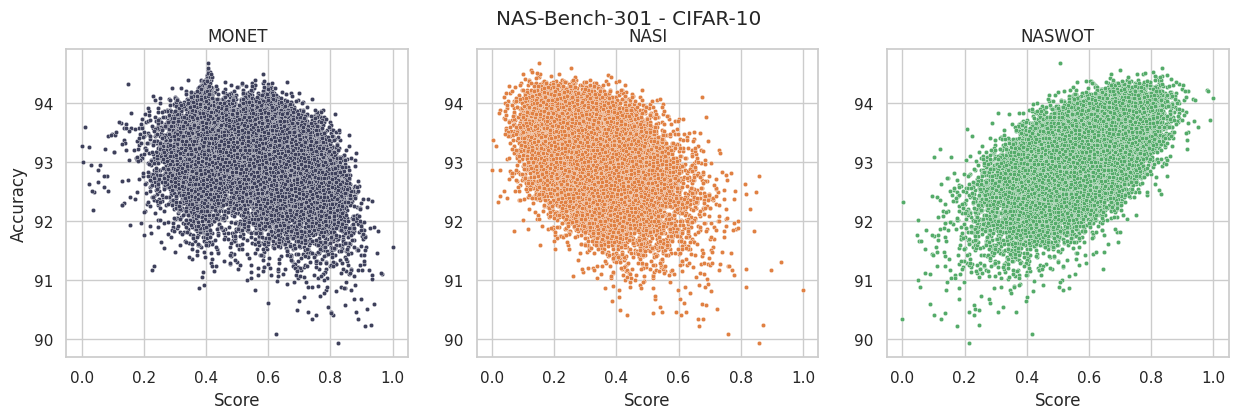

In [70]:
f, ax = plt.subplots(1,3, figsize=(15,4))
sns.scatterplot(x=normalize(metrics["score_ntk"], True), y=metrics["accuracy"], s=10, ax=ax[0], alpha=1, color=sns.color_palette()[0])
sns.scatterplot(x=normalize(metrics["score_nasi"], True), y=metrics["accuracy"], s=10, ax=ax[1], alpha=1, color=sns.color_palette()[1])
sns.scatterplot(x=normalize(metrics["score_naswot"], False), y=metrics["accuracy"], s=10, ax=ax[2], alpha=1, color=sns.color_palette()[2])
ax[0].set_title("MONET")
ax[1].set_title("NASI")
ax[2].set_title("NASWOT")
ax[0].set_ylabel("Accuracy"); ax[1].set_ylabel(""), ax[2].set_ylabel("")
ax[0].set_xlabel("Score"); ax[1].set_xlabel("Score"), ax[2].set_xlabel("Score")
title = "NAS-Bench-301 - CIFAR-10"
f.suptitle(title)
plt.savefig(f"figures/{title}.png")
plt.show()

Calculating the Spearman $\rho$ coefficient

In [71]:
rho_monet = spearmanr(metrics["score_ntk"], metrics["accuracy"])
print(r"Spearman rho coefficient for MONET : " , f"{rho_monet.statistic:.3f}")

rho_nasi = spearmanr(metrics["score_nasi"], metrics["accuracy"])
print(r"Spearman rho coefficient for NASI : " , f"{rho_nasi.statistic:.3f}")

rho_naswot = spearmanr(metrics["score_naswot"], metrics["accuracy"])
print(r"Spearman rho coefficient for NASWOT : " , f"{rho_naswot.statistic:.3f}")

Spearman rho coefficient for MONET :  -0.299
Spearman rho coefficient for NASI :  -0.395
Spearman rho coefficient for NASWOT :  0.571


## MONET : Combining **Mo**nte-Carlo with **Ne**ural **T**angent Kernel

### On NAS-Bench-201

In [176]:
from nas_bench_201 import NASBench201MCTS
importlib.reload(NASBench201MCTS)
from nas_bench_201.NASBench201MCTS import *

In [330]:
nas_bench_201_df = pd.read_csv("GOOD_CSV/Cifar10-NB201.csv")

In [331]:
params = datasets["nas_bench_201"]
datasets["nas_bench_201"]["n_runs"] = 100

In [332]:
params = datasets["nas_bench_201"]
accs_synflow_nb201 = []
ntks_synflow_nb201 = []
for i in range(params["n_runs"]):
    print(f"Run {i+1} / {params['n_runs']}")
    root_node_nrpa = NASBench201NestedNode(state=NASBench201Cell(4), sequence=[])
    nrpa = NASBench201NRPA(root_node_nrpa,
                           params["nrpa_level"],
                           api=params["api"],
                           params_path="/userdata/T0259728/projets/nas_ntk/utils/params.json",
                           disable_tqdm=False, 
                           df=nas_bench_201_df)
    nrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nrpa.alpha = params["nrpa_alpha"]
    nrpa.metric = "score_synflow"
    a, b, c = nrpa.main_loop()
    accs_synflow_nb201.append(nrpa.accuracies_tracker)
    ntks_synflow_nb201.append(nrpa.best_reward)

Run 1 / 100


Current best reward : 42.2245: 100%|███████| 2197/2197 [00:08<00:00, 261.59it/s]


Sequence is [(3, 1, 'none'), (3, 0, 'none'), (2, 0, 'none'), (2, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3')] with score 42.22452213618645
Run 2 / 100


Current best reward : 38.2355: 100%|███████| 2197/2197 [00:07<00:00, 274.95it/s]


Sequence is [(3, 2, 'avg_pool_3x3'), (3, 0, 'none'), (3, 1, 'avg_pool_3x3'), (2, 1, 'avg_pool_3x3'), (1, 0, 'avg_pool_3x3'), (2, 0, 'avg_pool_3x3')] with score 38.23550309450019
Run 3 / 100


Current best reward : 42.2245: 100%|███████| 2197/2197 [00:08<00:00, 271.34it/s]


Sequence is [(2, 0, 'none'), (2, 1, 'nor_conv_3x3'), (3, 1, 'none'), (1, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (3, 0, 'none')] with score 42.22452213618645
Run 4 / 100


Current best reward : 42.2245: 100%|███████| 2197/2197 [00:08<00:00, 268.94it/s]


Sequence is [(2, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 0, 'none'), (3, 1, 'none'), (2, 0, 'none'), (3, 2, 'nor_conv_3x3')] with score 42.22452213618645
Run 5 / 100


Current best reward : 42.2245: 100%|███████| 2197/2197 [00:08<00:00, 270.48it/s]


Sequence is [(3, 2, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 1, 'none'), (1, 0, 'nor_conv_3x3'), (2, 0, 'none'), (3, 0, 'none')] with score 42.22452213618645
Run 6 / 100


Current best reward : 42.2245: 100%|███████| 2197/2197 [00:07<00:00, 280.28it/s]


Sequence is [(2, 0, 'none'), (3, 2, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 0, 'none'), (1, 0, 'nor_conv_3x3'), (3, 1, 'none')] with score 42.22452213618645
Run 7 / 100


Current best reward : 38.0123: 100%|███████| 2197/2197 [00:07<00:00, 278.56it/s]


Sequence is [(3, 1, 'nor_conv_3x3'), (2, 0, 'none'), (1, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (2, 1, 'none'), (3, 0, 'none')] with score 38.01227870445976
Run 8 / 100


Current best reward : 45.0987: 100%|███████| 2197/2197 [00:08<00:00, 272.50it/s]


Sequence is [(2, 1, 'avg_pool_3x3'), (3, 2, 'avg_pool_3x3'), (3, 1, 'avg_pool_3x3'), (2, 0, 'none'), (3, 0, 'none'), (1, 0, 'avg_pool_3x3')] with score 45.09867207401935
Run 9 / 100


Current best reward : 42.2245: 100%|███████| 2197/2197 [00:08<00:00, 266.54it/s]


Sequence is [(1, 0, 'nor_conv_3x3'), (3, 0, 'none'), (2, 0, 'none'), (2, 1, 'nor_conv_3x3'), (3, 1, 'none'), (3, 2, 'nor_conv_3x3')] with score 42.22452213618645
Run 10 / 100


Current best reward : 42.2245: 100%|███████| 2197/2197 [00:08<00:00, 252.38it/s]


Sequence is [(1, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (2, 0, 'none'), (3, 0, 'none'), (3, 1, 'none')] with score 42.22452213618645
Run 11 / 100


Current best reward : 45.0987: 100%|███████| 2197/2197 [00:08<00:00, 272.52it/s]


Sequence is [(3, 0, 'none'), (2, 0, 'none'), (3, 1, 'avg_pool_3x3'), (2, 1, 'avg_pool_3x3'), (3, 2, 'avg_pool_3x3'), (1, 0, 'avg_pool_3x3')] with score 45.09867207401935
Run 12 / 100


Current best reward : 45.0987: 100%|███████| 2197/2197 [00:08<00:00, 271.88it/s]


Sequence is [(3, 2, 'avg_pool_3x3'), (1, 0, 'avg_pool_3x3'), (3, 1, 'avg_pool_3x3'), (2, 0, 'none'), (3, 0, 'none'), (2, 1, 'avg_pool_3x3')] with score 45.09867207401935
Run 13 / 100


Current best reward : 42.2245: 100%|███████| 2197/2197 [00:08<00:00, 269.90it/s]


Sequence is [(3, 2, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 1, 'none'), (2, 1, 'nor_conv_3x3'), (3, 0, 'none'), (2, 0, 'none')] with score 42.22452213618645
Run 14 / 100


Current best reward : 38.0123: 100%|███████| 2197/2197 [00:08<00:00, 257.45it/s]


Sequence is [(3, 2, 'nor_conv_3x3'), (2, 0, 'none'), (3, 1, 'nor_conv_3x3'), (2, 1, 'none'), (3, 0, 'none'), (1, 0, 'nor_conv_3x3')] with score 38.01227870445976
Run 15 / 100


Current best reward : 42.2245: 100%|███████| 2197/2197 [00:08<00:00, 270.37it/s]


Sequence is [(3, 2, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 1, 'none'), (1, 0, 'nor_conv_3x3'), (3, 0, 'none'), (2, 0, 'none')] with score 42.22452213618645
Run 16 / 100


Current best reward : 42.2245: 100%|███████| 2197/2197 [00:08<00:00, 251.71it/s]


Sequence is [(2, 0, 'none'), (1, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 1, 'none'), (3, 2, 'nor_conv_3x3'), (3, 0, 'none')] with score 42.22452213618645
Run 17 / 100


Current best reward : 42.2245: 100%|███████| 2197/2197 [00:08<00:00, 273.62it/s]


Sequence is [(2, 1, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (3, 0, 'none'), (3, 1, 'none'), (2, 0, 'none'), (1, 0, 'nor_conv_3x3')] with score 42.22452213618645
Run 18 / 100


Current best reward : 42.2245: 100%|███████| 2197/2197 [00:08<00:00, 267.13it/s]


Sequence is [(3, 0, 'none'), (2, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (2, 0, 'none'), (3, 1, 'none'), (3, 2, 'nor_conv_3x3')] with score 42.22452213618645
Run 19 / 100


Current best reward : 42.2245: 100%|███████| 2197/2197 [00:08<00:00, 269.49it/s]


Sequence is [(3, 1, 'none'), (2, 0, 'none'), (2, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (3, 0, 'none')] with score 42.22452213618645
Run 20 / 100


Current best reward : 42.2245: 100%|███████| 2197/2197 [00:07<00:00, 286.94it/s]


Sequence is [(3, 1, 'none'), (3, 2, 'nor_conv_3x3'), (3, 0, 'none'), (1, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (2, 0, 'none')] with score 42.22452213618645
Run 21 / 100


Current best reward : 45.0987: 100%|███████| 2197/2197 [00:07<00:00, 277.04it/s]


Sequence is [(3, 1, 'avg_pool_3x3'), (3, 0, 'none'), (2, 1, 'avg_pool_3x3'), (3, 2, 'avg_pool_3x3'), (2, 0, 'none'), (1, 0, 'avg_pool_3x3')] with score 45.09867207401935
Run 22 / 100


Current best reward : 45.0987: 100%|███████| 2197/2197 [00:07<00:00, 279.91it/s]


Sequence is [(3, 1, 'avg_pool_3x3'), (3, 2, 'avg_pool_3x3'), (2, 1, 'avg_pool_3x3'), (1, 0, 'avg_pool_3x3'), (2, 0, 'none'), (3, 0, 'none')] with score 45.09867207401935
Run 23 / 100


Current best reward : 42.2245: 100%|███████| 2197/2197 [00:07<00:00, 278.95it/s]


Sequence is [(2, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 0, 'none'), (2, 0, 'none'), (3, 2, 'nor_conv_3x3'), (3, 1, 'none')] with score 42.22452213618645
Run 24 / 100


Current best reward : 42.2245: 100%|███████| 2197/2197 [00:07<00:00, 288.19it/s]


Sequence is [(2, 0, 'none'), (3, 2, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 1, 'none'), (3, 0, 'none'), (2, 1, 'nor_conv_3x3')] with score 42.22452213618645
Run 25 / 100


Current best reward : 42.2245: 100%|███████| 2197/2197 [00:07<00:00, 281.99it/s]


Sequence is [(2, 1, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (2, 0, 'none'), (3, 1, 'none'), (1, 0, 'nor_conv_3x3'), (3, 0, 'none')] with score 42.22452213618645
Run 26 / 100


Current best reward : 42.2245: 100%|███████| 2197/2197 [00:07<00:00, 279.36it/s]


Sequence is [(3, 0, 'none'), (3, 1, 'none'), (2, 1, 'nor_conv_3x3'), (2, 0, 'none'), (3, 2, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3')] with score 42.22452213618645
Run 27 / 100


Current best reward : 43.6011: 100%|███████| 2197/2197 [00:08<00:00, 273.89it/s]


Sequence is [(3, 1, 'none'), (3, 0, 'none'), (1, 0, 'nor_conv_1x1'), (3, 2, 'nor_conv_1x1'), (2, 1, 'nor_conv_3x3'), (2, 0, 'none')] with score 43.60112201164429
Run 28 / 100


Current best reward : 42.2245: 100%|███████| 2197/2197 [00:07<00:00, 276.95it/s]


Sequence is [(3, 2, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (2, 0, 'none'), (3, 0, 'none'), (3, 1, 'none')] with score 42.22452213618645
Run 29 / 100


Current best reward : 45.0987: 100%|███████| 2197/2197 [00:07<00:00, 287.45it/s]


Sequence is [(2, 1, 'avg_pool_3x3'), (3, 0, 'none'), (2, 0, 'none'), (3, 1, 'avg_pool_3x3'), (3, 2, 'avg_pool_3x3'), (1, 0, 'avg_pool_3x3')] with score 45.09867207401935
Run 30 / 100


Current best reward : 42.2245: 100%|███████| 2197/2197 [00:07<00:00, 286.96it/s]


Sequence is [(1, 0, 'nor_conv_3x3'), (3, 1, 'none'), (2, 1, 'nor_conv_3x3'), (2, 0, 'none'), (3, 0, 'none'), (3, 2, 'nor_conv_3x3')] with score 42.22452213618645
Run 31 / 100


Current best reward : 42.2245: 100%|███████| 2197/2197 [00:07<00:00, 276.38it/s]


Sequence is [(1, 0, 'nor_conv_3x3'), (2, 0, 'none'), (3, 2, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 1, 'none'), (3, 0, 'none')] with score 42.22452213618645
Run 60 / 100


Current best reward : 36.4405:  45%|███▋    | 998/2197 [00:03<00:03, 336.96it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Current best reward : 42.2245: 100%|███████| 2197/2197 [00:07<00:00, 285.22it/s]


Sequence is [(1, 0, 'nor_conv_3x3'), (3, 1, 'none'), (2, 1, 'nor_conv_3x3'), (3, 0, 'none'), (3, 2, 'nor_conv_3x3'), (2, 0, 'none')] with score 42.22452213618645
Run 86 / 100


Current best reward : 45.0987: 100%|███████| 2197/2197 [00:08<00:00, 270.96it/s]


Sequence is [(3, 2, 'avg_pool_3x3'), (1, 0, 'avg_pool_3x3'), (3, 0, 'none'), (2, 0, 'none'), (3, 1, 'avg_pool_3x3'), (2, 1, 'avg_pool_3x3')] with score 45.09867207401935
Run 87 / 100


Current best reward : 45.0987: 100%|███████| 2197/2197 [00:07<00:00, 288.32it/s]


Sequence is [(3, 2, 'avg_pool_3x3'), (3, 1, 'avg_pool_3x3'), (2, 1, 'avg_pool_3x3'), (1, 0, 'avg_pool_3x3'), (3, 0, 'none'), (2, 0, 'none')] with score 45.09867207401935
Run 88 / 100


Current best reward : 42.2245: 100%|███████| 2197/2197 [00:07<00:00, 284.61it/s]


Sequence is [(3, 2, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 0, 'none'), (3, 1, 'none'), (1, 0, 'nor_conv_3x3'), (2, 0, 'none')] with score 42.22452213618645
Run 89 / 100


Current best reward : 38.0123: 100%|███████| 2197/2197 [00:07<00:00, 282.31it/s]


Sequence is [(2, 0, 'none'), (3, 0, 'none'), (2, 1, 'none'), (3, 2, 'nor_conv_3x3'), (3, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3')] with score 38.01227870445976
Run 90 / 100


Current best reward : 42.2245: 100%|███████| 2197/2197 [00:07<00:00, 282.95it/s]


Sequence is [(2, 1, 'nor_conv_3x3'), (2, 0, 'none'), (3, 1, 'none'), (3, 0, 'none'), (3, 2, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3')] with score 42.22452213618645
Run 91 / 100


Current best reward : 42.2245: 100%|███████| 2197/2197 [00:07<00:00, 280.44it/s]


Sequence is [(1, 0, 'nor_conv_3x3'), (3, 0, 'none'), (2, 1, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (3, 1, 'none'), (2, 0, 'none')] with score 42.22452213618645
Run 92 / 100


Current best reward : 42.2245: 100%|███████| 2197/2197 [00:07<00:00, 281.57it/s]


Sequence is [(3, 2, 'nor_conv_3x3'), (2, 0, 'none'), (3, 0, 'none'), (1, 0, 'nor_conv_3x3'), (3, 1, 'none'), (2, 1, 'nor_conv_3x3')] with score 42.22452213618645
Run 98 / 100


Current best reward : 38.2355:  80%|█████▌ | 1754/2197 [00:05<00:01, 313.46it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



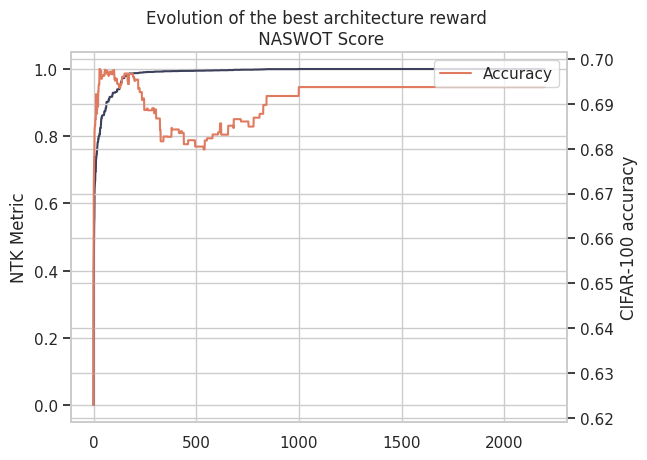

In [222]:
f, ax1 = plt.subplots()
ax1.plot(normalize(np.mean(np.array(ntks), axis=0)), label="NTK Metric", color="#3d405b")
ax1.set_ylabel("NTK Metric")

ax2 = ax1.twinx()
ax2.plot(np.mean(np.array(accs), axis=0), label="Accuracy", color="#e07a5f")
ax2.set_ylabel("CIFAR-100 accuracy")

plt.title("Evolution of the best architecture reward \n NASWOT Score"); plt.xlabel("Iteration"); plt.ylabel("CIFAR-100 accuracy"); 
plt.legend();
# plt.ylim([0.56,0.62]);
plt.savefig("figures/search_nrpa_naswot_nb201.png")
plt.show()

In [333]:
params = datasets["nas_bench_201"]
accs_ntk_nb201 = []
ntks_ntk_nb201 = []
for i in range(params["n_runs"]):
    print(f"Run {i+1} / {params['n_runs']}")

    root_node_nrpa = NASBench201NestedNode(state=NASBench201Cell(4), sequence=[])
    nrpa = NASBench201NRPA(root_node_nrpa,
                           params["nrpa_level"],
                           api=params["api"],
                           params_path="/userdata/T0259728/projets/nas_ntk/utils/params.json",
                           disable_tqdm=False, 
                           df=nas_bench_201_df)
    nrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nrpa.alpha = params["nrpa_alpha"]
    nrpa.metric = "score"
    a, b, c = nrpa.main_loop()
    accs_ntk_nb201.append(nrpa.accuracies_tracker)
    ntks_ntk_nb201.append(nrpa.best_reward)

Run 1 / 100


Current best reward : 3221561.5000: 100%|██| 2197/2197 [00:07<00:00, 296.60it/s]


Sequence is [(2, 0, 'none'), (1, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (3, 1, 'none'), (3, 0, 'none')] with score 3221561.5
Run 2 / 100


Current best reward : 3221561.5000:  32%|▉  | 712/2197 [00:02<00:04, 326.92it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Current best reward : 3221561.5000: 100%|██| 2197/2197 [00:07<00:00, 288.66it/s]


Sequence is [(3, 2, 'nor_conv_3x3'), (3, 1, 'none'), (2, 0, 'none'), (2, 1, 'nor_conv_3x3'), (3, 0, 'none'), (1, 0, 'nor_conv_3x3')] with score 3221561.5
Run 40 / 100


Current best reward : 3221561.5000: 100%|██| 2197/2197 [00:07<00:00, 289.93it/s]


Sequence is [(2, 0, 'none'), (2, 1, 'nor_conv_3x3'), (3, 1, 'none'), (3, 0, 'none'), (3, 2, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3')] with score 3221561.5
Run 41 / 100


Current best reward : 3221561.5000: 100%|██| 2197/2197 [00:07<00:00, 286.56it/s]


Sequence is [(3, 2, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 0, 'none'), (2, 0, 'none'), (3, 1, 'none'), (2, 1, 'nor_conv_3x3')] with score 3221561.5
Run 42 / 100


Current best reward : 3221561.5000: 100%|██| 2197/2197 [00:07<00:00, 285.20it/s]


Sequence is [(3, 1, 'none'), (3, 0, 'none'), (1, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (2, 0, 'none')] with score 3221561.5
Run 43 / 100


Current best reward : 3221561.5000: 100%|██| 2197/2197 [00:07<00:00, 289.69it/s]


Sequence is [(1, 0, 'nor_conv_3x3'), (3, 0, 'none'), (2, 0, 'none'), (2, 1, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (3, 1, 'none')] with score 3221561.5
Run 44 / 100


Current best reward : 3221561.5000: 100%|██| 2197/2197 [00:07<00:00, 294.58it/s]


Sequence is [(1, 0, 'nor_conv_3x3'), (3, 0, 'none'), (2, 1, 'nor_conv_3x3'), (2, 0, 'none'), (3, 1, 'none'), (3, 2, 'nor_conv_3x3')] with score 3221561.5
Run 45 / 100


Current best reward : 3221561.5000: 100%|██| 2197/2197 [00:07<00:00, 276.83it/s]


Sequence is [(3, 1, 'none'), (1, 0, 'nor_conv_3x3'), (2, 0, 'none'), (3, 2, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 0, 'none')] with score 3221561.5
Run 52 / 100


Current best reward : 3221561.5000:  55%|█ | 1207/2197 [00:04<00:03, 258.79it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Current best reward : 3221561.5000: 100%|██| 2197/2197 [00:07<00:00, 290.44it/s]


Sequence is [(2, 0, 'none'), (2, 1, 'nor_conv_3x3'), (3, 1, 'none'), (3, 2, 'nor_conv_3x3'), (3, 0, 'none'), (1, 0, 'nor_conv_3x3')] with score 3221561.5
Run 62 / 100


Current best reward : 3221561.5000: 100%|██| 2197/2197 [00:07<00:00, 279.77it/s]


Sequence is [(1, 0, 'nor_conv_3x3'), (2, 0, 'none'), (3, 2, 'nor_conv_3x3'), (3, 0, 'none'), (2, 1, 'nor_conv_3x3'), (3, 1, 'none')] with score 3221561.5
Run 63 / 100


Current best reward : 3221561.5000: 100%|██| 2197/2197 [00:07<00:00, 280.69it/s]


Sequence is [(3, 1, 'none'), (3, 2, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 0, 'none'), (2, 0, 'none')] with score 3221561.5
Run 64 / 100


Current best reward : 3221561.5000: 100%|██| 2197/2197 [00:07<00:00, 281.65it/s]


Sequence is [(3, 1, 'none'), (2, 0, 'none'), (3, 0, 'none'), (2, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3')] with score 3221561.5
Run 65 / 100


Current best reward : 3221561.5000: 100%|██| 2197/2197 [00:07<00:00, 289.89it/s]


Sequence is [(3, 0, 'none'), (2, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 1, 'none'), (3, 2, 'nor_conv_3x3'), (2, 0, 'none')] with score 3221561.5
Run 66 / 100


Current best reward : 3221561.5000: 100%|██| 2197/2197 [00:07<00:00, 286.18it/s]


Sequence is [(3, 0, 'none'), (1, 0, 'nor_conv_3x3'), (3, 1, 'none'), (2, 1, 'nor_conv_3x3'), (2, 0, 'none'), (3, 2, 'nor_conv_3x3')] with score 3221561.5
Run 67 / 100


Current best reward : 3221561.5000: 100%|██| 2197/2197 [00:07<00:00, 275.96it/s]


Sequence is [(2, 1, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (3, 0, 'none'), (3, 1, 'none'), (1, 0, 'nor_conv_3x3'), (2, 0, 'none')] with score 3221561.5
Run 68 / 100


Current best reward : 3221561.5000: 100%|██| 2197/2197 [00:07<00:00, 279.86it/s]


Sequence is [(2, 0, 'none'), (3, 1, 'none'), (3, 2, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 0, 'none')] with score 3221561.5
Run 69 / 100


Current best reward : 3221561.5000: 100%|██| 2197/2197 [00:07<00:00, 290.02it/s]


Sequence is [(3, 1, 'none'), (2, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (2, 0, 'none'), (3, 0, 'none'), (3, 2, 'nor_conv_3x3')] with score 3221561.5
Run 70 / 100


Current best reward : 3221561.5000: 100%|██| 2197/2197 [00:07<00:00, 292.50it/s]


Sequence is [(2, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 1, 'none'), (3, 0, 'none'), (3, 2, 'nor_conv_3x3'), (2, 0, 'none')] with score 3221561.5
Run 71 / 100


Current best reward : 3221561.5000: 100%|██| 2197/2197 [00:07<00:00, 285.40it/s]


Sequence is [(3, 1, 'none'), (3, 2, 'nor_conv_3x3'), (2, 0, 'none'), (2, 1, 'nor_conv_3x3'), (3, 0, 'none'), (1, 0, 'nor_conv_3x3')] with score 3221561.5
Run 72 / 100


Current best reward : 3221561.5000: 100%|██| 2197/2197 [00:07<00:00, 295.31it/s]


Sequence is [(2, 1, 'nor_conv_3x3'), (3, 1, 'none'), (3, 0, 'none'), (1, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (2, 0, 'none')] with score 3221561.5
Run 73 / 100


Current best reward : 3221561.5000: 100%|██| 2197/2197 [00:07<00:00, 282.15it/s]


Sequence is [(2, 0, 'none'), (2, 1, 'nor_conv_3x3'), (3, 1, 'none'), (3, 0, 'none'), (3, 2, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3')] with score 3221561.5
Run 74 / 100


Current best reward : 3221561.5000: 100%|██| 2197/2197 [00:07<00:00, 283.80it/s]


Sequence is [(2, 1, 'nor_conv_3x3'), (2, 0, 'none'), (3, 1, 'none'), (3, 0, 'none'), (1, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3')] with score 3221561.5
Run 75 / 100


Current best reward : 3221561.5000: 100%|██| 2197/2197 [00:07<00:00, 279.41it/s]


Sequence is [(2, 0, 'none'), (3, 0, 'none'), (3, 2, 'nor_conv_3x3'), (3, 1, 'none'), (2, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3')] with score 3221561.5
Run 76 / 100


Current best reward : 3221561.5000: 100%|██| 2197/2197 [00:08<00:00, 263.76it/s]


Sequence is [(3, 0, 'none'), (3, 2, 'nor_conv_3x3'), (2, 0, 'none'), (1, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 1, 'none')] with score 3221561.5
Run 97 / 100


Current best reward : 3221561.5000:  78%|█▌| 1704/2197 [00:06<00:01, 309.53it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



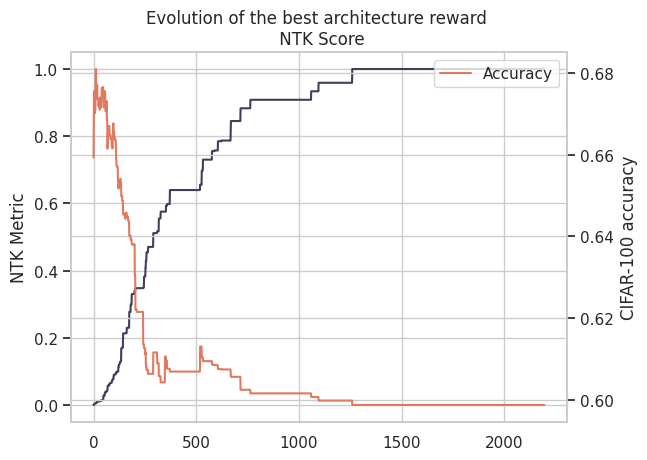

In [227]:
f, ax1 = plt.subplots()
ax1.plot(normalize(np.mean(np.array(ntks_ntk), axis=0)), label="NTK Metric", color="#3d405b")
ax1.set_ylabel("NTK Metric")

ax2 = ax1.twinx()
ax2.plot(np.mean(np.array(accs_ntk), axis=0), label="Accuracy", color="#e07a5f")
ax2.set_ylabel("CIFAR-100 accuracy" )

plt.title("Evolution of the best architecture reward \n NTK Score"); plt.xlabel("Iteration"); plt.ylabel("CIFAR-100 accuracy"); 
plt.legend();
# plt.ylim([0.56,0.62]);
plt.savefig("figures/search_nrpa_ntk_nb201.png")
plt.show()

In [334]:
params = datasets["nas_bench_201"]
accs_nasi_nb201 = []
ntks_nasi_nb201 = []
for i in range(params["n_runs"]):
    print(f"Run {i+1} / {params['n_runs']}")

    root_node_nrpa = NASBench201NestedNode(state=NASBench201Cell(4), sequence=[])
    nrpa = NASBench201NRPA(root_node_nrpa,
                           params["nrpa_level"],
                           api=params["api"],
                           params_path="/userdata/T0259728/projets/nas_ntk/utils/params.json",
                           disable_tqdm=False, 
                           df=nas_bench_201_df)
    nrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nrpa.alpha = params["nrpa_alpha"]
    nrpa.metric = "score_nasi"
    a, b, c = nrpa.main_loop()
    accs_nasi_nb201.append(nrpa.accuracies_tracker)
    ntks_nasi_nb201.append(nrpa.best_reward)

Run 1 / 100


Current best reward : 6930.1460: 100%|█████| 2197/2197 [00:07<00:00, 289.58it/s]


Sequence is [(3, 1, 'none'), (2, 0, 'none'), (3, 0, 'none'), (3, 2, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3')] with score 6930.14599609375
Run 2 / 100


Current best reward : 6930.1460:  32%|█▉    | 710/2197 [00:02<00:04, 298.49it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Current best reward : 6930.1460: 100%|█████| 2197/2197 [00:07<00:00, 275.60it/s]


Sequence is [(2, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (3, 0, 'none'), (3, 1, 'none'), (2, 0, 'none')] with score 6930.14599609375
Run 17 / 100


Current best reward : 6930.1460: 100%|█████| 2197/2197 [00:07<00:00, 283.47it/s]


Sequence is [(2, 1, 'nor_conv_3x3'), (3, 0, 'none'), (2, 0, 'none'), (3, 2, 'nor_conv_3x3'), (3, 1, 'none'), (1, 0, 'nor_conv_3x3')] with score 6930.14599609375
Run 18 / 100


Current best reward : 6930.1460: 100%|█████| 2197/2197 [00:07<00:00, 284.84it/s]


Sequence is [(3, 0, 'none'), (2, 1, 'nor_conv_3x3'), (2, 0, 'none'), (3, 2, 'nor_conv_3x3'), (3, 1, 'none'), (1, 0, 'nor_conv_3x3')] with score 6930.14599609375
Run 19 / 100


Current best reward : 6930.1460: 100%|█████| 2197/2197 [00:07<00:00, 295.15it/s]


Sequence is [(2, 1, 'nor_conv_3x3'), (2, 0, 'none'), (3, 1, 'none'), (1, 0, 'nor_conv_3x3'), (3, 0, 'none'), (3, 2, 'nor_conv_3x3')] with score 6930.14599609375
Run 20 / 100


Current best reward : 6930.1460: 100%|█████| 2197/2197 [00:07<00:00, 280.26it/s]


Sequence is [(2, 0, 'none'), (1, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 1, 'none'), (3, 0, 'none')] with score 6930.14599609375
Run 21 / 100


Current best reward : 6930.1460: 100%|█████| 2197/2197 [00:07<00:00, 294.76it/s]


Sequence is [(1, 0, 'nor_conv_3x3'), (2, 0, 'none'), (2, 1, 'nor_conv_3x3'), (3, 0, 'none'), (3, 1, 'none'), (3, 2, 'nor_conv_3x3')] with score 6930.14599609375
Run 22 / 100


Current best reward : 6930.1460: 100%|█████| 2197/2197 [00:07<00:00, 293.85it/s]


Sequence is [(1, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (3, 1, 'none'), (2, 0, 'none'), (2, 1, 'nor_conv_3x3'), (3, 0, 'none')] with score 6930.14599609375
Run 23 / 100


Current best reward : 6930.1460: 100%|█████| 2197/2197 [00:07<00:00, 282.40it/s]


Sequence is [(3, 1, 'none'), (3, 2, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (2, 0, 'none'), (3, 0, 'none'), (2, 1, 'nor_conv_3x3')] with score 6930.14599609375
Run 29 / 100


Current best reward : 6930.1460:  47%|██▎  | 1028/2197 [00:03<00:07, 148.12it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Current best reward : 6930.1460: 100%|█████| 2197/2197 [00:07<00:00, 280.50it/s]


Sequence is [(3, 0, 'none'), (3, 2, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 1, 'none'), (2, 0, 'none'), (2, 1, 'nor_conv_3x3')] with score 6930.14599609375
Run 45 / 100


Current best reward : 6435.9771: 100%|█████| 2197/2197 [00:07<00:00, 280.73it/s]


Sequence is [(3, 0, 'none'), (2, 1, 'nor_conv_1x1'), (3, 1, 'none'), (1, 0, 'nor_conv_1x1'), (3, 2, 'nor_conv_3x3'), (2, 0, 'none')] with score 6435.97705078125
Run 46 / 100


Current best reward : 6930.1460: 100%|█████| 2197/2197 [00:08<00:00, 273.92it/s]


Sequence is [(3, 0, 'none'), (3, 2, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (2, 0, 'none'), (3, 1, 'none'), (2, 1, 'nor_conv_3x3')] with score 6930.14599609375
Run 47 / 100


Current best reward : 6930.1460: 100%|█████| 2197/2197 [00:07<00:00, 279.81it/s]


Sequence is [(2, 0, 'none'), (3, 1, 'none'), (3, 0, 'none'), (1, 0, 'nor_conv_3x3'), (2, 1, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3')] with score 6930.14599609375
Run 48 / 100


Current best reward : 6930.1460: 100%|█████| 2197/2197 [00:07<00:00, 275.55it/s]


Sequence is [(2, 1, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (2, 0, 'none'), (1, 0, 'nor_conv_3x3'), (3, 1, 'none'), (3, 0, 'none')] with score 6930.14599609375
Run 49 / 100


Current best reward : 6930.1460: 100%|█████| 2197/2197 [00:07<00:00, 290.27it/s]


Sequence is [(2, 1, 'nor_conv_3x3'), (3, 0, 'none'), (3, 2, 'nor_conv_3x3'), (3, 1, 'none'), (2, 0, 'none'), (1, 0, 'nor_conv_3x3')] with score 6930.14599609375
Run 50 / 100


Current best reward : 6930.1460: 100%|█████| 2197/2197 [00:07<00:00, 284.64it/s]


Sequence is [(2, 0, 'none'), (2, 1, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (3, 1, 'none'), (3, 0, 'none'), (3, 2, 'nor_conv_3x3')] with score 6930.14599609375
Run 51 / 100


Current best reward : 6930.1460: 100%|█████| 2197/2197 [00:07<00:00, 275.26it/s]


Sequence is [(3, 1, 'none'), (3, 0, 'none'), (2, 1, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3'), (2, 0, 'none')] with score 6930.14599609375
Run 56 / 100


Current best reward : 6930.1460: 100%|█████| 2197/2197 [00:07<00:00, 279.83it/s]


Sequence is [(1, 0, 'nor_conv_3x3'), (3, 1, 'none'), (3, 0, 'none'), (2, 0, 'none'), (2, 1, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3')] with score 6930.14599609375
Run 57 / 100


Current best reward : 6435.9771:  28%|█▋    | 608/2197 [00:01<00:04, 319.30it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Current best reward : 6930.1460: 100%|█████| 2197/2197 [00:08<00:00, 272.51it/s]


Sequence is [(1, 0, 'nor_conv_3x3'), (2, 0, 'none'), (2, 1, 'nor_conv_3x3'), (3, 1, 'none'), (3, 2, 'nor_conv_3x3'), (3, 0, 'none')] with score 6930.14599609375
Run 78 / 100


Current best reward : 6930.1460: 100%|█████| 2197/2197 [00:08<00:00, 268.07it/s]


Sequence is [(2, 1, 'nor_conv_3x3'), (3, 1, 'none'), (1, 0, 'nor_conv_3x3'), (3, 0, 'none'), (3, 2, 'nor_conv_3x3'), (2, 0, 'none')] with score 6930.14599609375
Run 79 / 100


Current best reward : 6930.1460: 100%|█████| 2197/2197 [00:07<00:00, 279.94it/s]


Sequence is [(3, 2, 'nor_conv_3x3'), (3, 0, 'none'), (2, 0, 'none'), (2, 1, 'nor_conv_3x3'), (3, 1, 'none'), (1, 0, 'nor_conv_3x3')] with score 6930.14599609375
Run 80 / 100


Current best reward : 6930.1460: 100%|█████| 2197/2197 [00:07<00:00, 292.36it/s]


Sequence is [(3, 1, 'none'), (1, 0, 'nor_conv_3x3'), (3, 0, 'none'), (2, 0, 'none'), (2, 1, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3')] with score 6930.14599609375
Run 81 / 100


Current best reward : 6930.1460: 100%|█████| 2197/2197 [00:07<00:00, 281.75it/s]


Sequence is [(1, 0, 'nor_conv_3x3'), (3, 0, 'none'), (3, 1, 'none'), (2, 1, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3'), (2, 0, 'none')] with score 6930.14599609375
Run 82 / 100


Current best reward : 6930.1460: 100%|█████| 2197/2197 [00:08<00:00, 260.94it/s]


Sequence is [(3, 0, 'none'), (2, 1, 'nor_conv_3x3'), (3, 1, 'none'), (2, 0, 'none'), (1, 0, 'nor_conv_3x3'), (3, 2, 'nor_conv_3x3')] with score 6930.14599609375
Run 83 / 100


Current best reward : 6930.1460: 100%|█████| 2197/2197 [00:08<00:00, 274.18it/s]


Sequence is [(3, 1, 'none'), (2, 1, 'nor_conv_3x3'), (3, 0, 'none'), (2, 0, 'none'), (3, 2, 'nor_conv_3x3'), (1, 0, 'nor_conv_3x3')] with score 6930.14599609375
Run 89 / 100


Current best reward : 6930.1460:  92%|████▌| 2032/2197 [00:07<00:01, 135.17it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



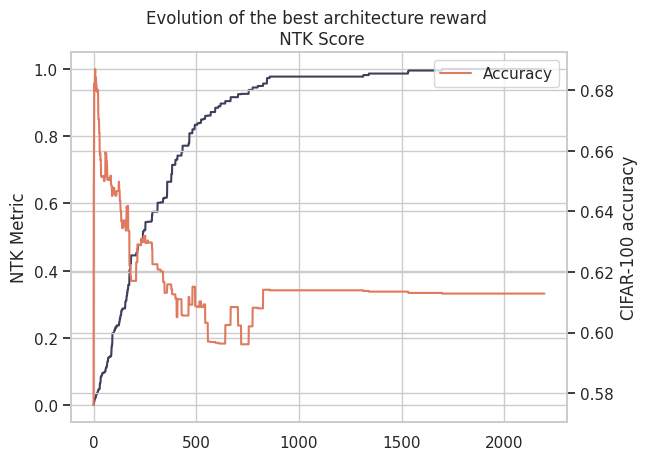

In [229]:
f, ax1 = plt.subplots()
ax1.plot(normalize(np.mean(np.array(ntks_nasi), axis=0)), label="NTK Metric", color="#3d405b")
ax1.set_ylabel("NTK Metric")

ax2 = ax1.twinx()
ax2.plot(np.mean(np.array(accs_nasi), axis=0), label="Accuracy", color="#e07a5f")
ax2.set_ylabel("CIFAR-100 accuracy")

plt.title("Evolution of the best architecture reward \n NTK Score"); plt.xlabel("Iteration"); plt.ylabel("CIFAR-100 accuracy"); 
plt.legend();
# plt.ylim([0.56,0.62]);
plt.savefig("figures/search_nrpa_nasi_nb201.png")
plt.show()

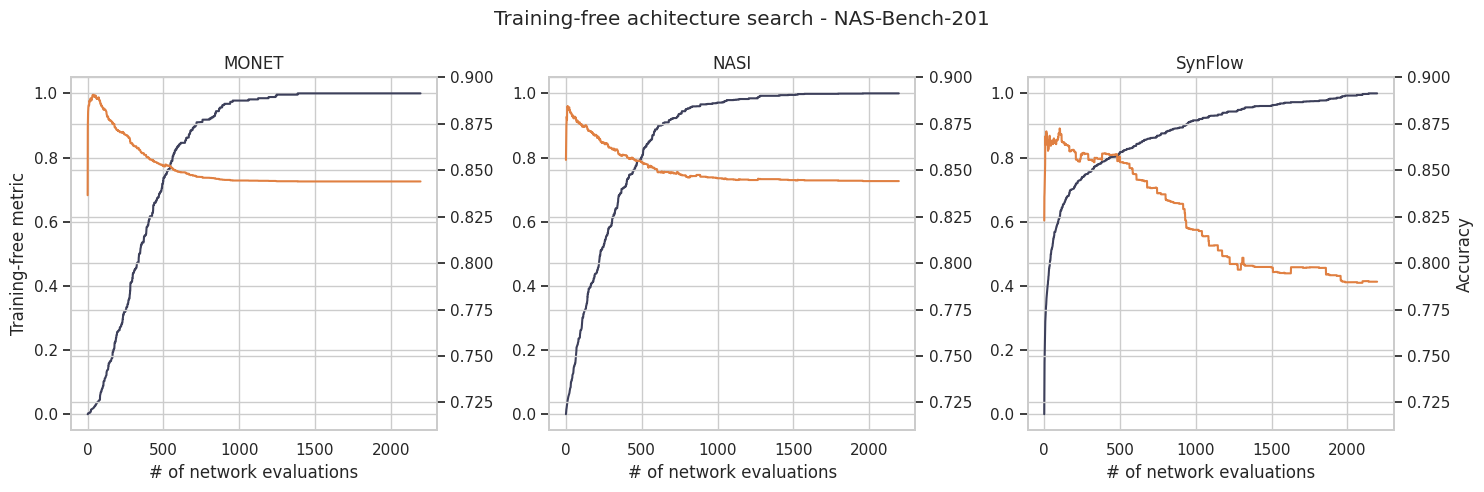

In [335]:
f, ax = plt.subplots(1,3, figsize=(15,5))
#MONET 
ax[0].plot(normalize(np.mean(np.array(ntks_ntk_nb201), axis=0)), label="NTK Metric", color=sns.color_palette()[0])
ax[0].set_ylabel("NTK Metric")

ax0 = ax[0].twinx()
ax0.plot(np.mean(np.array(accs_ntk_nb201), axis=0), label="Accuracy", color=sns.color_palette()[1])

# NASI
ax[1].plot(normalize(np.mean(np.array(ntks_nasi_nb201), axis=0)), label="NTK Metric", color=sns.color_palette()[0])

ax1 = ax[1].twinx()
ax1.plot(np.mean(np.array(accs_nasi_nb201), axis=0), label="Accuracy", color=sns.color_palette()[1])

# NASWOT
ax[2].plot(normalize(np.mean(np.array(ntks_synflow_nb201), axis=0)), label="NTK Metric", color=sns.color_palette()[0])

ax2 = ax[2].twinx()
ax2.plot(np.mean(np.array(accs_synflow_nb201), axis=0), label="Accuracy", color=sns.color_palette()[1])
ax2.set_ylabel("CIFAR-100 accuracy")

ax[0].set_ylabel("Training-free metric"); ax[1].set_ylabel(""), ax[2].set_ylabel(""); ax2.set_ylabel("Accuracy")
ax[0].set_title("MONET"); ax[1].set_title("NASI"); ax[2].set_title("SynFlow")

ax[0].set_xlabel("# of network evaluations"); ax[1].set_xlabel("# of network evaluations"), ax[2].set_xlabel("# of network evaluations")
ax0.set_ylim([0.71, 0.9]); ax1.set_ylim([0.71, 0.9]); ax2.set_ylim([0.71, 0.9])
# ax0.set_yticks([]); ax1.set_yticks([])
# ax[1].set_yticks([]); ax[2].set_yticks([])
f.suptitle("Training-free achitecture search - NAS-Bench-201")
plt.tight_layout()
plt.savefig("figures/search_monet_vs_gradient_nb201.png")
plt.show()

### On NATS-Bench

In [234]:
from nats_bench_dataset import NATSBenchMCTS
from nats_bench_dataset import NATSBenchNode
importlib.reload(NATSBenchMCTS)
importlib.reload(NATSBenchNode)
from nats_bench_dataset.NATSBenchMCTS import *
from nats_bench_dataset.NATSBenchNode import *

In [346]:
datasets["nats_bench"]["n_runs"]  = 100

In [347]:
nats_bench_df = pd.read_csv("GOOD_CSV/Cifar10-NATS.csv")
params = datasets["nats_bench"]
accs_synflow = []
ntks_synflow = []
for i in range(params["n_runs"]):
    print(f"Run {i+1} / {params['n_runs']}")

    root_node_nrpa = NATSBenchSizeNestedNode(sequence=[])
    nrpa = NATSBenchNRPA(root_node_nrpa,
                         params["nrpa_level"],
                         api=params["api"],
                         df=nats_bench_df,
                         params_path="/userdata/T0259728/projets/nas_ntk/utils/params.json",
                         disable_tqdm=False)
    nrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nrpa.alpha = params["nrpa_alpha"]
    nrpa.softmax_temp=2
    nrpa.metric = "score_synflow"
    a, b, c = nrpa.main_loop()
    accs_synflow.append(nrpa.accuracies_tracker)
    ntks_synflow.append(nrpa.best_reward)

Run 1 / 100


Current best reward : 22.4455: 100%|███████| 4096/4096 [00:13<00:00, 312.78it/s]


Sequence is [(0, 8), (1, 24), (2, 24), (4, 64), (3, 64)] with score 22.44549416362601
Run 2 / 100


Current best reward : 22.4455: 100%|███████| 4096/4096 [00:13<00:00, 302.15it/s]


Sequence is [(2, 24), (0, 8), (3, 64), (1, 24), (4, 64)] with score 22.44549416362601
Run 3 / 100


Current best reward : 22.4455: 100%|███████| 4096/4096 [00:13<00:00, 308.74it/s]


Sequence is [(0, 8), (3, 64), (1, 24), (2, 24), (4, 64)] with score 22.44549416362601
Run 4 / 100


Current best reward : 22.4455: 100%|███████| 4096/4096 [00:13<00:00, 305.52it/s]


Sequence is [(0, 8), (1, 24), (2, 24), (3, 64), (4, 64)] with score 22.44549416362601
Run 5 / 100


Current best reward : 22.4455: 100%|███████| 4096/4096 [00:12<00:00, 317.54it/s]


Sequence is [(2, 24), (0, 8), (1, 24), (4, 64), (3, 64)] with score 22.44549416362601
Run 6 / 100


Current best reward : 22.4455: 100%|███████| 4096/4096 [00:13<00:00, 302.05it/s]


Sequence is [(4, 64), (3, 64), (1, 24), (0, 8), (2, 24)] with score 22.44549416362601
Run 7 / 100


Current best reward : 21.6611: 100%|███████| 4096/4096 [00:13<00:00, 308.34it/s]


Sequence is [(1, 32), (0, 8), (4, 64), (3, 40), (2, 8)] with score 21.661122042640315
Run 8 / 100


Current best reward : 22.4455: 100%|███████| 4096/4096 [00:13<00:00, 302.33it/s]


Sequence is [(3, 64), (0, 8), (2, 24), (1, 24), (4, 64)] with score 22.44549416362601
Run 9 / 100


Current best reward : 22.4455: 100%|███████| 4096/4096 [00:13<00:00, 297.06it/s]


Sequence is [(0, 8), (3, 64), (4, 64), (1, 24), (2, 24)] with score 22.44549416362601
Run 10 / 100


Current best reward : 22.4455: 100%|███████| 4096/4096 [00:13<00:00, 313.78it/s]


Sequence is [(1, 24), (2, 24), (3, 64), (0, 8), (4, 64)] with score 22.44549416362601
Run 11 / 100


Current best reward : 22.4455: 100%|███████| 4096/4096 [00:13<00:00, 309.41it/s]


Sequence is [(2, 24), (1, 24), (0, 8), (3, 64), (4, 64)] with score 22.44549416362601
Run 12 / 100


Current best reward : 22.4455: 100%|███████| 4096/4096 [00:13<00:00, 313.98it/s]


Sequence is [(2, 24), (0, 8), (4, 64), (1, 24), (3, 64)] with score 22.44549416362601
Run 13 / 100


Current best reward : 21.6611: 100%|███████| 4096/4096 [00:12<00:00, 319.15it/s]


Sequence is [(3, 40), (1, 32), (0, 8), (2, 8), (4, 64)] with score 21.661122042640315
Run 14 / 100


Current best reward : 22.4455:  73%|█████▏ | 3003/4096 [00:15<00:02, 430.28it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Current best reward : 22.4455: 100%|███████| 4096/4096 [00:12<00:00, 323.35it/s]


Sequence is [(2, 24), (4, 64), (0, 8), (3, 64), (1, 24)] with score 22.44549416362601
Run 39 / 100


Current best reward : 21.6611: 100%|███████| 4096/4096 [00:12<00:00, 326.33it/s]


Sequence is [(4, 64), (1, 32), (3, 40), (0, 8), (2, 8)] with score 21.661122042640315
Run 40 / 100


Current best reward : 22.4455: 100%|███████| 4096/4096 [00:12<00:00, 323.07it/s]


Sequence is [(0, 8), (3, 64), (1, 24), (2, 24), (4, 64)] with score 22.44549416362601
Run 41 / 100


Current best reward : 21.4918:  72%|█████  | 2952/4096 [00:09<00:03, 355.16it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Current best reward : 22.4455: 100%|███████| 4096/4096 [00:12<00:00, 323.88it/s]


Sequence is [(1, 24), (0, 8), (4, 64), (3, 64), (2, 24)] with score 22.44549416362601
Run 62 / 100


Current best reward : 21.4918: 100%|███████| 4096/4096 [00:12<00:00, 319.69it/s]


Sequence is [(4, 64), (1, 40), (0, 8), (2, 40), (3, 64)] with score 21.49180132722655
Run 63 / 100


Current best reward : 22.4455: 100%|███████| 4096/4096 [00:13<00:00, 315.06it/s]


Sequence is [(1, 24), (3, 64), (0, 8), (4, 64), (2, 24)] with score 22.44549416362601
Run 64 / 100


Current best reward : 22.4455:  99%|██████▉| 4062/4096 [00:12<00:00, 207.61it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Current best reward : 21.4138: 100%|███████| 4096/4096 [00:12<00:00, 327.83it/s]


Sequence is [(0, 16), (3, 56), (1, 48), (4, 64), (2, 8)] with score 21.413771061829777
Run 91 / 100


Current best reward : 22.4455:  23%|█▊      | 958/4096 [00:02<00:09, 346.32it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Current best reward : 22.4455: 100%|███████| 4096/4096 [00:12<00:00, 326.46it/s]


Sequence is [(1, 24), (4, 64), (0, 8), (2, 24), (3, 64)] with score 22.44549416362601
Run 100 / 100


Current best reward : 21.6611: 100%|███████| 4096/4096 [00:12<00:00, 338.05it/s]

Sequence is [(0, 8), (1, 32), (3, 40), (2, 8), (4, 64)] with score 21.661122042640315


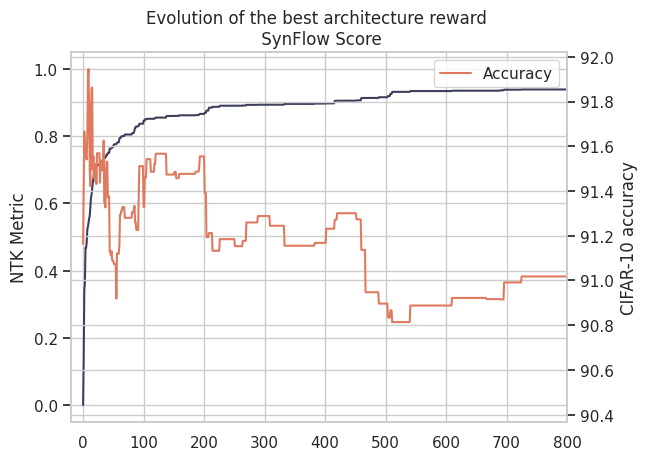

Current best reward : 22.4455:  98%|██████▊| 4000/4096 [00:22<00:00, 395.73it/s]

In [272]:
f, ax1 = plt.subplots()
ax1.plot(normalize(np.mean(np.array(ntks_synflow), axis=0)), label="NTK Metric", color="#3d405b")
ax1.set_ylabel("NTK Metric")

ax2 = ax1.twinx()
ax2.plot(np.mean(np.array(accs_synflow), axis=0), label="Accuracy", color="#e07a5f")
ax2.set_ylabel("CIFAR-100 accuracy")

plt.title("Evolution of the best architecture reward \n SynFlow Score"); plt.xlabel("Iteration"); plt.ylabel("CIFAR-10 accuracy"); 
plt.legend();

plt.xlim([-20,800])
plt.savefig("figures/search_nrpa_synflow_nats.png")
plt.show()

In [ ]:
nats_bench_df = pd.read_csv("GOOD_CSV/Cifar10-NATS.csv")
params = datasets["nats_bench"]
accs_ntk = []
ntks_ntk = []
for i in range(params["n_runs"]):
    print(f"Run {i+1} / {params['n_runs']}")

    root_node_nrpa = NATSBenchSizeNestedNode(sequence=[])
    nrpa = NATSBenchNRPA(root_node_nrpa,
                         params["nrpa_level"],
                         api=params["api"],
                         df=nats_bench_df,
                         params_path="/userdata/T0259728/projets/nas_ntk/utils/params.json",
                         disable_tqdm=False)
    nrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nrpa.alpha = params["nrpa_alpha"]
    nrpa.softmax_temp=2
    nrpa.metric = "score"
    a, b, c = nrpa.main_loop()
    accs_ntk.append(nrpa.accuracies_tracker)
    ntks_ntk.append(nrpa.best_reward)

Run 1 / 100


Current best reward : 79.0605: 100%|███████| 4096/4096 [00:12<00:00, 328.28it/s]


Sequence is [(4, 56), (0, 64), (3, 56), (1, 56), (2, 64)] with score 79.06053
Run 7 / 100


Current best reward : 79.0605:  16%|█▎      | 671/4096 [00:01<00:09, 376.37it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Current best reward : 79.0605: 100%|███████| 4096/4096 [00:12<00:00, 340.86it/s]


Sequence is [(3, 56), (0, 64), (4, 56), (1, 56), (2, 64)] with score 79.06053
Run 27 / 100


Current best reward : 79.0605:  29%|██     | 1207/4096 [00:03<00:09, 309.79it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Current best reward : 79.0605:  60%|████▏  | 2459/4096 [00:07<00:04, 346.12it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Current best reward : 79.0605: 100%|███████| 4096/4096 [00:12<00:00, 330.14it/s]


Sequence is [(4, 56), (1, 56), (3, 56), (0, 64), (2, 64)] with score 79.06053
Run 28 / 100


Current best reward : 79.0605: 100%|███████| 4096/4096 [00:12<00:00, 318.88it/s]


Sequence is [(0, 64), (2, 64), (1, 56), (4, 56), (3, 56)] with score 79.06053
Run 29 / 100


Current best reward : 79.0605: 100%|███████| 4096/4096 [00:12<00:00, 323.94it/s]


Sequence is [(3, 56), (4, 56), (0, 64), (1, 56), (2, 64)] with score 79.06053
Run 30 / 100


Current best reward : 79.0605: 100%|███████| 4096/4096 [00:12<00:00, 329.78it/s]


Sequence is [(0, 64), (3, 56), (4, 56), (2, 64), (1, 56)] with score 79.06053
Run 31 / 100


Current best reward : 79.0605: 100%|███████| 4096/4096 [00:12<00:00, 316.28it/s]


Sequence is [(4, 56), (0, 64), (2, 64), (1, 56), (3, 56)] with score 79.06053
Run 32 / 100


Current best reward : 79.0605: 100%|███████| 4096/4096 [00:12<00:00, 318.54it/s]


Sequence is [(2, 64), (1, 56), (0, 64), (4, 56), (3, 56)] with score 79.06053
Run 33 / 100


Current best reward : 79.0605: 100%|███████| 4096/4096 [00:13<00:00, 307.90it/s]


Sequence is [(4, 56), (1, 56), (0, 64), (2, 64), (3, 56)] with score 79.06053
Run 34 / 100


Current best reward : 79.0605: 100%|███████| 4096/4096 [00:12<00:00, 326.67it/s]


Sequence is [(1, 56), (2, 64), (0, 64), (4, 56), (3, 56)] with score 79.06053
Run 35 / 100


Current best reward : 79.0605: 100%|███████| 4096/4096 [00:13<00:00, 306.81it/s]


Sequence is [(4, 56), (3, 56), (0, 64), (2, 64), (1, 56)] with score 79.06053
Run 36 / 100


Current best reward : 79.0605: 100%|███████| 4096/4096 [00:13<00:00, 311.25it/s]


Sequence is [(4, 56), (1, 56), (2, 64), (3, 56), (0, 64)] with score 79.06053
Run 37 / 100


Current best reward : 79.0605: 100%|███████| 4096/4096 [00:12<00:00, 316.91it/s]


Sequence is [(3, 56), (0, 64), (4, 56), (1, 56), (2, 64)] with score 79.06053
Run 38 / 100


Current best reward : 79.0605: 100%|███████| 4096/4096 [00:12<00:00, 325.92it/s]


Sequence is [(4, 56), (1, 56), (2, 64), (3, 56), (0, 64)] with score 79.06053
Run 39 / 100


Current best reward : 79.0605: 100%|███████| 4096/4096 [00:12<00:00, 319.88it/s]


Sequence is [(4, 56), (2, 64), (1, 56), (0, 64), (3, 56)] with score 79.06053
Run 40 / 100


Current best reward : 79.0605: 100%|███████| 4096/4096 [00:12<00:00, 329.21it/s]


Sequence is [(3, 56), (1, 56), (4, 56), (2, 64), (0, 64)] with score 79.06053
Run 61 / 100


Current best reward : 57.3593:  10%|▊       | 411/4096 [00:01<00:09, 370.31it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Current best reward : 79.0605: 100%|███████| 4096/4096 [00:12<00:00, 328.14it/s]


Sequence is [(1, 56), (0, 64), (3, 56), (2, 64), (4, 56)] with score 79.06053
Run 74 / 100


Current best reward : 79.0605: 100%|███████| 4096/4096 [00:12<00:00, 334.98it/s]


Sequence is [(0, 64), (3, 56), (4, 56), (1, 56), (2, 64)] with score 79.06053
Run 75 / 100


Current best reward : 79.0605: 100%|███████| 4096/4096 [00:12<00:00, 322.05it/s]


Sequence is [(1, 56), (4, 56), (0, 64), (3, 56), (2, 64)] with score 79.06053
Run 81 / 100


Current best reward : 60.0920:  27%|█▉     | 1112/4096 [00:03<00:12, 247.82it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Current best reward : 79.0605: 100%|███████| 4096/4096 [00:12<00:00, 326.28it/s]


Sequence is [(1, 56), (0, 64), (4, 56), (2, 64), (3, 56)] with score 79.06053
Run 96 / 100


Current best reward : 79.0605: 100%|███████| 4096/4096 [00:12<00:00, 337.74it/s]


Sequence is [(3, 56), (1, 56), (4, 56), (0, 64), (2, 64)] with score 79.06053
Run 97 / 100


Current best reward : 60.0920:  39%|██▋    | 1606/4096 [00:04<00:06, 360.83it/s]

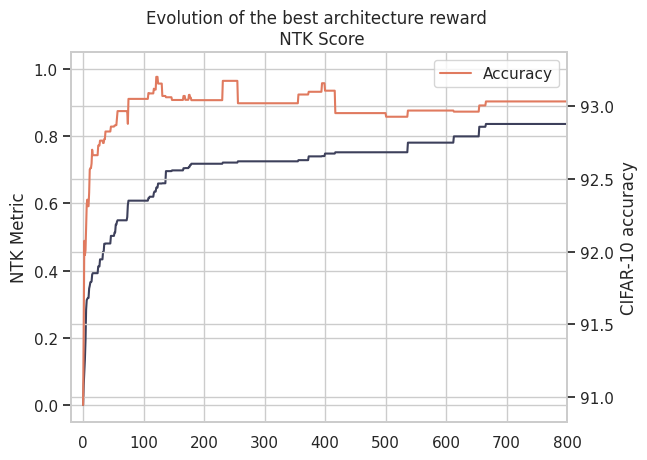

In [258]:
f, ax1 = plt.subplots()
ax1.plot(normalize(np.mean(np.array(ntks_ntk), axis=0)), label="NTK Metric", color="#3d405b")
ax1.set_ylabel("NTK Metric")

ax2 = ax1.twinx()
ax2.plot(np.mean(np.array(accs_ntk), axis=0), label="Accuracy", color="#e07a5f")
ax2.set_ylabel("CIFAR-100 accuracy")

plt.title("Evolution of the best architecture reward \n NTK Score"); plt.xlabel("Iteration"); plt.ylabel("CIFAR-10 accuracy"); 
plt.legend();

plt.xlim([-20,800])
plt.savefig("figures/search_nrpa_ntk_nats.png")
plt.show()

In [349]:
nats_bench_df = pd.read_csv("GOOD_CSV/Cifar10-NATS.csv")
params = datasets["nats_bench"]
accs_nasi = []
ntks_nasi = []
for i in range(params["n_runs"]):
    print(f"Run {i+1} / {params['n_runs']}")

    root_node_nrpa = NATSBenchSizeNestedNode(sequence=[])
    nrpa = NATSBenchNRPA(root_node_nrpa,
                         params["nrpa_level"],
                         api=params["api"],
                         df=nats_bench_df,
                         params_path="/userdata/T0259728/projets/nas_ntk/utils/params.json",
                         disable_tqdm=False)
    nrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nrpa.alpha = params["nrpa_alpha"]
    nrpa.softmax_temp=2
    nrpa.metric = "score_nasi"
    a, b, c = nrpa.main_loop()
    accs_nasi.append(nrpa.accuracies_tracker)
    ntks_nasi.append(nrpa.best_reward)

Current best reward : 23.4181: 100%|███████| 4096/4096 [00:12<00:00, 318.91it/s]


Sequence is [(1, 48), (3, 8), (2, 56), (4, 64), (0, 64)] with score 23.41814613342285
Run 3 / 100


Current best reward : 23.4135:  28%|█▉     | 1165/4096 [00:03<00:09, 302.98it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Current best reward : 23.9283:  55%|███▉   | 2272/4096 [00:06<00:05, 349.12it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Current best reward : 24.3788:  58%|████   | 2396/4096 [00:07<00:05, 325.59it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashin

Sequence is [(1, 24), (3, 8), (4, 64), (0, 64), (2, 56)] with score 24.37880516052246
Run 24 / 100


Current best reward : 23.9735: 100%|███████| 4096/4096 [00:13<00:00, 309.42it/s]


Sequence is [(4, 64), (1, 64), (3, 16), (2, 8), (0, 64)] with score 23.973472595214844
Run 25 / 100


Current best reward : 25.6871: 100%|███████| 4096/4096 [00:12<00:00, 327.43it/s]


Sequence is [(4, 64), (2, 8), (0, 64), (3, 56), (1, 48)] with score 25.68705940246582
Run 26 / 100


Current best reward : 24.3476: 100%|███████| 4096/4096 [00:12<00:00, 318.64it/s]


Sequence is [(4, 8), (2, 24), (0, 64), (1, 64), (3, 16)] with score 24.34756851196289
Run 27 / 100


Current best reward : 24.3476: 100%|███████| 4096/4096 [00:13<00:00, 312.19it/s]


Sequence is [(3, 16), (4, 8), (2, 24), (1, 64), (0, 64)] with score 24.34756851196289
Run 28 / 100


Current best reward : 23.0850: 100%|███████| 4096/4096 [00:12<00:00, 316.55it/s]


Sequence is [(2, 64), (1, 40), (4, 40), (3, 32), (0, 64)] with score 23.085020065307617
Run 29 / 100


Current best reward : 23.9735: 100%|███████| 4096/4096 [00:12<00:00, 318.56it/s]


Sequence is [(0, 64), (4, 64), (3, 16), (2, 8), (1, 64)] with score 23.973472595214844
Run 30 / 100


Current best reward : 24.3476: 100%|███████| 4096/4096 [00:12<00:00, 319.11it/s]


Sequence is [(4, 8), (0, 64), (2, 24), (1, 64), (3, 16)] with score 24.34756851196289
Run 31 / 100


Current best reward : 23.9735: 100%|███████| 4096/4096 [00:12<00:00, 321.41it/s]


Sequence is [(4, 64), (1, 64), (0, 64), (2, 8), (3, 16)] with score 23.973472595214844
Run 32 / 100


Current best reward : 23.9283:  96%|██████▋| 3923/4096 [00:11<00:00, 358.24it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Current best reward : 24.3788: 100%|███████| 4096/4096 [00:12<00:00, 321.83it/s]


Sequence is [(3, 8), (4, 64), (2, 56), (1, 24), (0, 64)] with score 24.37880516052246
Run 54 / 100


Current best reward : 24.0234: 100%|███████| 4096/4096 [00:12<00:00, 324.46it/s]


Sequence is [(1, 16), (2, 24), (3, 64), (4, 8), (0, 64)] with score 24.023406982421875
Run 55 / 100


Current best reward : 25.6871: 100%|███████| 4096/4096 [00:12<00:00, 327.45it/s]


Sequence is [(2, 8), (0, 64), (4, 64), (3, 56), (1, 48)] with score 25.68705940246582
Run 56 / 100


Current best reward : 25.6871:  74%|█████▏ | 3016/4096 [00:09<00:06, 173.42it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Current best reward : 23.4859: 100%|███████| 4096/4096 [00:12<00:00, 334.06it/s]


Sequence is [(2, 48), (1, 56), (4, 8), (3, 24), (0, 64)] with score 23.48588180541992
Run 74 / 100


Current best reward : 25.6871: 100%|███████| 4096/4096 [00:17<00:00, 234.75it/s]


Sequence is [(4, 64), (3, 56), (2, 8), (1, 48), (0, 64)] with score 25.68705940246582
Run 75 / 100


Current best reward : 23.9283: 100%|███████| 4096/4096 [00:12<00:00, 334.26it/s]


Sequence is [(2, 40), (3, 56), (1, 48), (0, 64), (4, 8)] with score 23.928340911865234
Run 81 / 100


Current best reward : 22.3764:   3%|▎       | 132/4096 [00:00<00:12, 320.59it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Current best reward : 23.9283: 100%|███████| 4096/4096 [00:12<00:00, 333.04it/s]


Sequence is [(0, 64), (3, 56), (4, 8), (1, 48), (2, 40)] with score 23.928340911865234
Run 100 / 100


Current best reward : 24.3788: 100%|███████| 4096/4096 [00:12<00:00, 337.03it/s]

Sequence is [(2, 56), (4, 64), (3, 8), (1, 24), (0, 64)] with score 24.37880516052246


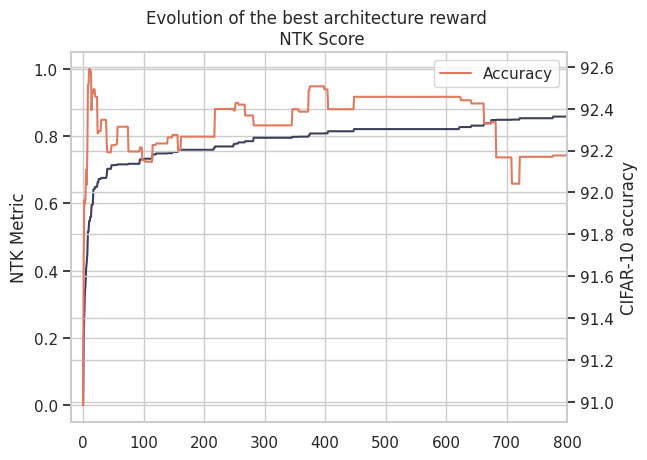

In [253]:
f, ax1 = plt.subplots()
ax1.plot(normalize(np.mean(np.array(ntks_nasi), axis=0)), label="NTK Metric", color="#3d405b")
ax1.set_ylabel("NTK Metric")

ax2 = ax1.twinx()
ax2.plot(np.mean(np.array(accs_nasi), axis=0), label="Accuracy", color="#e07a5f")
ax2.set_ylabel("CIFAR-100 accuracy")

plt.title("Evolution of the best architecture reward \n NTK Score"); plt.xlabel("Iteration"); plt.ylabel("CIFAR-10 accuracy"); 
plt.legend();

plt.xlim([-20,800])
plt.savefig("figures/search_nrpa_nasi_nats.png")
plt.show()

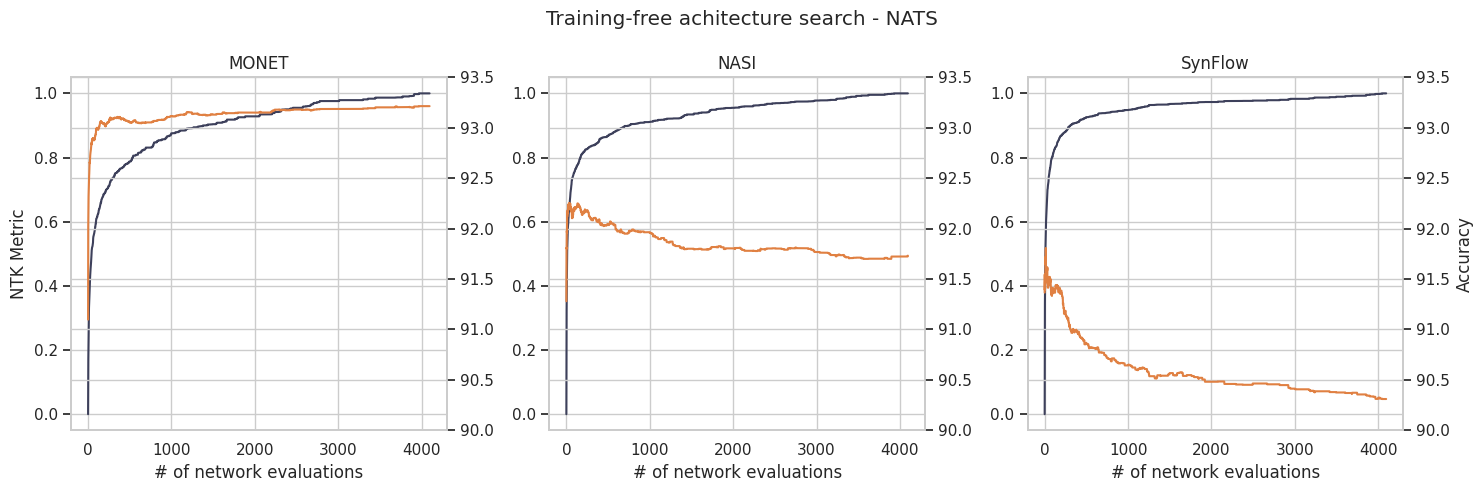

In [350]:
f, ax = plt.subplots(1,3, figsize=(15,5))
#MONET 
ax[0].plot(normalize(np.mean(np.array(ntks_ntk), axis=0)), label="NTK Metric", color=sns.color_palette()[0])
ax[0].set_ylabel("NTK Metric")

ax0 = ax[0].twinx()
ax0.plot(np.mean(np.array(accs_ntk), axis=0), label="Accuracy", color=sns.color_palette()[1])

# NASI
ax[1].plot(normalize(np.mean(np.array(ntks_nasi), axis=0)), label="NTK Metric", color=sns.color_palette()[0])

ax1 = ax[1].twinx()
ax1.plot(np.mean(np.array(accs_nasi), axis=0), label="Accuracy", color=sns.color_palette()[1])

# NASWOT
ax[2].plot(normalize(np.mean(np.array(ntks_synflow), axis=0)), label="NTK Metric", color=sns.color_palette()[0])

ax2 = ax[2].twinx()
ax2.plot(np.mean(np.array(accs_synflow), axis=0), label="Accuracy", color=sns.color_palette()[1])
ax2.set_ylabel("CIFAR-100 accuracy")

ax[0].set_ylabel("NTK Metric"); ax[1].set_ylabel(""), ax[2].set_ylabel(""); ax2.set_ylabel("Accuracy")
ax[0].set_title("MONET"); ax[1].set_title("NASI"); ax[2].set_title("SynFlow")

ax[0].set_xlabel("# of network evaluations"); ax[1].set_xlabel("# of network evaluations"), ax[2].set_xlabel("# of network evaluations")
ax0.set_ylim([90, 93.5]); ax1.set_ylim([90, 93.5]); ax2.set_ylim([90, 93.5])
# ax0.set_yticks([]); ax1.set_yticks([])
# ax[1].set_yticks([]); ax[2].set_yticks([])
f.suptitle("Training-free achitecture search - NATS")
plt.tight_layout()
plt.savefig("figures/search_monet_vs_gradient_nats.png")
plt.show()